In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import re
import ast
from scipy.stats import iqr
from sklearn.preprocessing import quantile_transform
from scipy.stats import yeojohnson

# визуализация
import matplotlib.pyplot as plt
import plotly
import plotly.express as px 
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import missingno as msno

In [2]:
# Читаем документ
df = pd.read_csv('/home/tatiana/Документы/DS SkillFactory/ДИПЛОМ/data/data.csv')

In [3]:
# Знакомимся со структурой
# df.head()

In [4]:
# Смотрим структуру с помощью функции info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
# Количество пропусков в процентах
(df.isnull().sum()/len(df)* 100).round()

status          11.0
private pool    99.0
propertyType     9.0
street           0.0
baths           28.0
homeFacts        0.0
fireplace       73.0
city             0.0
schools          0.0
sqft            11.0
zipcode          0.0
beds            24.0
state            0.0
stories         40.0
mls-id          93.0
PrivatePool     89.0
MlsId           18.0
target           1.0
dtype: float64

In [6]:
# сколько значений содержат пропуски во всех признаках
total_missing = df.isna().all(axis=1).sum()
total_missing

0

### Перевод названий признаков

- 'status' — статус продажи;
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;
- 'propertyType' — тип объекта недвижимости;
- 'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать)

#### ВЫВОД: В датасете присутствует 18 признаков и должно быть 377185 значений. Большое количество некорректно указанных названий, например, в разных регистрах. Все признаки типа 'object'. Мы видим,что в некоторых признаках пропущенно более 90% информации. Но опять же эта информация требует проверки. Т.к, например, для объекта типа land (земля) нормально если не указано количество этажей или ванных комнат. 

## Предварительная оценка и очистка целевого признака <span style="color:blue"> 'target'.</span>

Что сделано в этом пункте:
- удаление дубликатов,
- очистка признака и приведение к числовому формату
- восстановление части значений за счет данных словарей из прихнака 'homefacts'
- графический анализ признака

Посмотрим, сколько в таблице имеется полных дубликатов. Дубликаты в данный не имеют смысла для анализа, поэтому выявим и удалим их. 

In [7]:
# выявляем дублирующие записи
duplicates = df.duplicated()
print(f'Количество полных дубликатов в данных: {df[duplicates].shape[0]}')

Количество полных дубликатов в данных: 50


In [8]:
# удаляем 
df.drop_duplicates(inplace=True)

По заданию нам необходимо спрогнозировать цену на основе имеющегося признака 'target'. Посмотрим, что он из себя представляет.

In [9]:
# смотрим, что из себя представляет признак
df['target'].value_counts()

target
$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
$299,900     1276
             ... 
274,359         1
$273,490+       1
$645,000+       1
$28,272         1
$171,306        1
Name: count, Length: 43939, dtype: int64

Данные строкового типа, помимо стоимости объекта содержат различные символы. 

In [10]:
# количество пропусков 
df['target'].isnull().sum()

2480

Признак типа object, 2480 пропуска. Удалять пропуски пока не буду, в признаке homeFacts есть информация о величине объекта и стоимости за квадратный фут, постараюсь восстановить целевой признак. 
Уберем все лишние символы и преобразуем признак в числовой.

In [11]:
# Шаг 1: Удаление запятых и слов из значения
df['target'] = df['target'].str.replace(',', '').str.extract('(\d+)')

# Шаг 2: Преобразование значения в тип int, пропуская NaN
df['target'] = pd.to_numeric(df['target'], errors='coerce', downcast='integer')

In [12]:
# выделим данные с пропущенным целевым признаком 
non_target = df[df['target'].isnull()]

In [13]:
# посмотрим на признак в разрезе города
non_target['city'].value_counts()

city
Tampa            125
Jacksonville     123
Miami            113
San Antonio       91
Washington        89
                ... 
Lyndhurst          1
Centerville        1
Madeira Beach      1
Lorain             1
Norridgewock       1
Name: count, Length: 367, dtype: int64

In [14]:
# самое большое количество городов с пропущенными значениями Tampa - посмотрим поближе
non_target[non_target['city'] == 'Tampa'].head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
3862,NaN,NaN,Condo,19248 Stone Hedge Dr,3.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Tampa,"[{'rating': ['8/10', '7/10', '4/10'], 'data': ...","1,278",33647,2,FL,2,NaN,NaN,NaN,NaN
4144,NaN,NaN,Single Family,14720 Tudor Chase Dr,3.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Yes,Tampa,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...","2,910 sqft",33626,4,FL,1,NaN,NaN,NaN,NaN


Интересно, что прячется в признаке 'homeFacts'. напримере пропущенных значений Tampa

In [15]:
non_tampa = non_target[non_target['city'] == 'Tampa']

# Установка параметра для отображения полного содержимого столбца 'homeFacts'
pd.set_option('display.max_colwidth', None)

# Вывод содержимого столбца 'homeFacts'
print(non_tampa['homeFacts'])

3862                                  {'atAGlanceFacts': [{'factValue': '2006', 'factLabel': 'Year built'}, {'factValue': '2012', 'factLabel': 'Remodeled year'}, {'factValue': 'Other', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': '1 space', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}
4144                         {'atAGlanceFacts': [{'factValue': '2006', 'factLabel': 'Year built'}, {'factValue': '2008', 'factLabel': 'Remodeled year'}, {'factValue': 'Other', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': '2 spaces', 'factLabel': 'Parking'}, {'factValue': '9,744 sqft', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}
8300                {'atAGlanceFacts': [{'factValue': '2007', 'factLabel': 'Year built'}, {'factValue': '2009', 'factLabel': 'Remodeled year'}, {'factValue': 'Heat pump', 'factLabel': 'Heating

Итак, признак 'homeFacts' содержит:
- год постройки
- год реконструкции
- отопление
- тип отопления
- наличие парковки
- площадь помещения
- стоимость за квадратный фут

В словаре у нас есть площадь помещения и стоимость за квадратный фут. Попробуем восстановить часть целевого признака. 

In [16]:
# создадим два признака на основании данных из словаря
df['homeFacts'] = df['homeFacts'].apply(ast.literal_eval)
df['lotsize'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][-2]['factValue'] if x and len(x['atAGlanceFacts']) >= 2 else None)
df['price_per_sqft'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][-1]['factValue'] if x and len(x['atAGlanceFacts']) >= 1 else None)

In [17]:
# посмотрим, что представляет из себя новый признак 'lotsize'
df['lotsize'].value_counts()

lotsize
                  33055
—                 25251
No Data            5329
-- sqft lot        3819
0.26 acres         2511
                  ...  
9,212 sqft lot        1
8,762 sqft            1
1,508 Sq. Ft.         1
407 sqft              1
7,084 sqft lot        1
Name: count, Length: 37393, dtype: int64

Мы видим, что это признак типа object, с большим количеством лишних символов. Кроме того, часть указана не в футах, а в акрах. Очистим его. Приведем к числовому. Приведем к одной единице измерения - квадратные футы.

In [18]:
# Замена пустых значений, 'No Data' и '-- sqft lot' на NaN
df['lotsize'] = df['lotsize'].replace(['', 'No Data', '-- sqft lot', '—', 'NA / NaN'], np.nan)

In [19]:
#Удаление запятых из значений
df['lotsize'] = df['lotsize'].str.replace(',', '')

In [20]:
# Убираеи обозначения
df['lotsize'] = df['lotsize'].str.replace(' Sq. Ft.', '')
df['lotsize'] = df['lotsize'].str.replace(' sqft lot', '')
df['lotsize'] = df['lotsize'].str.replace(' sqft', '')
df['lotsize'] = df['lotsize'].str.replace(' lot', '')

In [21]:
# заменяем пустые значения на nan
df['lotsize'] = df['lotsize'].replace('', np.nan)

# Замена 'acres' на квадратные футы
acres_mask = df['lotsize'].str.contains('acres', case=False).fillna(False)
df.loc[acres_mask, 'lotsize'] = df.loc[acres_mask, 'lotsize'].str.extract('(\d+\.?\d*)').astype(float) * 43560 

In [22]:
# Замена 'acre' на квадратные футы
acres_mask = df['lotsize'].str.contains('acre', case=False).fillna(False)
df.loc[acres_mask, 'lotsize'] = df.loc[acres_mask, 'lotsize'].str.extract('(\d+\.?\d*)').astype(float) * 43560 

In [23]:
df['lotsize'].value_counts()

lotsize
6098      2733
7405      2711
10000     2708
6534      2239
5000      2157
          ... 
550598       1
113218       1
18540        1
38845        1
2871         1
Name: count, Length: 16661, dtype: int64

In [24]:
# посмотрим сколько в новом признаке пустых значений
#(df.isnull().sum()/len(df)* 100).round()

Теперь разберем, что собой представляет признак стоимость за квадратный фут. Так же очистим его и приведем к общему виду, если нужно. 

In [25]:
# посмотрим, что представляет собой признак 'price_per_sqft'
df['price_per_sqft'].value_counts()

price_per_sqft
               5185
No Data        1241
$1/sqft         974
No Info         954
$125/sqft       797
               ... 
$3,077/sqft       1
$2,244/sqft       1
$1,457            1
$6,141            1
$2,032            1
Name: count, Length: 6504, dtype: int64

In [26]:
# Замена пустых значений, 'No Data' и '-- sqft lot' на NaN
df['price_per_sqft'] = df['price_per_sqft'].replace(['', 'No Data', 'No Info', '-- sqft lot', '—', 'NA / NaN', 'Contact manager'], np.nan)

In [27]:
#Удаление запятых из значений
df['price_per_sqft'] = df['price_per_sqft'].str.replace(',', '')

In [28]:
# Убираеи обозначения
df['price_per_sqft'] = df['price_per_sqft'].str.replace('/sqft', '')
df['price_per_sqft'] = df['price_per_sqft'].str.replace('$', '')
df['price_per_sqft'] = df['price_per_sqft'].str.replace(' / Sq. Ft.', '')

In [29]:
# проверим есть ли значения, которые содержат что-то кроме цифр
non_numeric_values = df['price_per_sqft'].apply(lambda x: x if not str(x).isdigit() else None).dropna().tolist()
print(non_numeric_values)

[]


In [30]:
# переведем созданные признаки в числовой формат

df['lotsize'] = df['lotsize'].astype(float)
df['price_per_sqft'] = df['price_per_sqft'].astype(float)

# заполняем недостающие значения признака 'target' 
# df['target'] = df['target'].fillna(df['lotsize'] * df['price_per_sqft'])


<span style="color:red"> ВНИМАНИЕ! Начиная с ячейки 30 и до ячейки 44, я постаралась проанализировать предложенный целевой признак 'target'. Но, я считаю, что целевой признак выбран неверно, и поэтому, всю информацию я оставили закомментированной, справочно. Начиная с ячейки 45 идет объяснение и работа с новым целевым признаком.</span>

In [31]:
#df['target'].isnull().sum()

Удалось заполнить 219 значений. Удалим пустые значения из признака target, т.к они для нас не несут пользы.

In [32]:
# удалим пустые значения, создадим новый датасет df_target, с данными очищенными по признаку target
# df_target = df.dropna(subset=['target'])

In [33]:
# посмотрим как визуально отражаются точки

# plt.figure(figsize=(20, 12))
# plt.scatter(range(len(df_target['target'])), df_target['target'])
# plt.xlabel('Index')
# plt.ylabel('Target')
# plt.title

In [34]:
# как распределяется признак по штатам

# plt.figure(figsize=(20, 12))  
# sns.boxplot(x='state', y='target', data=df_target)
# plt.xlabel('Штат')
# plt.ylabel('Стоимость')
# plt.title('Стоиммость  по штатам')
# plt.show()

In [35]:
# распределение продаж по штатам, количеству продаж, общей сумме и медианно стоимоти объектов

# target_count = df_target.groupby(['state'], as_index=False)['target'].count()
# target_sum = df_target.groupby(['state'], as_index=False)['target'].sum()
# target_median = df_target.groupby(['state'], as_index=False)['target'].median()

# fig = sp.make_subplots(rows=1, cols=3, subplot_titles=('Количество покупок по штатам', 'Сумма покупок по штатам', 'Медианная стоимость жилья по штатам'))

# fig.add_trace(go.Bar(
#     x=target_count['target'],
#     y=target_count['state'],
#     name='Количество продаж',
#     orientation='h'
# ), row=1, col=1)

# fig.add_trace(go.Bar(
#     x=target_sum['target'],
#     y=target_sum['state'],
#     name='Сумма покупок',
#     orientation='h'
# ), row=1, col=2)

# fig.add_trace(go.Bar(
#     x=target_median['target'],
#     y=target_median['state'],
#     name='Медианная стоимость',
#     orientation='h'
# ), row=1, col=3)

# fig.update_layout(
#     height=800,
#     width=1500,
#     showlegend=False
# )

# fig.show()

In [36]:
# target_state = df.groupby(['state'], as_index=False)['target'].count()

# fig = px.bar(
#     data_frame=target_state,
#     x='target',
#     y='state',
#     color='state',
#     orientation='h',
#     height=800,
#     width=1000,
#     title='Количество покупок по штатам'
# )

# fig.update_layout(
#     xaxis_title='Количество',
#     yaxis_title='Штаты',
#     showlegend=False
# )

# fig.show()

In [37]:
# target_state = df.groupby(['state'], as_index=False)['target'].sum()

# fig = px.bar(
#     data_frame=target_state,
#     x='target',
#     y='state',
#     color='state',
#     orientation='h',
#     height=800,
#     width=1000,
#     title='Сумма покупок по штатам'
# )

# fig.update_layout(
#     xaxis_title='Количество',
#     yaxis_title='Штаты',
#     showlegend=False
# )

# fig.show()

Мы видим, что самая дорогая недвижимость это Калифорния и Нью Йорк. При небольшом количестве продаж значительные суммы.  

Посмотрим распределение целевого признака target

In [38]:
# посмотрим на распределение целевого признака price. 

# plt.hist(df_target['target'], bins=45)
# plt.xlabel('Стоимость')
# plt.ylabel('Количество')
# plt.title('Распределение признака target')
# plt.show()

Признак прайс не имеет нормального распределения. 

In [39]:

# # Преобразование признака с помощью квантильного преобразования
# df_target['target'] = quantile_transform(df_target[['target']], output_distribution='normal')

# # Построение гистограммы преобразованного признака
# plt.hist(df_target['target'], bins=45)
# plt.show()



In [40]:
# df_target.loc[:, 'target'] = quantile_transform(df_target[['target']], output_distribution='normal')

# # Построение гистограммы преобразованного признака
# plt.hist(df_target['target'], bins=45)
# plt.show()

In [41]:
# df_target['target'], _ = yeojohnson(df_target['target'])
 
# plt.hist(df['target'])
# plt.title('Трансформированное распределение признака target')
# plt.show()



Оценим выбросы

In [42]:

# fig, ax = plt.subplots(1, 1, figsize=(15, 8))
# log_target = np.log(df_target['target'] +1)
# histplot = sns.histplot(log_target, bins=45, ax=ax)
# histplot.axvline(log_target.mean(), color='k', lw=2)
# histplot.axvline(log_target.mean()+ 3 * log_target.std(), color='k', ls='--', lw=2)
# histplot.axvline(log_target.mean()- 3 * log_target.std(), color='k', ls='--', lw=2)
# histplot.set_ylabel('Количество продаж')
# histplot.set_title('Log target');

In [43]:
# def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
#     if log_scale:
#         x = np.log(data[feature]+1)
#     else:
#         x = data[feature]
    
#     mu = x.mean() 
#     sigma = x.std() 
    
#     lower_bound = mu - left * sigma 
#     upper_bound = mu + right * sigma 
    
#     # очистка данных
#     outliers = data[(x < lower_bound) | (x > upper_bound)]
#     cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
#     return outliers, cleaned

# outliers, cleaned = outliers_z_score_mod(df_target, 'target', left=3, right=3, log_scale=True)
# print(f'Число выбросов по z-методу: {outliers.shape[0]}')
# print(f'Результирующее число записей: {cleaned.shape[0]}')

In [44]:

# # Рассчитываем межквартильный размах
# Q1 = df_target['target'].quantile(0.25)
# Q3 = df_target['target'].quantile(0.75)
# IQR = iqr(df_target['target'])

# # Определяем границы выбросов
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Фильтруем данные и находим выбросы
# outliers = df_target[(df_target['target'] < lower_bound) | (df_target['target'] > upper_bound)]

# # Выводим количество выбросов
# print("Количество выбросов в признаке 'target' по методу Тьюки:", len(outliers))

In [45]:
# # Рассчитываем среднее и стандартное отклонение
# mean = df_target['target'].mean()
# std = df_target['target'].std()

# # Определяем порог z-score для выбросов (обычно используется значение 3)
# threshold = 3

# # Стандартизируем данные
# z_scores = (df_target['target'] - mean) / std

# # Фильтруем данные и находим выбросы
# outliers = df_target[np.abs(z_scores) > threshold]

# # Выводим количество выбросов
# print("Количество выбросов в признаке 'target' по z-методу:", len(outliers))

Итак, проанализировав целевой признак в общем, мы видим, что он содержит большое количество пропусков и выбросов. Понятно, что по правилам мы считаем выбросами слишком большие или слишком маленькие суммы, которые могут быть как ошибочными, так и просто дорогой или дешевой недвижимостью.  

На данном этапе  я хочу изменить целевой признак, предсказывать не общую стоимость объекта, а стоимость за квадратный фут. 
Дело в том, что данные содержат большое количество неточностей, а признак "полная стоимость" - составной. Это метраж умноженный на стоимость. Даже без карты корреляций, понятно, что признак скоррелирован с площадью, т.к и там и там есть это значение. 
Стоимость за квадратный метр - простой. Кроме того в данных достаточно признаков, которые могут влиять на стоимость квадратного метра. Это и количество этажей, комнат и  площадь.

Если мы заменим целевой признак, то:
- будут более корректно считаться выбросы. Ведь выбросы могут быть и не выбросами, а просто очень большой площадью дома, например.
- не будет "задваиваться" информация о площади. Т.к с случае с целевым признаком - полная стоимость объекта у нас площадь есть и отдельный признак, а так же составная часть в стоимости. 
- для клиента данное изменение не критично, т.к при выведении ответа можно просто стоимость за квадратный фут умножать на площадь. 

Так же из словарей я хочу создать несколько новых признаков в дальнейшем мы проанализируем какое влияние оказывают на целевой признак эти признаки: 

- жилой это объект или эта продажа для бизнеса. У нас есть объекты: земля, многоквартирный дом - которые продаются целиком, скорее всего инвесторам, дома различных типов и промышленные здания. 
- наличие парковки
- отопление
- наличие школы 
- реконструкция 
- год постройки

## Создание и проверка целевого признака <span style="color:blue"> 'target_per_sqft'.</span>

Что сделано:
- создание признака 'target_per_sqft' - стоимость за квадратный метр, на основе данных датасета
- очистка признака 'price_per_sqft' - стоимость за квадратный метр, из словаря
- сравнение двух признаков
- удаление некорректных или отсутствующих значений
- проверка признака 'target_per_sqft' на выбросы
- удаление выбросов
- анализ зависимости стоимости и метража, выбросы и некорректные значения


Чтобы корректно сформировать новый целевой признак я хочу проверить имеющийся 'price_per_sqft' - из словаря. Так же мы можем узнать стоимость квадратного метра разделив стоимость 'target' на площадь 'sqft' - эти данные были в датасете.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377135 entries, 0 to 377184
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337218 non-null  object 
 1   private pool    4181 non-null    object 
 2   propertyType    342402 non-null  object 
 3   street          377133 non-null  object 
 4   baths           270827 non-null  object 
 5   homeFacts       377135 non-null  object 
 6   fireplace       103111 non-null  object 
 7   city            377101 non-null  object 
 8   schools         377135 non-null  object 
 9   sqft            336585 non-null  object 
 10  zipcode         377135 non-null  object 
 11  beds            285881 non-null  object 
 12  state           377135 non-null  object 
 13  stories         226461 non-null  object 
 14  mls-id          24942 non-null   object 
 15  PrivatePool     40310 non-null   object 
 16  MlsId           310266 non-null  object 
 17  target         

Очистим признак 'sqft' от букв и символов. 

In [47]:
# Шаг 1: Удаление запятых и слов из значения
df['sqft'] = df['sqft'].str.replace(',', '').str.extract('(\d+)')

# Шаг 2: Преобразование значения в тип int, пропуская NaN
df['sqft'] = pd.to_numeric(df['sqft'], errors='coerce', downcast='integer')

In [48]:
# создаем признак стоимость за квадратный фут на основе данных датасета

# Создаем новый признак target_per_sqft
df['target_per_sqft'] = np.nan

# Вычисляем стоимость за квадратный фут
df['target_per_sqft'] = df['target'] / df['sqft']

# Заменяем значения на NaN в случае пропусков или деления на 0
df.loc[(df['target'].isnull()) | (df['sqft'].isnull()) | (df['sqft'] == 0), 'target_per_sqft'] = np.nan

In [49]:
# проверим совпадает ли средняя стоимость
print('Средняя стоимость квадратного фута в признаке из словаря:', df['price_per_sqft'].mean().round())
print('Средняя стоимость квадратного фута в созданном признаке:', df['target_per_sqft'].mean().round())

Средняя стоимость квадратного фута в признаке из словаря: 478.0
Средняя стоимость квадратного фута в созданном признаке: 478.0


In [50]:
# проверим совпадает ли медианная стоимость
print('Медианная стоимость квадратного фута в признаке из словаря:', round(df['price_per_sqft'].median()))
print('Медианная стоимость квадратного фута в созданном признаке:', round(df['target_per_sqft'].median()))

Медианная стоимость квадратного фута в признаке из словаря: 177
Медианная стоимость квадратного фута в созданном признаке: 177


In [51]:
# количество пропусков в признаке из словаря
df['price_per_sqft'].isnull().sum()

65909

In [52]:
# количество пропусков в созданном признаке
df['target_per_sqft'].isnull().sum()

55239

Теперь у нас есть два целевых признака, которые мы условно взяли из разных источников. Один на основании данных из датафрейма 'target_per_sqft', другой из словаря 'price_per_sqft'. Мы не знаем откуда взяты данные и их источники. Но, можно выяснить насколько значения отличаются.

Создадим новый признак 'compare_tag' где сравним данные построчно. Если разница между данными более 30, то в признак заносим false, если менее 30, то true. Если какое-то из значений отсутствует, то Nan.

In [53]:
# Создаем новый признак compare_targ
df['compare_targ'] = np.where(abs(df['price_per_sqft'] - df['target_per_sqft']) > 30, 'False',
                             np.where(abs(df['price_per_sqft'] - df['target_per_sqft']) <= 30, 'True', np.nan))

In [54]:
# итог вычислений
df['compare_targ'].value_counts()

compare_targ
True     309472
nan       67520
False       143
Name: count, dtype: int64

Мы видим, что только 309472 значения заполнены в том и другом случае и совпали. Считаю, что на данном этапе, мы проверили доступные нам данные с пометко True самые корректные. Берем в работу только их. 

In [55]:
# Создаем новый дф, который включает только значения True
df_per_sqft = df[df['compare_targ']== 'True']

Удаляем вспомогательные признаки 'price_per_sqft' и 'compare_targ'.

In [56]:
df_per_sqft = df_per_sqft.drop(['price_per_sqft', 'compare_targ'], axis=1)

## Проверим новый признак 'target_per_sqft' на выбросы и распределение. 

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

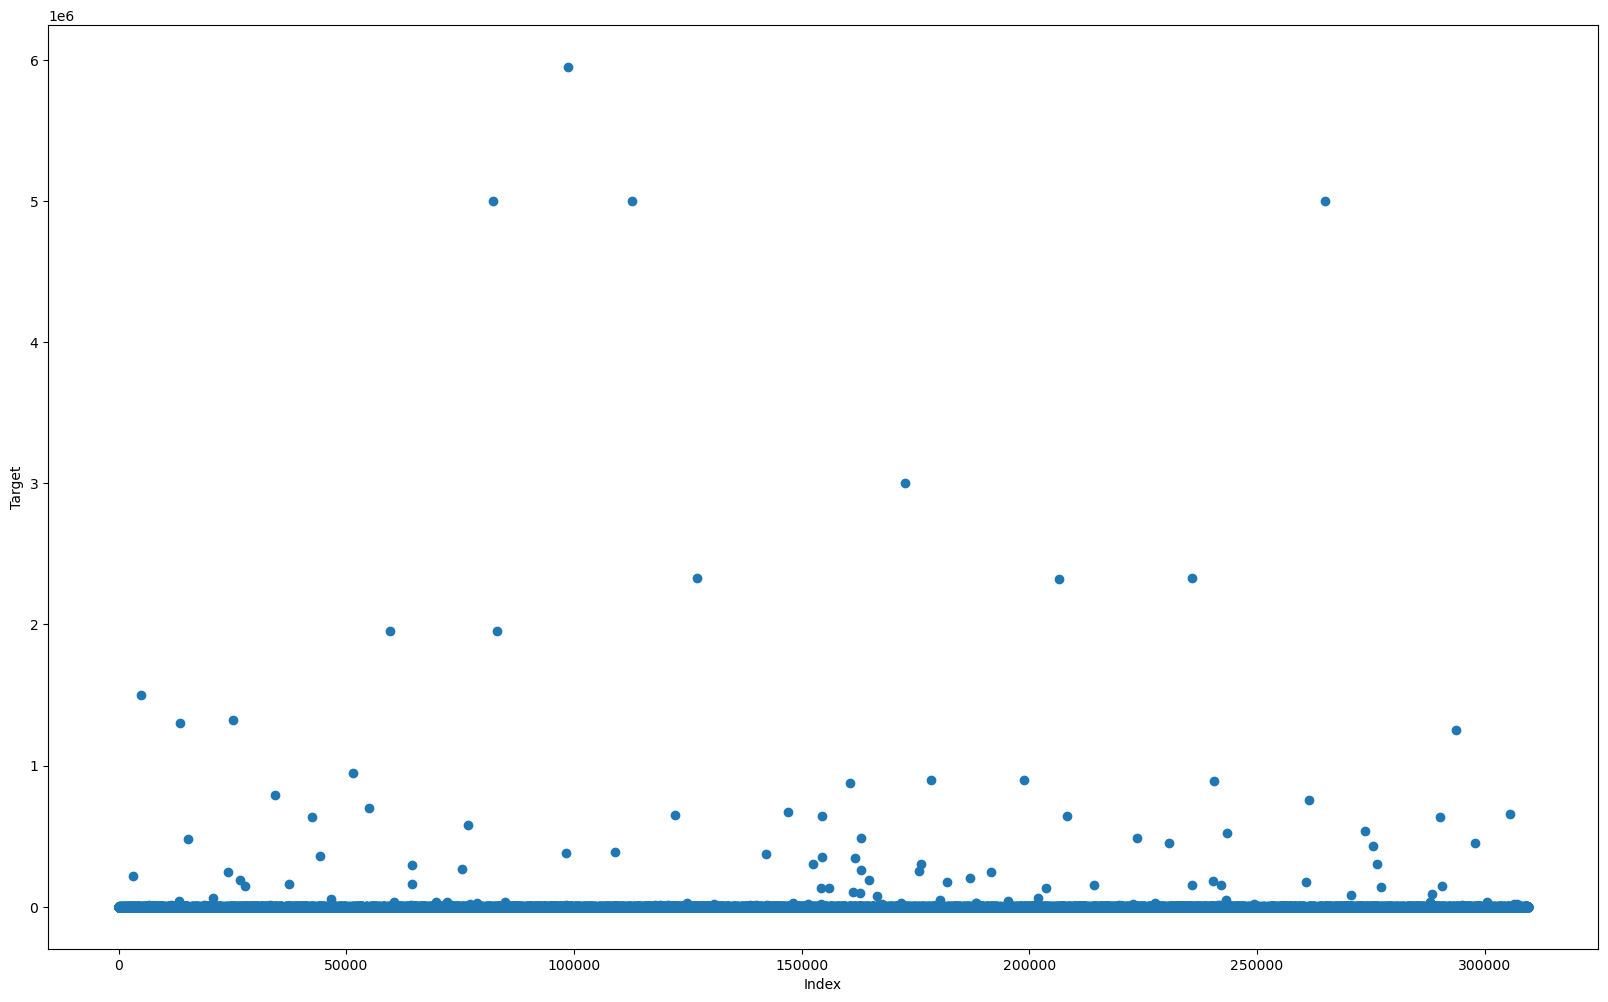

In [57]:
# посмотрим как распределяется признак графически

plt.figure(figsize=(20, 12))
plt.scatter(range(len(df_per_sqft['target_per_sqft'])), df_per_sqft['target_per_sqft'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.title

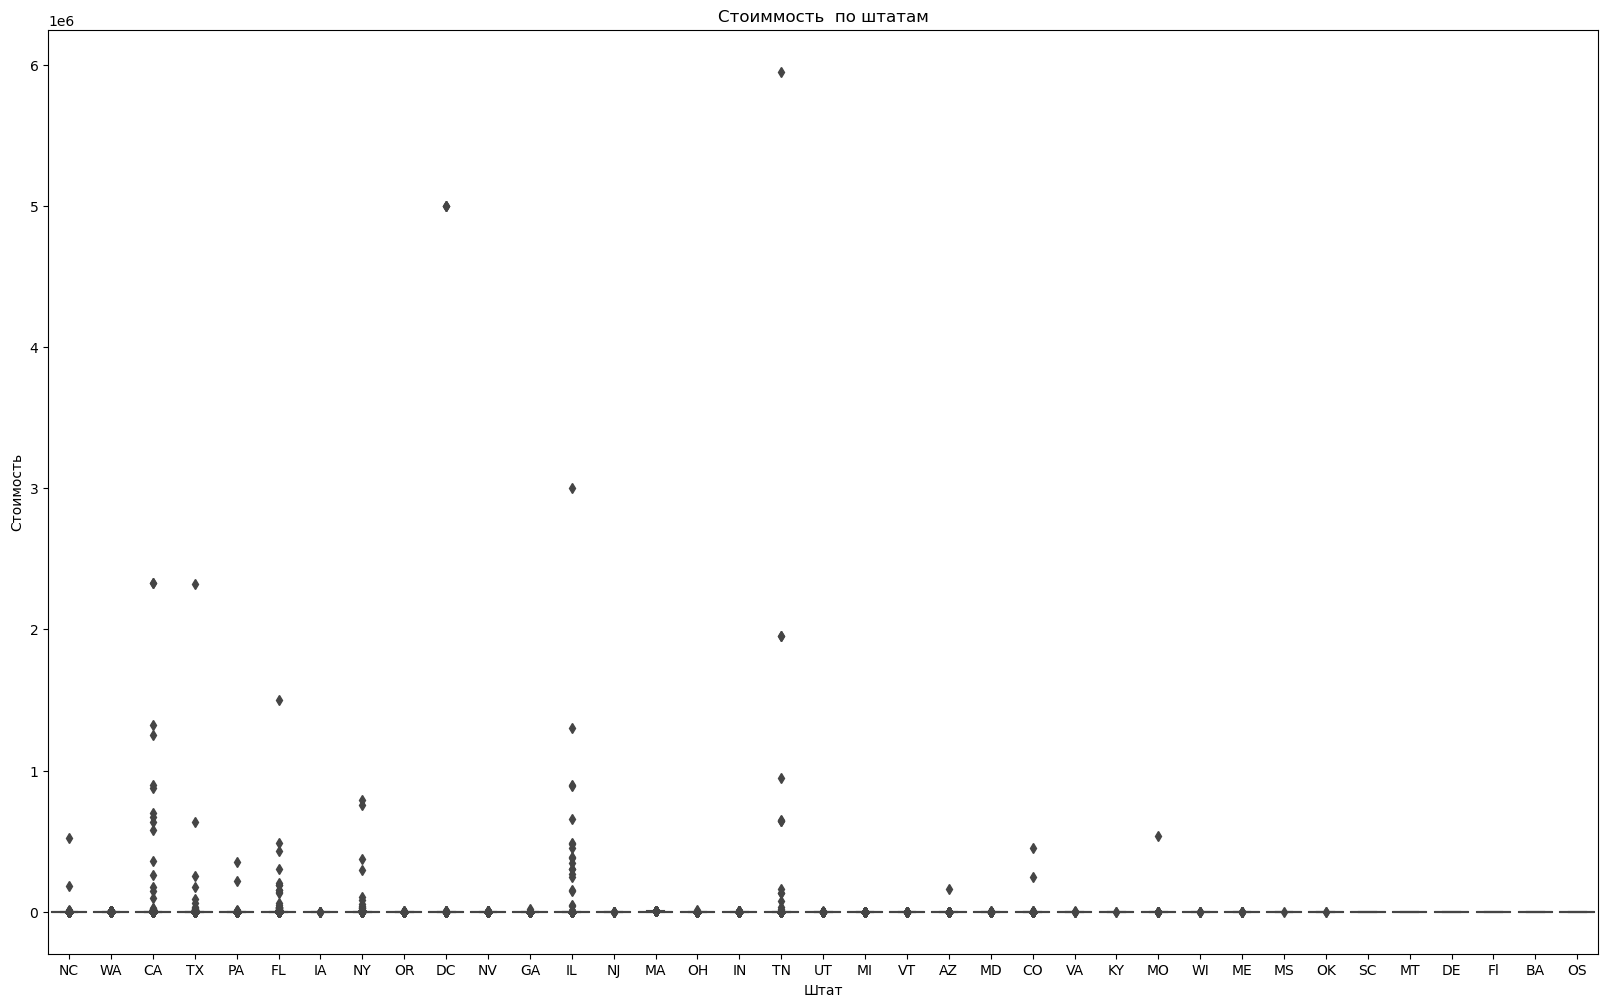

In [58]:
# как распределяется признак по штатам

plt.figure(figsize=(20, 12))  
sns.boxplot(x='state', y='target_per_sqft', data=df_per_sqft)
plt.xlabel('Штат')
plt.ylabel('Стоимость')
plt.title('Стоиммость  по штатам')
plt.show()

In [59]:
# распределение продаж по штатам, средней и медианной стоимости за квадратный метр по штатам

target_count = df_per_sqft.groupby(['state'], as_index=False)['target_per_sqft'].count()
target_mean = df_per_sqft.groupby(['state'], as_index=False)['target_per_sqft'].mean()
target_median = df_per_sqft.groupby(['state'], as_index=False)['target_per_sqft'].median()

fig = sp.make_subplots(rows=1, cols=3, subplot_titles=('Количество покупок по штатам', 'Средняя стоимость квадратного метра', 'Медианная стоимость квадратного метра'))

fig.add_trace(go.Bar(
    x=target_count['target_per_sqft'],
    y=target_count['state'],
    name='Количество продаж',
    orientation='h'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=target_mean['target_per_sqft'],
    y=target_mean['state'],
    name='Средняя стоимость',
    orientation='h'
), row=1, col=2)


fig.add_trace(go.Bar(
    x=target_median['target_per_sqft'],
    y=target_median['state'],
    name='Медианная стоимость',
    orientation='h'
), row=1, col=3)

fig.update_layout(
    height=800,
    width=1500,
    showlegend=False
)

fig.show()

Первые два графика нам совершенно не дают рассмотреть выбросы. На третьем графике хорошо видно, что средняя и медианная стоимость очень сильно различаются, что есть штаты с очень дорогой недвижимостью, например Нью-Йорк и Майами. 

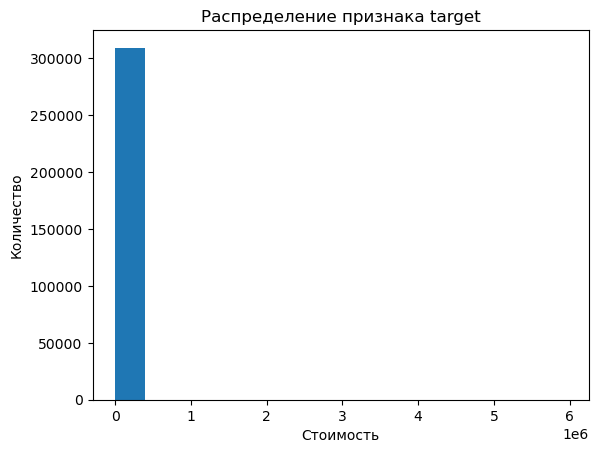

In [60]:
# посмотрим на распределение необработанного целевого признака
plt.hist(df_per_sqft['target_per_sqft'], bins=15)
plt.xlabel('Стоимость')
plt.ylabel('Количество')
plt.title('Распределение признака target')
plt.show()

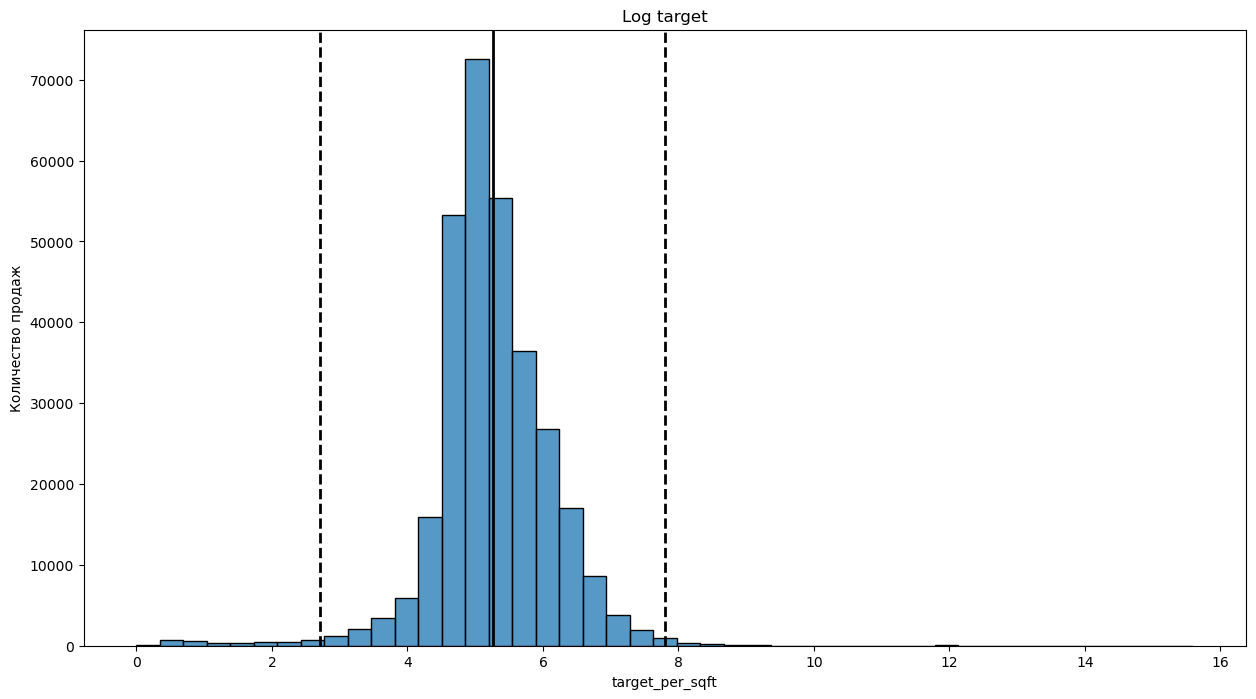

In [61]:
# распределение и выбросы прологорифмированного признака
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
log_target = np.log(df_per_sqft['target_per_sqft'] +1)
histplot = sns.histplot(log_target, bins=45, ax=ax)
histplot.axvline(log_target.mean(), color='k', lw=2)
histplot.axvline(log_target.mean()+ 3 * log_target.std(), color='k', ls='--', lw=2)
histplot.axvline(log_target.mean()- 3 * log_target.std(), color='k', ls='--', lw=2)
histplot.set_ylabel('Количество продаж')
histplot.set_title('Log target');

Определим количество выбросов по методу Тьюки и по Z-методу

In [62]:
# Рассчитываем межквартильный размах
Q1 = df_per_sqft['target_per_sqft'].quantile(0.25)
Q3 = df_per_sqft['target_per_sqft'].quantile(0.75)
IQR = iqr(df_per_sqft['target_per_sqft'])

# Определяем границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные и находим выбросы
outliers_t = df_per_sqft['target_per_sqft'][(df_per_sqft['target_per_sqft'] < lower_bound) | (df_per_sqft['target_per_sqft'] > upper_bound)]

# Выводим количество выбросов
print("Количество выбросов в признаке 'target_per_sqft' по методу Тьюки:", len(outliers_t))

Количество выбросов в признаке 'target_per_sqft' по методу Тьюки: 27212


In [63]:
# Рассчитываем среднее и стандартное отклонение
mean = df_per_sqft['target_per_sqft'].mean()
std = df_per_sqft['target_per_sqft'].std()

# Определяем порог z-score для выбросов (обычно используется значение 3)
threshold = 3

# Стандартизируем данные
z_scores = (df_per_sqft['target_per_sqft'] - mean) / std

# Фильтруем данные и находим выбросы
outliers_z = df_per_sqft[np.abs(z_scores) > threshold]

# Выводим количество выбросов
print("Количество выбросов в признаке 'target_per_sqft' по z-методу:", len(outliers_z))

Количество выбросов в признаке 'target_per_sqft' по z-методу: 76


Я попробовала удалить выбросы по методу Тьюки, и пришла к выводу, что данных остается слишком мало. Для меня было бы обосновано, если бы при применении метода очистки по Тьюки  стало меньше пропусков в признаках, но они так и остались. Поэтому, почистим данные по z методу и в ручную, переработаем и создадим новые признаки, и вернемся к очистке еще раз.

In [64]:
# Удаляем строки с выбросами по z методу
df_per_sqft = df_per_sqft.drop(outliers_z.index)

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

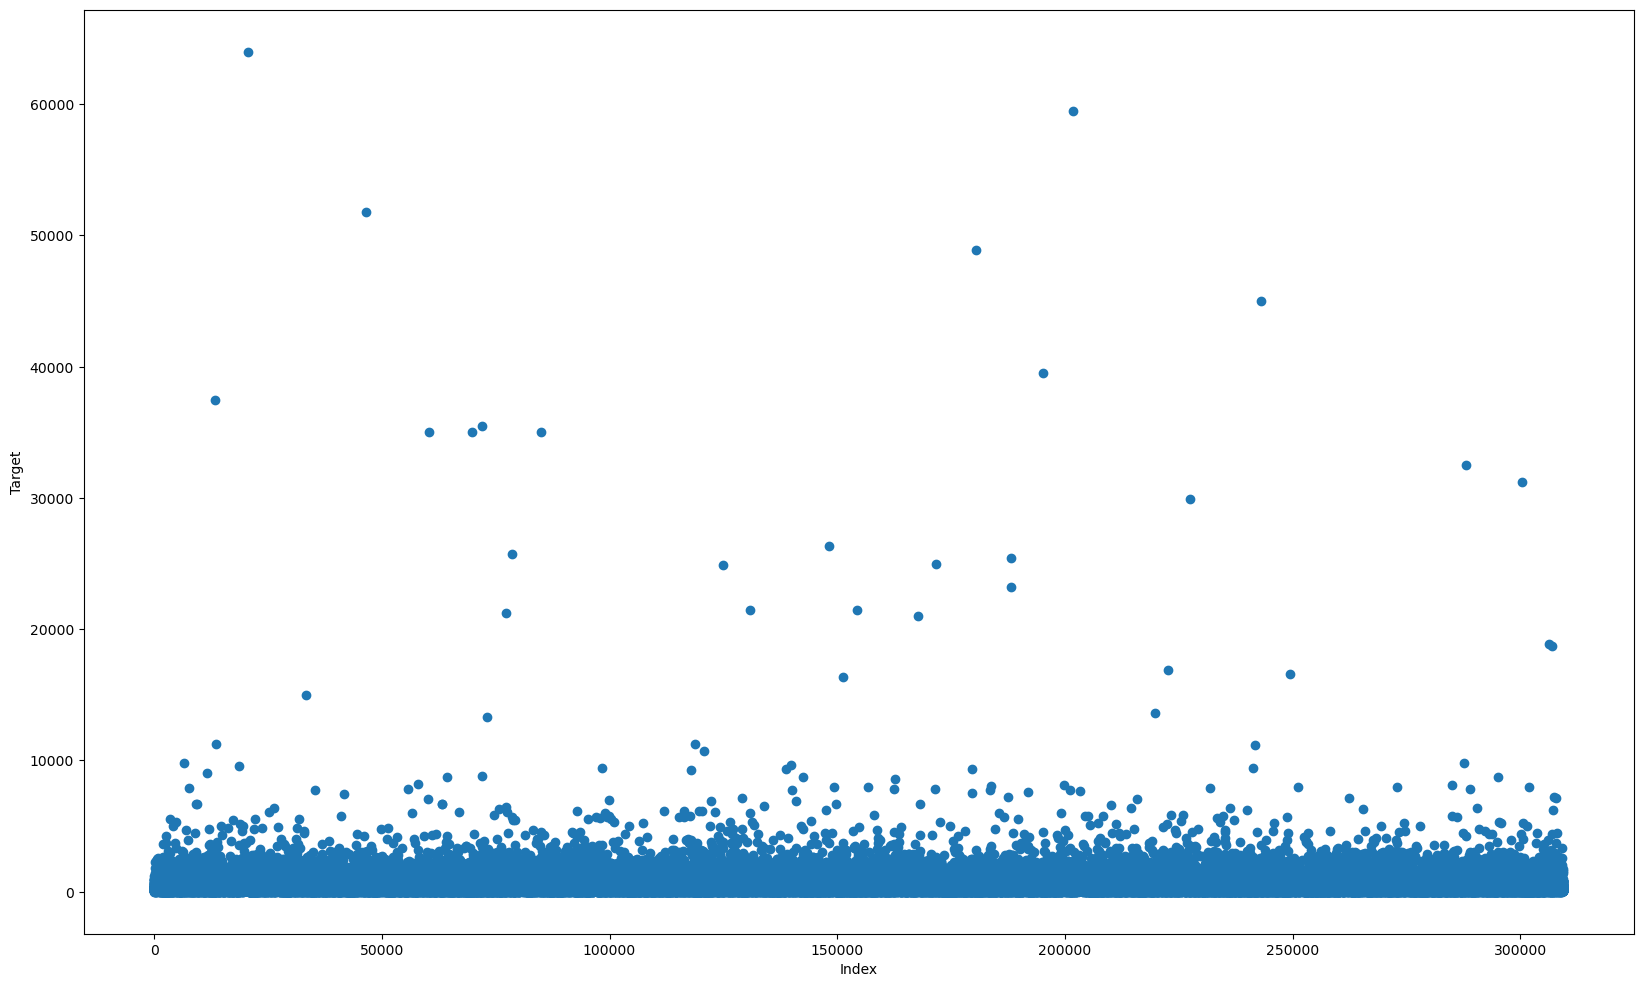

In [65]:
# посмотрим как визуально отражаются точки

plt.figure(figsize=(20, 12))
plt.scatter(range(len(df_per_sqft['target_per_sqft'])), df_per_sqft['target_per_sqft'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.title

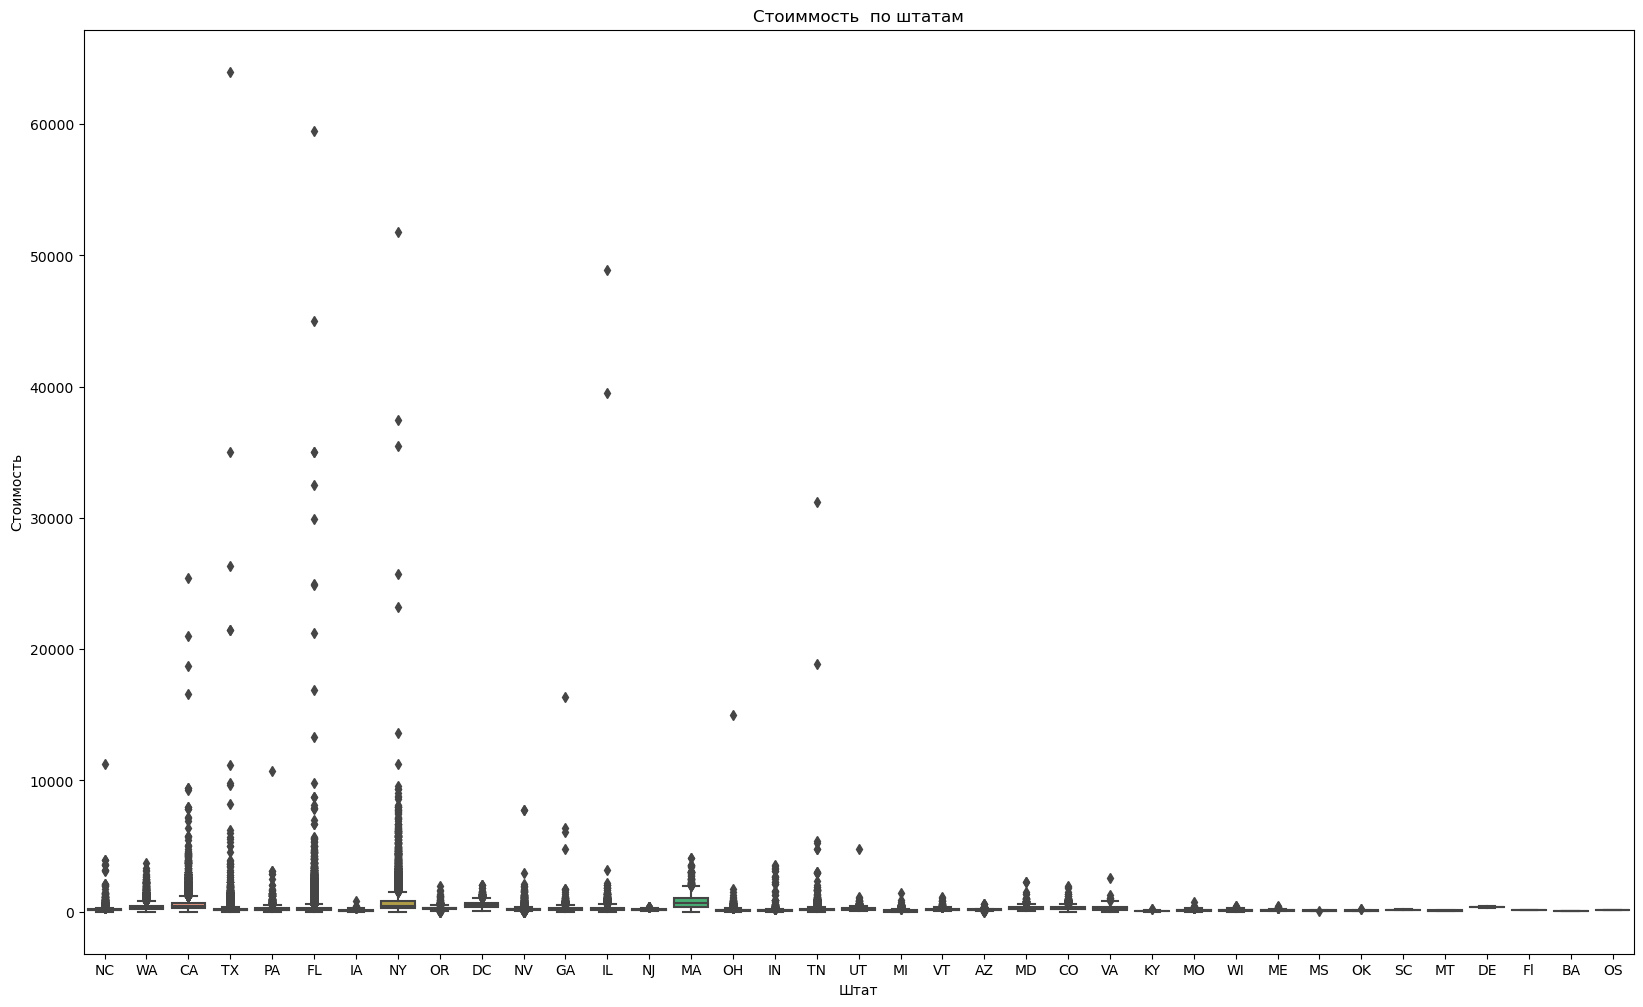

In [66]:
# как распределяется признак по штатам

plt.figure(figsize=(20, 12))  
sns.boxplot(x='state', y='target_per_sqft', data=df_per_sqft)
plt.xlabel('Штат')
plt.ylabel('Стоимость')
plt.title('Стоиммость  по штатам')
plt.show()

Уже лучше. Мы уже можем различить некоторое распределение по штатам. Мы видим, что  у нас есть небольшое количество точек со стоимостью за квадратный метр, которые выходят за 5000$. 173 объекта. Если учитывать, что средняя стоимость квадратного метра равна 273$, а медианная 173, то конечно эти точки можно считать выбросами. Удалим их.

In [67]:
# средняя чтоимость 
df_per_sqft['target_per_sqft'].mean()

272.62774944505986

In [68]:
# медианная стоимость 
df_per_sqft['target_per_sqft'].median()

177.49802118388806

In [69]:
# количество объектов со стоимостью более 5000$ за квадратный фут
len(df_per_sqft[df_per_sqft['target_per_sqft'] > 5000])

173

In [70]:
# удалим объекты стоимостью более 5 000 за квадратный фут
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['target_per_sqft'] > 5000].index)

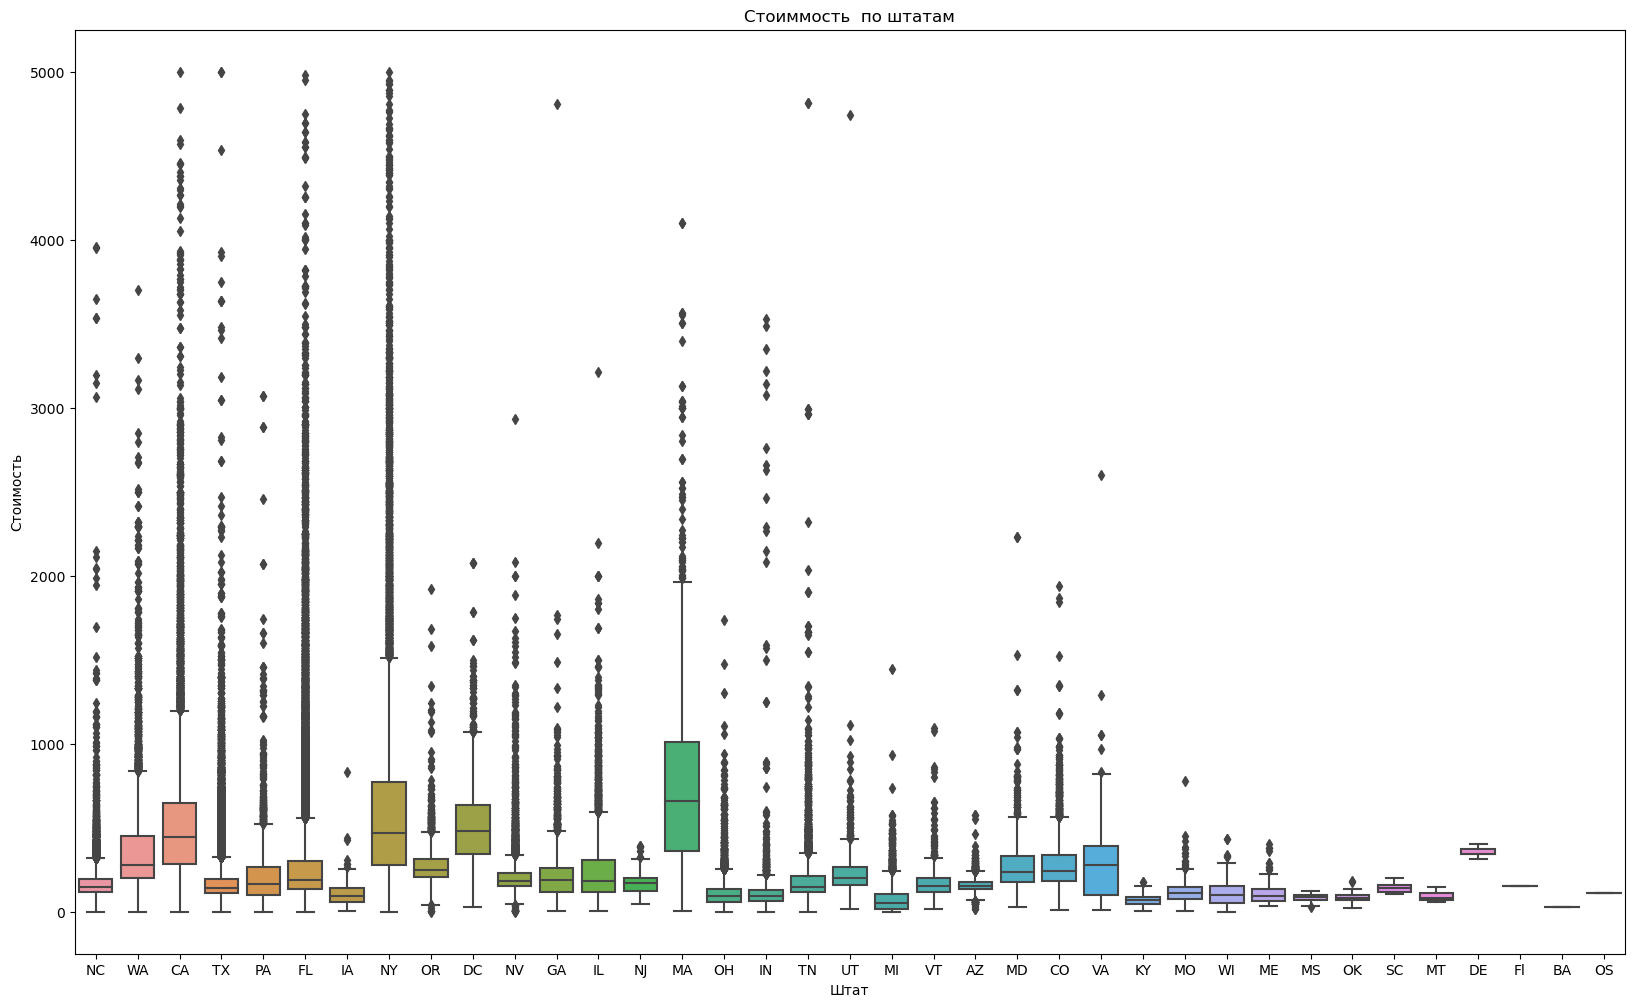

In [71]:
# как распределяется признак по штатам

plt.figure(figsize=(20, 12))  
sns.boxplot(x='state', y='target_per_sqft', data=df_per_sqft)
plt.xlabel('Штат')
plt.ylabel('Стоимость')
plt.title('Стоиммость  по штатам')
plt.show()

Мы видим что самая дорогая недвижимость у нас в Майами, но даже здесь есть выбросы более 2000$. Посмотрим сколько их и удалим.

In [72]:
# количество объектов более 2000$ за квадратный фут
len(df_per_sqft[df_per_sqft['target_per_sqft'] > 2000])

1512

In [73]:
# удалим объекты стоимостью более 2 000 за квадратный фут
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['target_per_sqft'] > 2000].index)

Так же у нас есть объекты, которые стоят очень дешево. Не представляю себе недвижимость, стоимоть за квадратный метр которой менее 100 долларов, а уж 10 или 1 и подавно. Посмотрим на эти значения поближе. Если взять стоимость менее 100 долларов, то таких объектов 43537 - это много. Кроме того большая часть недвижимости оказывается в Техасе, а там очень большие площади и как знать, может, это реальная стоимость за квадратный метр.  Если взять меньше 1000, то это вообще почти весь датасет. Если мы берем меньше 20, то объектов 4255. Удалим их. Если потребуется при дальнейшем анализе, то эту вилку можно либо увеличить, либо уменьшить. 

In [74]:
# количество объектов стоимостью менее 20$ за квадратный фут
df_cheap = df_per_sqft[df_per_sqft['target_per_sqft'] < 20 ]
len(df_cheap)

4255

In [75]:
# основные singlfamity - явная ошибка, земля, коммерческая недвижимость 
df_cheap['propertyType'].value_counts().head(10)

propertyType
single-family home     1428
lot/land               1042
coop                    443
Single Family           249
multi-family            179
Single Family Home      175
Multi-Family Home       107
mobile/manufactured      75
Multi Family             72
Cooperative              45
Name: count, dtype: int64

In [76]:
# удалим объекты стоимостью менее 20 долларов за квадратный фут
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['target_per_sqft'] < 20].index)

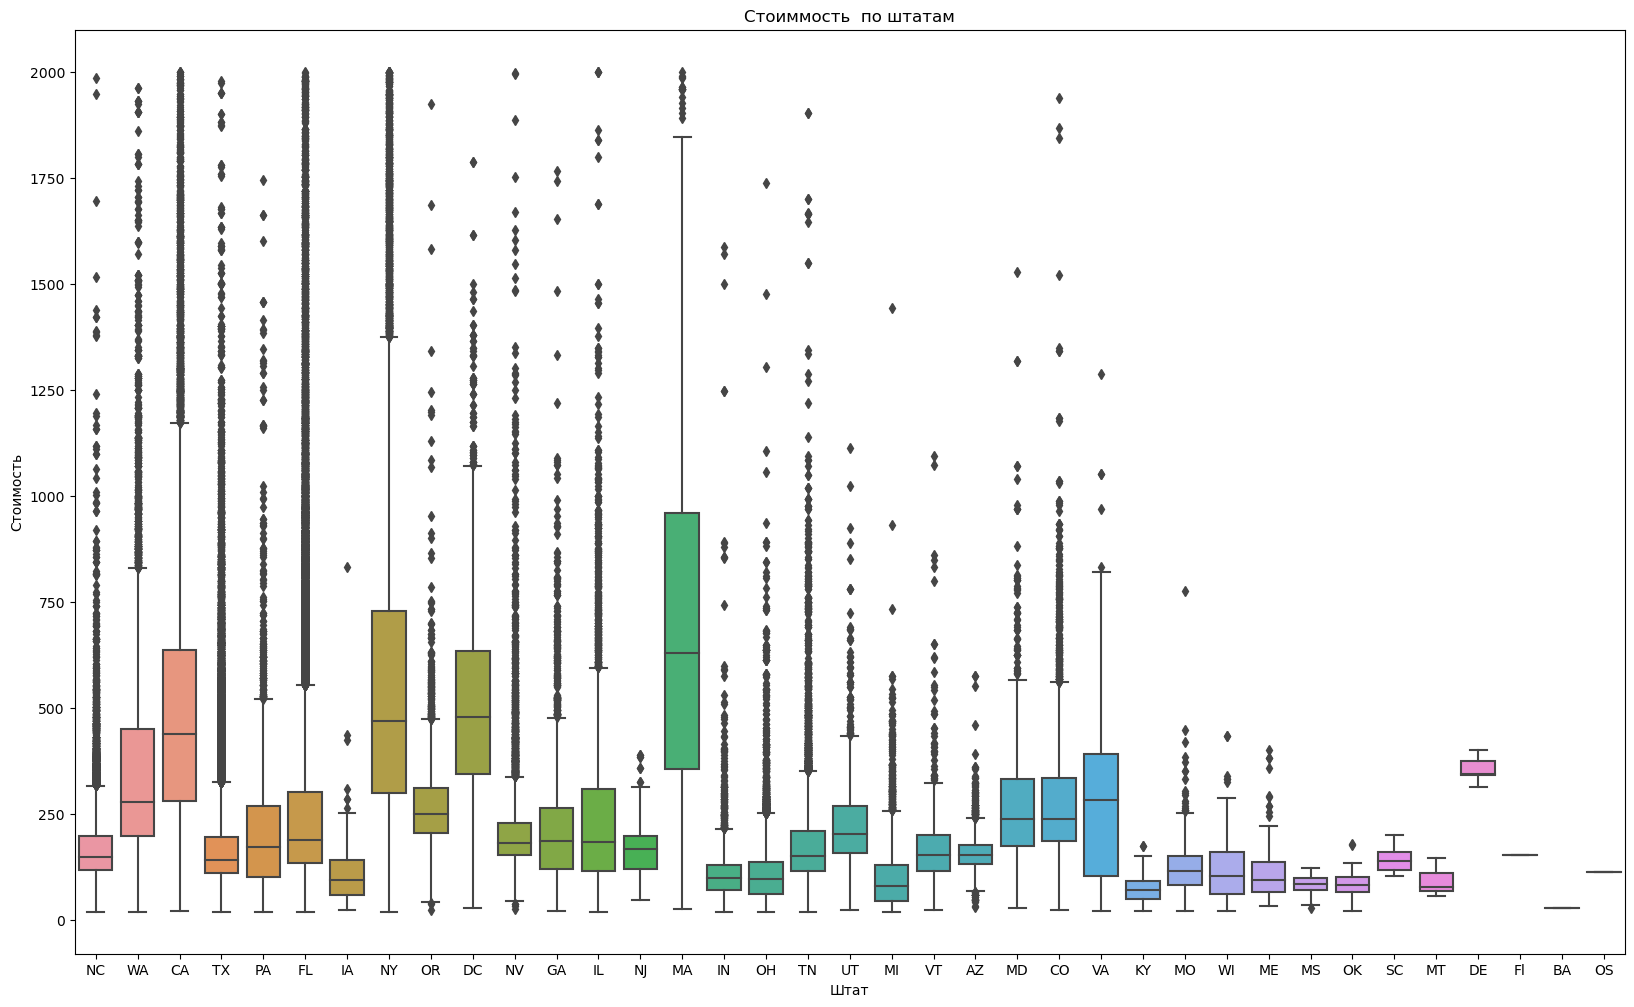

In [77]:
# как распределяется признак по штатам

plt.figure(figsize=(20, 12))  
sns.boxplot(x='state', y='target_per_sqft', data=df_per_sqft)
plt.xlabel('Штат')
plt.ylabel('Стоимость')
plt.title('Стоиммость  по штатам')
plt.show()

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

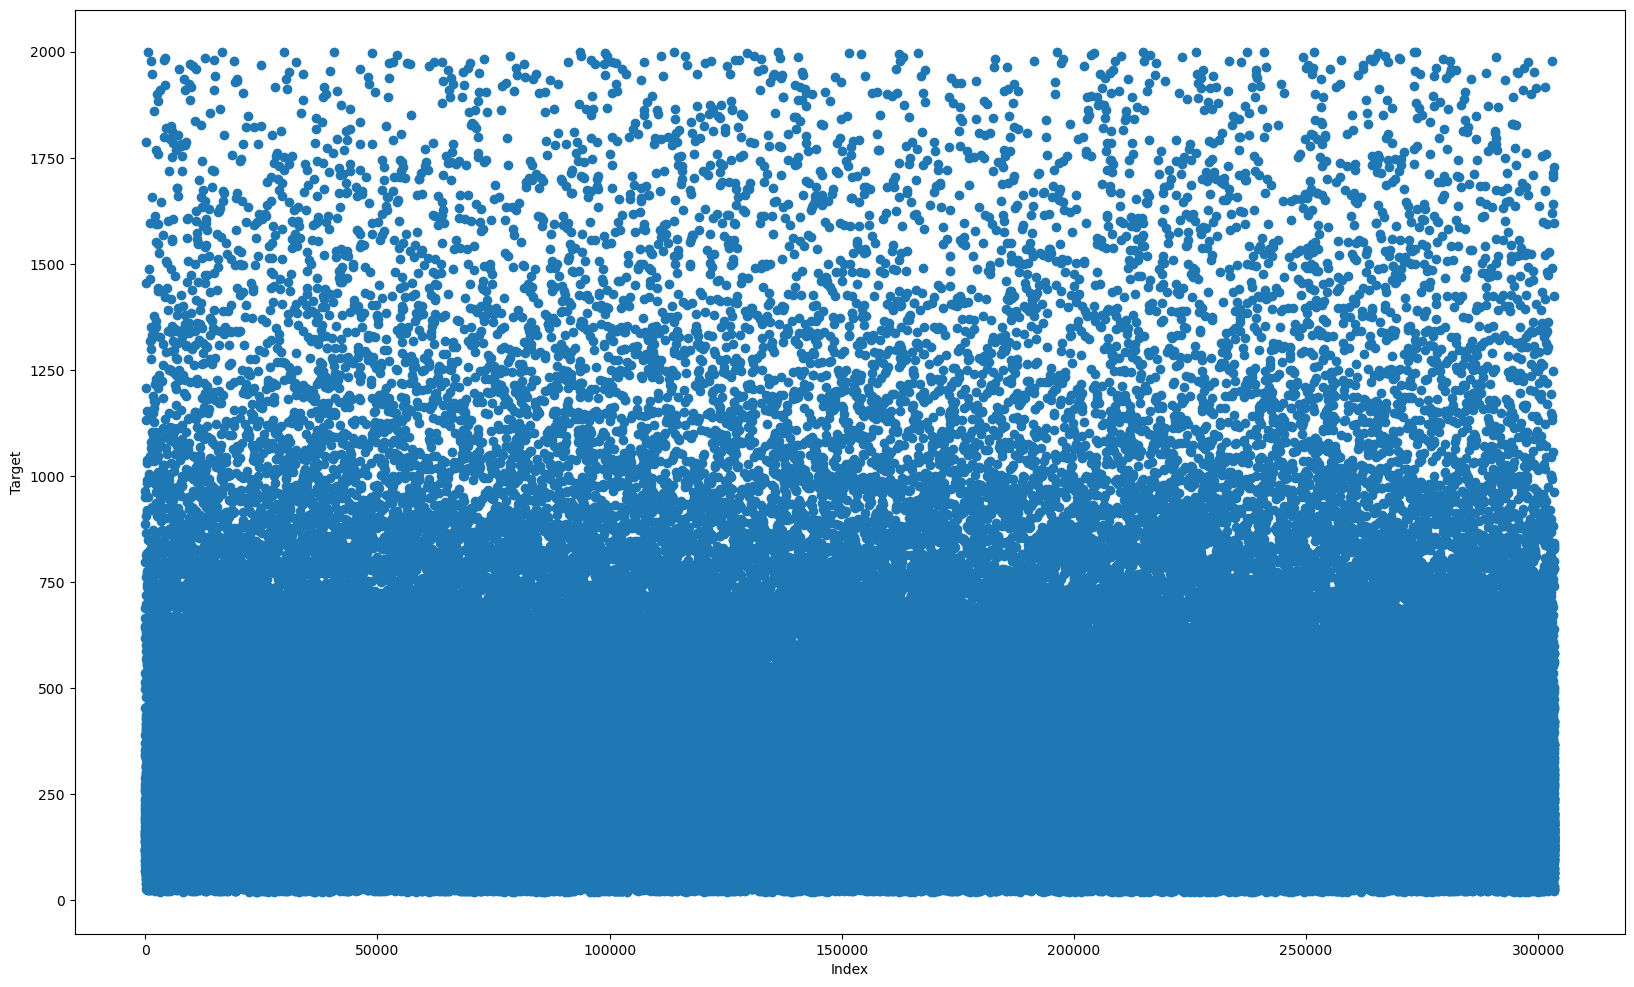

In [78]:
# посмотрим как визуально отражаются точки

plt.figure(figsize=(20, 12))
plt.scatter(range(len(df_per_sqft['target_per_sqft'])), df_per_sqft['target_per_sqft'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.title

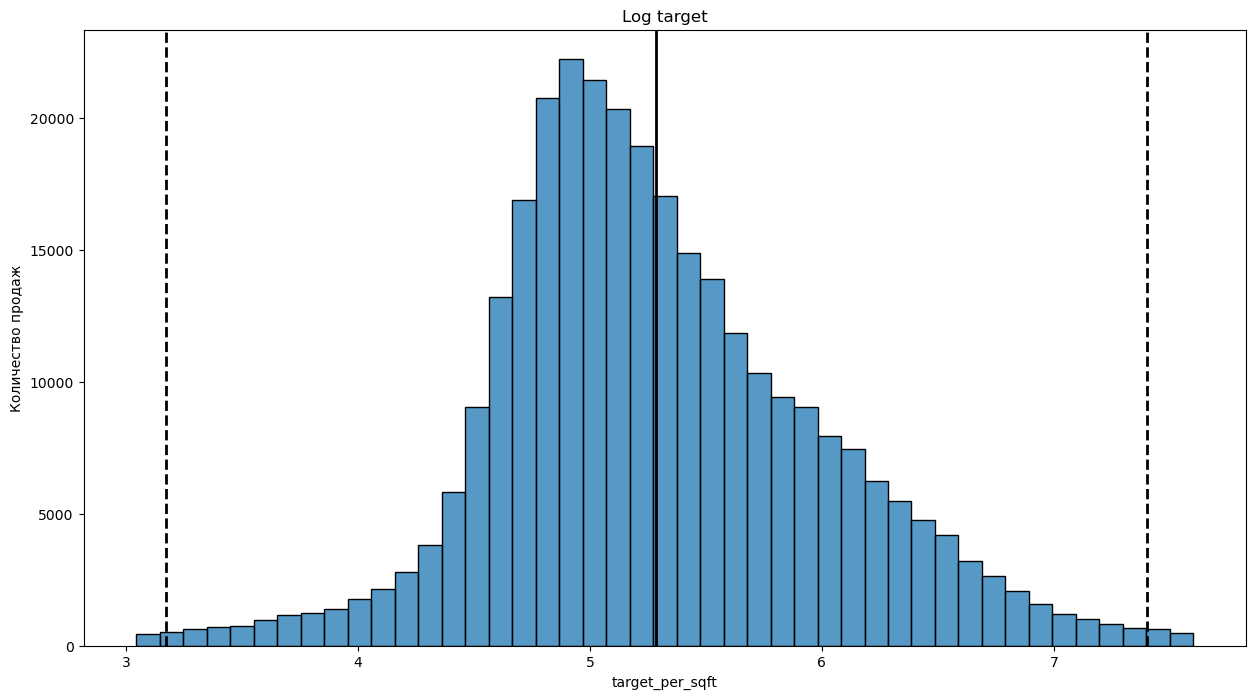

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
log_target = np.log(df_per_sqft['target_per_sqft'] +1)
histplot = sns.histplot(log_target, bins=45, ax=ax)
histplot.axvline(log_target.mean(), color='k', lw=2)
histplot.axvline(log_target.mean()+ 3 * log_target.std(), color='k', ls='--', lw=2)
histplot.axvline(log_target.mean()- 3 * log_target.std(), color='k', ls='--', lw=2)
histplot.set_ylabel('Количество продаж')
histplot.set_title('Log target');

## Посмотрим на признак <span style="color:blue"> 'sqft'.</span>

Мы знаем, что у нас большая взаимосвязь между площадью и стоимостью. В площади так же могут быть выбросы. Посмотрим на эту взаимосвязь в разрезе этих двух признаков. 

In [80]:
# минимальная и максимальная площадь в датасете
df_per_sqft['sqft'].min(), df_per_sqft['sqft'].max()

(12.0, 600613.0)

Конечно, можно создать новый признак и перевести футы в метры, т.к нам более понятна метрическая система, но при этом возникнут округления, а я хочу оставить значения в признаке как они есть изначально, поэтому сделаем небольшой калькулятор. 

In [81]:
# создадим калькулятор для перевода футы в метры
def convert_sqft_to_sqm(sqft):
    sqm = sqft * 0.092903  # Формула для перевода квадратных футов в квадратные метры
    return sqm


# Получаем ввод пользователя
# sqft_input = float(input("Введите площадь в квадратных футах: "))

# Вызываем функцию для перевода квадратных футов в квадратные метры
# sqm_output = convert_sqft_to_sqm(sqft_input)

# Выводим результат
# print("Площадь в квадратных метрах:", sqm_output)

100 футов - это примерно 9 метров. Я знаю, что, например в Питере сдаются аппартаменты площадью 20 метров квадратный. Но они очень маленькие. Соответственно, общая площадь менее 10 квадратных метров, сложно назвать жилой. Посмотрим сколько у нас таких объектов. 100 квадратных футов это около 9 квадратных метров. 

In [82]:
# количество объектов площадью менее 100 квадратных фута или 9 метров по признаку sqft
df_tiny_sqft = df_per_sqft[df_per_sqft['sqft'] < 100 ]
len(df_tiny_sqft)

11

In [83]:
# количество объектов площадью менее 100 квадратных фута или 9 метров по признаку lotsize
df_tiny_lotsize = df_per_sqft[df_per_sqft['lotsize'] < 100 ]
len(df_tiny_lotsize)

272

У нас два признака с площадью и мы видим, что в признаке, который мы достали из словаря, таких объектов больше, скорее всего это ошибки. Удалим эти 11 объектов, т.к нам даже не с чем их сравнивать. Конечно, я посмотрела эти 11 объектов, и в части из них, возможно, просто перепутаны местами данные из словаря и датасета, но мы не можем это утверждать. 

In [84]:
# удалим объекты менее 100 квадратных футов
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['sqft'] < 100].index)

Создадим новый признак где сгруппируем площади. Например, до 45 метров это у нас 1-2 комнатная маленькая квартира или домик. 45-120 - двух-трех комнатная квартира или дом побольше, 120 -250 это уже довольно большая кватрира тлт дом, 250 - 500 это уже большой дом, более 500 элитная недвижимость. 

In [85]:
# создадим агрегирующую функцию
def get_sqft(sqft_score):
    if sqft_score >= 12 and sqft_score < 500:   # небольшая 1-2 комнатная квартира до 45 метров
        return "tiny"
    elif sqft_score >= 500 and sqft_score < 1300:   # двух или трех комнатная квартира или дом больше до 120 метров
        return "little"
    elif sqft_score >= 1300 and  sqft_score < 2700: # двух или трех комнатная квартира или дом больше до 250 метров
        return "average"
    elif sqft_score >= 2700 and sqft_score < 5400:   # квартира или дом до 500 метров
        return "average+"
    elif sqft_score >= 5400 and sqft_score < 11000:  #до 1000 кв метров
        return "big"
    elif sqft_score >= 11000 and sqft_score < 22000:   #до 2000 квадратных метров
        return "big+"
    elif sqft_score >= 22000 and sqft_score < 33000:   #до 3000 кавдратных метров
        return "huge"
    elif sqft_score >= 33000:
        return "super huge"

Text(0.5, 1.0, 'Зависимость средней стоимости квадратного метра от площади по штатам')

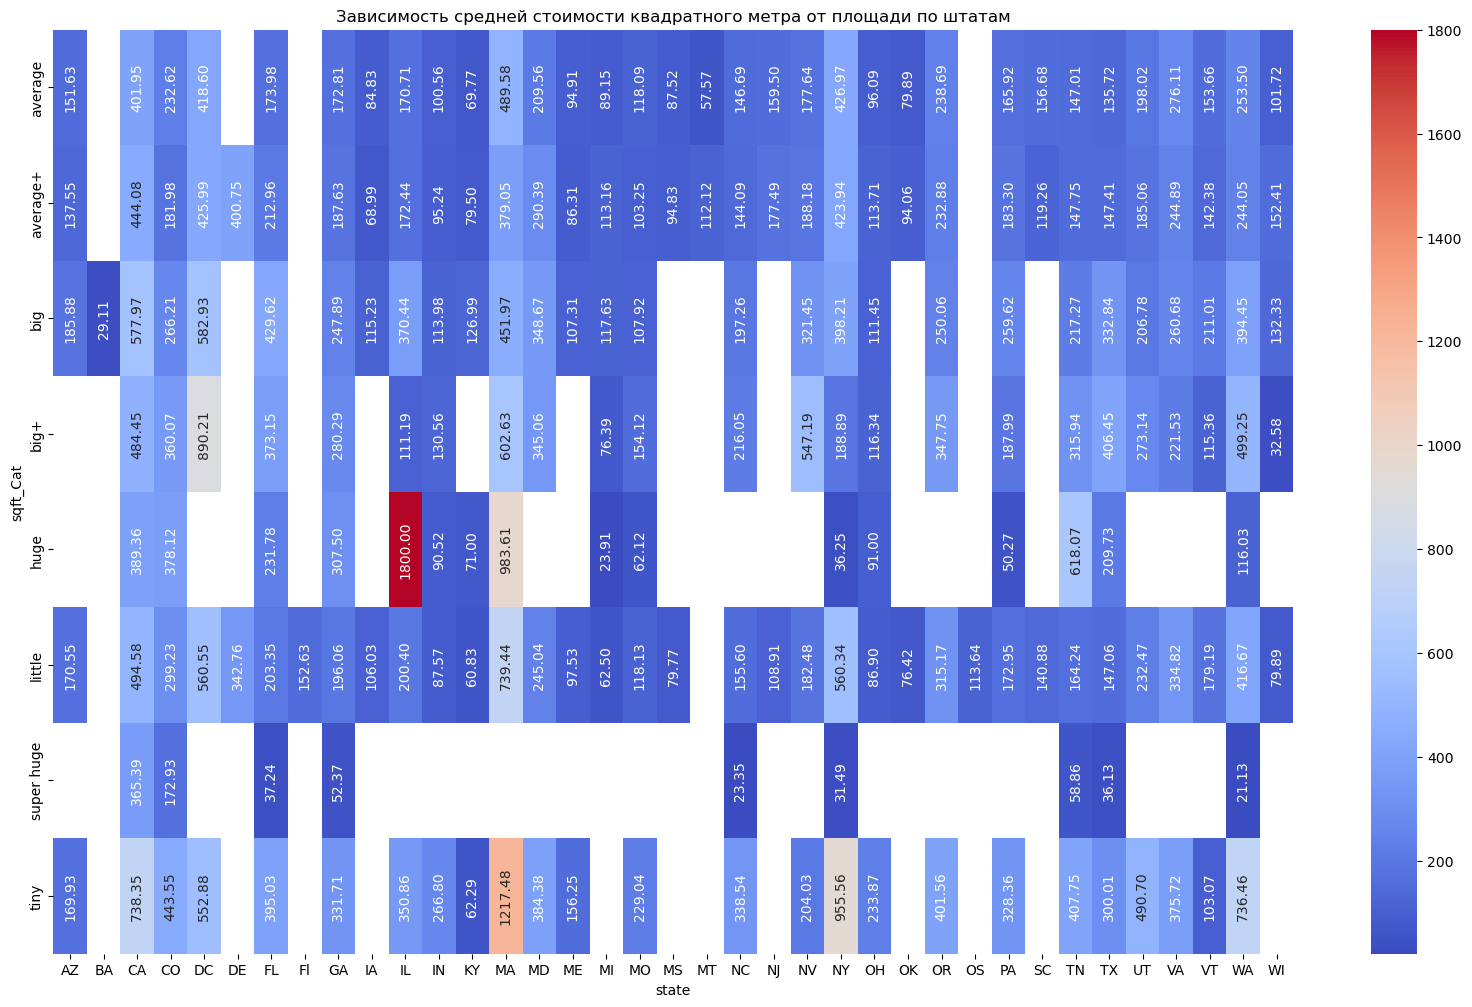

In [86]:
# создадим новый признак
df_per_sqft['sqft_Cat'] = df_per_sqft['sqft'].apply(get_sqft)
# визуализируем
pivot_heat = df_per_sqft.pivot_table(
    values='target_per_sqft',
    index='sqft_Cat',
    columns='state',
    aggfunc='median'  
)
fig = plt.figure(figsize=(20, 12))
ax = sns.heatmap(data=pivot_heat, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={'rotation': 90})
ax.set_title('Зависимость средней стоимости квадратного метра от площади по штатам')

Вот такая получилась красивая тепловая карта. Она показывает медианную стоимость объекта по каждому штату, в соответствии с нашей разбивкой по размеру недвижимости. Медиану я выбрала из-за очень большого разброса по стоимости с перекосом в большую сторону. Итак, мы видим, что цвета идут от синего к светлоголубому. Т.е темносинийсиний - минимальная стоимость, потом то, что укладывается в наши рамки средней и медианы. Ну и желтое и красное - это то, что выделяется очень сильно. 

In [87]:
# посмотрим на максимальную, минимальную и медианную стоимость по признаку
grouped_data_sqft_cat = df_per_sqft.groupby('sqft_Cat')['target_per_sqft'].agg(['max', 'min', 'mean', 'median']).round()
grouped_data_sqft_cat

,max,min,mean,median
sqft_Cat,,,,
average,2000.0,20.0,226.0,165.0
average+,2000.0,20.0,258.0,179.0
big,2000.0,20.0,426.0,325.0
big+,1960.0,20.0,479.0,352.0
huge,1800.0,20.0,343.0,186.0
little,1996.0,20.0,296.0,213.0
super huge,1386.0,20.0,111.0,35.0
tiny,1998.0,23.0,581.0,482.0


In [88]:
# сгруппируем и посмотрим насколько у нас различается максимальная, минимальная и медианная стоимость по штатам
# grouped_data_state = df_per_sqft.groupby('state')['target_per_sqft'].agg(['max', 'min', 'median']).round()
# grouped_data_state

Из тепловой карты мы видим не совсем корректные значения, это все что отмечено светло синим цветом и красным цветом это штаты в которых наиболее сильные выбросы по соотношению площадь и стоимость. Так же я увидела, что есть штат FL и Fl, так же нет штата ВА, OS тоже непонятно что это за штат.

In [89]:
# посмотрим на Fl
# df_per_sqft[df_per_sqft['state'] == 'Fl']

Итак Тамарак - это город в штате Флорида https://wiki5.ru/wiki/Tamarac,_Florida

In [90]:
# подставим новое значение в элемент с индексом 235207
index = 113694
new_value = 'FL'

if index in df_per_sqft.index:
    df_per_sqft.at[index, 'state'] = new_value
else:
    new_row = pd.Series({'state': new_value}, name=index)
    df_per_sqft = df_per_sqft.append(new_row)

In [91]:
# посмотрим на OS
df_per_sqft[df_per_sqft['state'] == 'OS']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,beds,state,stories,mls-id,PrivatePool,MlsId,target,lotsize,target_per_sqft,sqft_Cat
308229,Active,NaN,NaN,435 pescador,NaN,"{'atAGlanceFacts': [{'factValue': '1972', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': '$114 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}",NaN,Foreign Country,"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]",1100.0,...,NaN,OS,NaN,NaN,NaN,CV18033361,125000.0,NaN,113.636364,little


Видим, что это вообще какая-то другая страна

In [92]:
# посмотрим на BA
df_per_sqft[df_per_sqft['state'] == 'BA']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,beds,state,stories,mls-id,PrivatePool,MlsId,target,lotsize,target_per_sqft,sqft_Cat
172273,Active,NaN,NaN,"Mar Grande SE Quadra A, Lotes 9,10, 11 & 12",NaN,"{'atAGlanceFacts': [{'factValue': '1900', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': '$29 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}",NaN,,"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]",7728.0,...,NaN,BA,NaN,NaN,NaN,F10188545,225000.0,NaN,29.114907,big


По индексу понятно, что это Майами, но для Майами, такая стоимость - выброс. Стоимость квадратного метра такого участка около 300$.
В общем BA и OS - это ошибки. Удалим их. 

In [93]:
# удалим элемент 308229
index_to_drop = 308229
df_per_sqft = df_per_sqft.drop(index_to_drop)

In [94]:
# удалим элемент 172273
index_to_drop = 172273
df_per_sqft = df_per_sqft.drop(index_to_drop)

In [95]:
# df_nc_tiny = df_per_sqft[(df_per_sqft['state'] == 'NC') & (df_per_sqft['sqft_Cat'] == 'tiny')]
# df_nc_tiny

In [96]:
# df_nc_huge = df_per_sqft[(df_per_sqft['state'] == 'NC') & (df_per_sqft['sqft_Cat'] == 'super huge')]
# df_nc_huge

In [97]:
# df_tx = df_per_sqft[(df_per_sqft['state'] == 'TX') & (df_per_sqft['sqft_Cat'] == 'tiny')]
# df_tx

In [98]:
# df_ma = df_per_sqft[(df_per_sqft['state'] == 'MA') & (df_per_sqft['sqft_Cat'] == 'little')]
# df_ma

Вывод: 
- Я склоняюсь к тому, что правильно выбрала целевой признак. Выше я закомментила группировки, как посмотреть вручную самые выделяющиеся данные. Пока не буду дальше очищать данные. У нас есть большое количество признаков с пропусками. Посмотрим, что можно восстановить и насколько эти признаки информативные и будем от этого отталкиваться при дальнейшей очистке и обработке. 
- Есть большое количество выбросов по штатам. Их обработаем после обработки признаков, т.к датасет станет более компактным и понятным и будет легче делать выводы. 
- Ошибки будем исправлять по мере обработки признаков, возможно, такие как штаьт OS удалятся при обработке. 

### Функции для обработки данных 

In [99]:
# Преобразовываем значение в признаке с большим количеством разных слов

def replace_values(data, feature, values_list, replacement):
    """Заменяет значения в признаке, совпадающие со значениями из списка, на указанное заменительное значение.

    Параметры:
        data (pandas.DataFrame): DataFrame, в котором находится признак для замены значений.
        feature (str): Название признака (столбца), значения которого нужно заменить.
        values_list (list): Список значений, с которыми нужно сравнивать значения признака.
        replacement (any): Значение, на которое нужно заменить совпадающие значения.

    Возвращает:
        pandas.DataFrame: DataFrame с замененными значениями в указанном признаке."""
    data[feature] = data[feature].apply(lambda x: replacement if x in values_list else x)
    return data

  

In [100]:
# Ищем только одно значение в строке и заменяем его 

def replase_word(value, word, replacement):
    """Заменяет значения в признаке, совпадающие со значением поданным в функцию, на указанное заменительное значение.

    Параметры:
        value: поданные значения в признаке
        word (str): слово, которое нужно найти в значении признака 
        replacement (any): Значение, на которое нужно заменить совпадающие значения.

    Возвращает:
        измененное значение"""
    if isinstance(value, str) and word in value.lower():
        return replacement
    else:
        return value

### 1. Преобразуем признак <span style="color:blue"> 'status'.</span>


В этом признаке я сгруппировала данные по след значениям:
- For sale - продается
- New construction - новая конструкция
- Pending - на стадии заключения договора
- Other - прочие
- Contingent - на стадии заключения договора, покупатель выполняет условия
- Coming soon - скоро будут выставлены на продаджу

In [101]:
# Посмотрим какие и сколько значений содержит признак
unique_status = df_per_sqft['status'].unique()
#print(unique_status)
print(len(unique_status))

143


#### 1. Все слова содержащие 'foreclosure', относим к одному статусу 'Foreclosure', т.к это проблемные квартиры с обременением.

In [102]:
# Создаем список
list_foreclosure = ['foreclosure', 'Pre-Foreclosure', 'ForeclosureAuction', 
                    'Foreclosed', 'Contingent   Foreclosure', 
                    'Pre-foreclosure', 'Foreclosed', 'Pre-foreclosureAuction']

In [103]:
# Применяем функцию replace_values
df_per_sqft = replace_values(df_per_sqft, 'status', list_foreclosure, 'Foreclosure')

#### 2. Фактически вся группа Pending - это квартиры на стадии заключения договора, но те которые продолжают показавать. Выделим их в группу Pending. Так же сюда подходят 'Option Contract' и 'Active Option Contract'. Т.к судя по открытым источникам, это так же олбъекты на стадии договора, но которые еще показываются. 

In [104]:
# Применяем функцию replase_word
df_per_sqft['status'] = df_per_sqft['status'].apply(replase_word, word='pending', replacement='Pending')

In [105]:
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Option Contract', 'Pending')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Active Option Contract', 'Pending')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Active Pending', 'Pending')

#### 3. Все объекты к сдаче Coming soon - объединяем в одну группу

In [106]:
# Применяем функцию replase_word   
df_per_sqft['status'] = df_per_sqft['status'].apply(replase_word, word='coming soon', replacement='Coming soon')

### 4. Группа объектов For sale - самая большая. Содержит слова в разных регистрах, с различными агентскими примечаниями. Так же есть группа значений - 'under contract showing', 'under contract show', 'undercontract', 'active under contract', 'under contract backups', 'active backup', 'backup contract', 'active' - их так же объединяем в For sale, т.к фактически, договора еще нет, он готовится и продажа активна. Так же в For sale добавляем, те которые подходят по смыслу. 

In [107]:
# Создаем список
list_for_sale = ['for sale', 'For Sale', 'Active', 'For sale/Contingent', 'Under Contract   Showing', 
                 'Under Contract', 'Under Contract Backups', 'For sale Under Contract', 'Under Contract Show', 
                 'A For sale', 'For sale Option', 'For sale For sale', 'For sale Show', 'For sale - No Show', 
                 'For sale - Contingent', 'For sale with Contract', 'For sale Backups', 'For sale Contract',
                 'For sale - Show', 'For sale Backup',  'For sale W/ Bckp', 'Temporary For sale', 'C Continue Show',
                 'U For sale', 'For sale With Offer', 'For sale Taking Back Up Offers', 'Back on Market', 'Uc Continue To Show',
                 'Active Under Contract', 'Under Contract - Show', 'Active With Offer', 'Active Backup', 'A Active',
                 'Price Change', 'Active Option', 'Contract P', 'Backup', 'Conting Accpt Backups', 'Conditional Contract ', 'Contract',
                 'Backup Contract', 'Under contract', 'Under Contract - No Show', 'U Under Contract', 
                 'Conditional Contract', 'Active with Contract', 'Accepting backups', 'Under Contract W/ Bckp', 'Under Contract Taking Back Up Offers',
                 'Listing Extended']

In [108]:
# Применяем функцию replace_values
df_per_sqft = replace_values(df_per_sqft, 'status', list_for_sale, 'For sale')

#### 5. Группа Contingent - вот информация из открытых источников 'Условная продажа дома происходит, когда продавец принимает предложение о продаже дома, но решает оставить объявление активным на случай, если потенциальный покупатель не выполнит определенные условия'. По сути - это активная продажа. Но пока выделим ее в отдельную группу. 

In [109]:
# Применяем функцию replase_word   
df_per_sqft['status'] = df_per_sqft['status'].apply(replase_word, word='contingent', replacement='Contingent')

In [110]:
# Часть в функцию не попадает, меняем по значению
df_per_sqft['status'] = df_per_sqft['status'].str.replace('For sale Contingency', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Contingency 48 Hr (+/ )', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Contingency Contract', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('CT Insp - Inspection Contingenc', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('For sale With Contingencies', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Active With Contingencies', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Active Contingency', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Contingenty', 'Contingent')
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Due Diligence Period', 'Contingent')


#### 6. Выделяем группу квартир в аренду For rent

In [111]:
# Применяем функцию replase_word   
df_per_sqft['status'] = df_per_sqft['status'].apply(replase_word, word='for rent', replacement='For rent')

#### 7. Выделяем квартиры, которые продаются с аукциона. Auction

In [112]:
# Применяем функцию replase_word   
df_per_sqft['status'] = df_per_sqft['status'].apply(replase_word, word='auction', replacement='Auction')

#### 8. Выделяем только постороенные дома. New construction

In [113]:
# Применяем функцию replase_word   
df_per_sqft['status'] = df_per_sqft['status'].apply(replase_word, word='new', replacement='New construction')

#### 9. Сделка закрыта, но квартиры еще в базе. Closed

In [114]:
df_per_sqft['status'] = df_per_sqft['status'].str.replace('recently sold', 'Closed')

#### 10. Так же у нас есть значения, которые для нас выглядят бессмысленно т.к состоят из одной или двух букв. Так же включим сюда значеня, которых до 10 в таблице. Обозначим их как Other

In [115]:
# создаем список
list_other = ['P', 'Pf', 'C', 'Pi', 'Ct', 'Ps', 'Sold: $285,000', 'Sold: $15,000', 'Back On Market', 'Accepted Offer',
              'Re Activated', 'Temporary Active', 'Lease/Purchase', 'Reactivated']

In [116]:
# Применяем функцию replace_values
df_per_sqft = replace_values(df_per_sqft, 'status', list_other, 'Other')

In [117]:
# Смотрим как выглядит признак после обработки
df_per_sqft['status'].value_counts()

status
For sale            256632
New construction      5570
Pending               4733
Foreclosure           4062
Other                 1544
Contingent             954
Coming soon            107
Auction                 43
Closed                   4
Name: count, dtype: int64

Мы видим, что у нас практически не осталось значений в группах For rent и Closed, хотя при первичных обработках данных эти группы содержали значительное количество данных. Думаю, можно удалить их, т.к мы предсказываем стоимость продажи и закрытые сделки, видимо, просто не попали в выбросы. 
Так же Foreclosure и Auction это некая проблемная группа недвижимости. Объединим ее.  

In [118]:
# удаляем 'For rent' и 'Closed'
df_per_sqft = df_per_sqft.drop(df_per_sqft[(df_per_sqft['status'] == 'For rent') | (df_per_sqft['status'] == 'Closed')].index)

In [119]:
# объединяем 'Auction' и 'Foreclosure'
df_per_sqft['status'] = df_per_sqft['status'].str.replace('Auction', 'Foreclosure')

Итак, у нас остались следующие уникальные группы:
- For sale - продается
- New construction - новая конструкция
- Pending - на стадии заключения договора
- Other - прочие
- Contingent - на стадии заключения договора, покупатель выполняет условия
- Coming soon - скоро будут выставлены на продаджу

Так же у нас осталось много пропущенных значений в признаке. Справочно посмотрим в каких городах этих значений пропущенно больше. 

In [120]:
# Пропущенные значения в признаке
df_per_sqft['status'].isnull().sum()

29794

### 2. Преобразуем признак <span style="color:blue"> 'propertyType'.</span>

Что сделано: 
- выделены следующие группы SingleFamiily, Condo, Townhouse, MultiFamily, Traditional, Contemporary, Manufactured, Land, Ranch, Coop, Highlevel, UniqueHouse , Colonial, Other, Florida, Transitional, Mediterranean, Log, SplitLevel, Cluster, Euro, Modern, Camp, Penthouse. Поскольку они выделялись, по примечаниям внесенным агентам.  
- Внимание, этот пункт я сделала уже после того как обработала все данные. Просто увидела, что такая сложная разбивка не имеет смысла. Т.к часть признаков - это не тип жилья, а скорее архитектурная особенность, то те группы, в которых меньше 2000 значений, я объединю в 'UniqueHouse' Это: Colonial, Other, Florida, Transitional, Mediterranean, Log, SplitLevel, Cluster, Euro, Modern, Camp, Penthouse.      

In [121]:
# посмотрим на признак
list_property_type = df_per_sqft['propertyType'].unique()
print(list_property_type)
print(len(list_property_type))

['Single Family Home' 'single-family home' 'townhouse' ...
 'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam'
 'Lake House, Single Detached, Tudor'
 'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit']
1243


При первичном анализе признака мы видим, что у нас очень большое количество значений, которые обозначают не тип дома, а количество этажей. Например: '1 Story', '2 Stories. При обработке данных мы потеряем эту информацию. Создадим временный признак, копированием признака 'propertyType' чтобы переносить туда информацию об этажах. Возможно, это позволит заполнить пропущенные значения в признаке 'Stories'

In [122]:
# скопируем, т.к признак содержит еще данные об этажности
df_per_sqft['temp_propertyType'] = df_per_sqft['propertyType'].copy()

В данном признаке постараемся собрать только тип постройки, дома. Которые делают его уникальным и возможно могут влиять на цену. 

In [123]:
# Посмотрим как у нас первично распределяются типы недвижимости
df_per_sqft['propertyType'].value_counts()

propertyType
single-family home                                             87939
Single Family                                                  52413
Single Family Home                                             31023
condo                                                          24366
Condo                                                          14812
                                                               ...  
Cabin, Cottage/Camp                                                1
1 Story, Split Level, Mediterranean                                1
3+ Stories, Split Level, Contemporary, Ranch                       1
Lake House                                                         1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: count, Length: 1242, dtype: int64

Итак, основные три типа это Single Family Home - отдельностоящий небольшой дом, Condo - кондиминиум и Land - замля.

Так же мы видим, что в данных много мусора в виде запятых, слэшей, дефисов, которые могут затруднять работу с данными. Заменим их на пробелы. И приведем строку к нижнему регистру

In [124]:
# удалим знаки 
list_symbol = [',', '-', '/', '+']
for value in list_symbol:
    df_per_sqft['propertyType'] = df_per_sqft['propertyType'].str.replace(value, ' ').str.lower()

#### 1. Кондоминиум - это верхний или нижний этаж частного дома. Можно купить. Обозначим Condo.

In [125]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='condo', replacement='Condo')

#### 2. Single-family (detached, tiny home) — односемейный (отдельный,маленький) дом.

In [126]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='single', replacement='SingleFamiily')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='one', replacement='SingleFamiily')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='1', replacement='SingleFamiily')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='two', replacement='SingleFamiily')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='2', replacement='SingleFamiily')

#### 3. Земля. Land

In [127]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='land', replacement='Land')

#### 4. Таунхауз

In [128]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='townhouse', replacement='Townhouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='duplex', replacement='Townhouse')

#### 5. Многокварирный дом. Multi family.

In [129]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='multi', replacement='MultiFamily')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='flat', replacement='MultiFamily')

#### 6. Апартаменты. Это важный тип, т.к эти квартиры сдаются в аренду а не покупаются.

In [130]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='apartment', replacement='Apartment')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='rent', replacement='Apartment')

#### 7. Производственное здание. Manufactured 

In [131]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='manufactured', replacement='Manufactured')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='mfd', replacement='Manufactured')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='warehouse', replacement='Manufactured')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='garage', replacement='Manufactured')

#### 8. Кооператив. Coop 

In [132]:
list_coop = ['coop', 'cooperative', 'co op']

In [133]:
# Применяем функцию replace_values
df_per_sqft = replace_values(df_per_sqft, 'propertyType', list_coop, 'Coop')

#### 9. Ранчо и фермы. Runch

In [134]:
# Применяем функцию replase_word   
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='ranch', replacement='Ranch')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='farm', replacement='Ranch')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='garden', replacement='Ranch')


#### 10. Многоэтажный дом. HighLevel

In [135]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='high', replacement='Highlevel')

#### 11. Современный. Contemporary

In [136]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='contemporary', replacement='Contemporary')

#### 12. Традиционный. Traditional

In [137]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='traditional', replacement='Traditional')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='conventional', replacement='Traditional')



#### 13. Колониальный. Сolonial

In [138]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='colonial', replacement='Colonial')

#### 14. Пентхаус. Penthouse

In [139]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='penthouse', replacement='Penthouse')

#### 15. Florida. Довольно часто встречайщееся название. Пока выделю в отдельную группу. 

In [140]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='florida', replacement='Florida')

#### 16. Двухуровневые. SplitLevel

In [141]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='split', replacement='SplitLevel')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='bi', replacement='SplitLevel')

#### 17. Средиземноморский. Mediterranean

In [142]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='mediterranean', replacement='Mediterranean')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='spanish', replacement='Mediterranean')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='tuscan', replacement='Mediterranean')

#### 18. Европейский. Euro

In [143]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='french', replacement='Euro')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='european', replacement='Euro')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='english', replacement='Euro')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='dutch', replacement='Euro')

#### 19. Модерн. Modern

In [144]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='modern', replacement='Modern')

#### 20. Transitional

In [145]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='transitional', replacement='Transitional')

#### 21. Коттеджный поселок. Camp

In [146]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='camp', replacement='Camp')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='cottage', replacement='Camp')

#### 22. Гостевой. Cluster 

In [147]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='cluster', replacement='Cluster')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='guest', replacement='Cluster')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='custom', replacement='Cluster')

#### 23. Деревянный. Log

In [148]:
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='log', replacement='Log')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='craftsman', replacement='Log')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='arts', replacement='Log')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='carriage', replacement='Log')

#### 24. Постараемся выделить уникальные дома в одну группу. UniqueHouse

In [149]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='tudor', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='loft', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='cape', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='victorian', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='resort', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='bungalow', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='3', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='4', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='old', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='tri', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='deco', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='beach', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='charleston', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='historical', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='georgian', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='historic', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='villa', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='patio', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='chalet', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='fourplex', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='quad', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='key', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='lake', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='stilt', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='coastal', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='queen', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='mid', replacement='UniqueHouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='store', replacement='UniqueHouse')



#### 25. Прочие. Other

In [150]:
# Применяем функцию replase_word 
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='other', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='yes', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='unknown', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='houseboat', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='frame', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='detached', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='federal', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='studio', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='attached', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='rise', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='miscellaneous', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='bermuda', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='straight', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='units', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='texas', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='elevated', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='santa', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='courtyard', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='gambrel', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='rustic', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='side', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='airlite', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='townhome', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='back', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='architectural', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='unit', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='area', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='square', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='post', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='hill', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='manor', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='rehab', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='fairway', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='moorage', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='prairie', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word=' ', replacement='Other')

Итак, мы выделили основные встречающиеся типы домов мы снизили с 1200 до 25, но данный признак еще будет обрабатываться. т.к значений все равно много. 

In [151]:
df_per_sqft['propertyType'].value_counts()

propertyType
SingleFamiily    181789
Condo             47945
Townhouse         17797
MultiFamily       10211
Traditional        6376
Contemporary       3246
Manufactured       3109
Land               2880
Ranch              2852
Coop               2403
Highlevel          1735
UniqueHouse        1455
Colonial           1085
Other              1034
Apartment           694
Florida             632
Transitional        586
Mediterranean       565
Log                 294
SplitLevel          280
Cluster             266
Euro                135
Modern              111
Camp                 72
Penthouse            68
Name: count, dtype: int64

Из Брифа учебного проекта мы знаем, что Apartment - это квартиры для аренды их нельзя купить. Поскольку мы обучаем модель предсказывать стоимость покупки жилья, а не аренды, то считаю, что эти значения нужно удалить. Их 694

In [152]:
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['propertyType'] == 'Apartment'].index)

In [153]:
df_per_sqft['propertyType'].value_counts()

propertyType
SingleFamiily    181789
Condo             47945
Townhouse         17797
MultiFamily       10211
Traditional        6376
Contemporary       3246
Manufactured       3109
Land               2880
Ranch              2852
Coop               2403
Highlevel          1735
UniqueHouse        1455
Colonial           1085
Other              1034
Florida             632
Transitional        586
Mediterranean       565
Log                 294
SplitLevel          280
Cluster             266
Euro                135
Modern              111
Camp                 72
Penthouse            68
Name: count, dtype: int64

In [154]:
# создаем список из значений, которые имеют отношение к архитектуре, а не типу
list_of_property = ['Colonial', 'Other', 'Florida', 'Transitional', 'Mediterranean', 'Log', 'SplitLevel', 'Cluster', 'Euro', 'Modern', 'Camp', 'Penthouse']
# Применяем функцию replace_values
df_per_sqft = replace_values(df_per_sqft, 'propertyType', list_of_property, 'UniqueHouse')

In [155]:
df_per_sqft['propertyType'].value_counts()

propertyType
SingleFamiily    181789
Condo             47945
Townhouse         17797
MultiFamily       10211
UniqueHouse        6583
Traditional        6376
Contemporary       3246
Manufactured       3109
Land               2880
Ranch              2852
Coop               2403
Highlevel          1735
Name: count, dtype: int64

### 3.Признак <span style="color:blue"> 'City'.</span>

Я не считаю, что этот признак очень информативный, т.к у нас есть разбивка по зипкодам и штатам, но поскольку признак содержит мало пропусков, на этом этапе мы его восстановим. Т.к на него легче ориентироваться, при визуальном  анализе, чем на индекс, например. И он не утяжеляет датасет. 

In [156]:
df_per_sqft['city'].value_counts()

city
Houston            21423
San Antonio        13898
Miami              12905
Jacksonville        8076
Dallas              7842
                   ...  
Pierce Township        1
Suwannee               1
FORT COLLINS           1
Rowan                  1
Blue Springs           1
Name: count, Length: 1816, dtype: int64

In [157]:
# количество пропусков
df_per_sqft['city'].isnull().sum()

4

Итак, у нас 1825 город. 4 пропуска. Попробуем заполнить недостающие значения по признаку 'zipcode'

In [158]:
# заполним недостающие значения city на основании признака 'zipcode'
df_per_sqft['city'] = df_per_sqft.groupby('zipcode')['city'].fillna(method='bfill')

In [159]:
#df_per_sqft['city'].value_counts().head(30)

In [160]:
#df_per_sqft['city'].isnull().sum()

In [161]:
# распределение количества городов по штатам
city_counts = df_per_sqft.groupby('state')['city'].agg('count').sort_values(ascending=False)
city_counts

state
FL    89809
TX    72856
CA    19878
NC    17373
NY    14558
TN    13940
WA    11720
OH    10099
NV     7499
IL     6548
CO     5728
GA     5554
PA     4746
DC     4099
MI     3440
AZ     3138
IN     2685
OR     2539
MA     1267
UT     1137
MD     1026
MO      719
VA      652
VT      647
WI      376
NJ      230
IA      197
ME      131
KY       63
OK       30
SC       27
MS       26
DE        5
MT        3
Name: city, dtype: int64

### 4. Признак <span style="color:blue"> 'baths'.</span>

Как и все признаки заполнен он как придется. Почистим признак, уберем десятичные значения, т.к это какие-то кладовки или рукомойники. 

In [162]:
# посмотрим на значения
df_per_sqft['baths'].value_counts()

baths
2 Baths          49773
3 Baths          34221
2                19757
4 Baths          14057
2.0              13156
                 ...  
5.25 Baths           1
41.0                 1
Bathrooms: 21        1
9.5+                 1
23.0                 1
Name: count, Length: 216, dtype: int64

In [163]:
# посмотрим на значения
df_per_sqft['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '3,000',
       '8.0', '1 ba', '2,000', '1,500', '7.0', '1,250', '9 Baths',
       '2,250', '6.0', '12 Baths', '5.5', '3,500', '1.5 Baths', '2,750',
       'Bathrooms: 6', '4.5 Baths', '0', '750', '5.5+', '6', '10 Baths',
       '6 ba', '5.0', 'Bathrooms: 19', '10.0', '4 ba', '12 ba', '2.5+',
       '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ', '5 ba', '4.5+',
       '18 Baths', 'Bathrooms: 7', '7', '-- baths', '18', '3.5+', '1.5+',
       '11 Baths', '5,000', '1.75 Baths', '12.0', '6.5', 'Bathrooms: 8',
       '10', '19 Baths', 'Bathrooms: 9', '16 Baths', '13 Baths', '9',
       'Bathrooms: 13

In [164]:
# уберем слова и символы
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace(' Baths', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('Bathrooms: ', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace(' ba', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('~', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('Sq', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('/', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('-', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('ths', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('—', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace(' ', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('00', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('SemiMod', '')
#df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('750', '')
#df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('241', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('116116116', '116')
#df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('3122', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('1111', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('21211111', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('1101010', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('10101', '')
df_per_sqft['baths'] = df_per_sqft['baths'].str.replace('2121', '')

In [165]:
# Обрезание значения до точки и запятой, т.к я привыкла измерять количество комнат целыми значениями
df_per_sqft['baths'] = df_per_sqft['baths'].astype(str).str.split('.').str[0]
df_per_sqft['baths'] = df_per_sqft['baths'].astype(str).str.split(',').str[0]

In [166]:
# смотрим, что получилось
df_per_sqft['baths'].unique()

array(['3', '2', '8', 'nan', '1', '4', '5', '7', '6', '', '9', '12', '0',
       '750', '10', '19', '18', '11', '16', '13', '14', '17', '241', '20',
       '40', '24', '22', '32', '27', '26', '15', '35', '29', '21', '76',
       '23', '43', '34', '55', '25', '44', '41', '36', '28', '64', '39',
       '30', '42', '60', '68'], dtype=object)

Мы преобразовали все дробные значения, которые были записаны с точкой и запятой в целочисленные, откинув дробную часть, так же заменили пропусками те значения, которые содержат странные данные. Ввиде многоразрядных чисел. Пока, считаю нецелесоообразным, преобразовывать как-то значения больше 10. Т.к знаю, что в продаже так же есть многоквартирные дома и скорее всего эти данные относятся к ним.  

In [167]:
# заменим все пустые значения на nan
df_per_sqft['baths'] = df_per_sqft['baths'].replace(['0', '', 'nan'], np.nan)

In [168]:
# итог
df_per_sqft['baths'].unique()

array(['3', '2', '8', nan, '1', '4', '5', '7', '6', '9', '12', '750',
       '10', '19', '18', '11', '16', '13', '14', '17', '241', '20', '40',
       '24', '22', '32', '27', '26', '15', '35', '29', '21', '76', '23',
       '43', '34', '55', '25', '44', '41', '36', '28', '64', '39', '30',
       '42', '60', '68'], dtype=object)

заполним пропущенные значения количество ванн нулями если тип недвижимости земля

In [169]:
# Заполняем недостающие значения в типе земля нулями
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'baths'] = df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'baths'].fillna('0')

In [170]:
# поменяем оставшиеся значения в типе земля, нулями
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'baths'] = 0

In [171]:
# итог
df_per_sqft['baths'].unique()

array(['3', '2', '8', nan, '1', '4', '5', '7', 0, '6', '9', '12', '750',
       '10', '19', '18', '11', '16', '13', '14', '17', '241', '20', '40',
       '24', '22', '32', '27', '26', '15', '35', '29', '21', '76', '23',
       '43', '34', '55', '25', '44', '41', '36', '28', '64', '39', '30',
       '42', '60', '68'], dtype=object)

In [172]:
# количество пропусков
df_per_sqft['baths'].isnull().sum()

55796

Я думаю, что признак baths подлежит восстановлению. Можно заполнить его по типу недвижимости, по количеству спален и количеству этажей. Условно, конечно, но все же достаточно достоверно. Пока не буду это делать. Т.к мне кажется, что этот признак больше привязан к количеству спален. Сначала восстановим его. 

### 5. Признак <span style="color:blue"> 'beds'.</span>

Посмотрим на признак beds условно к каждой спальне должна быть ванна. Возможно мы увидим какую-то новую закономерность. 

In [173]:
# посмотрим на признак
df_per_sqft['beds'].value_counts()

beds
3 Beds                                                                                                                        50611
4 Beds                                                                                                                        33925
3                                                                                                                             27814
2 Beds                                                                                                                        24425
4                                                                                                                             18130
                                                                                                                              ...  
78 Beds                                                                                                                           1
48 Beds                                                                

In [174]:
# уберем мусор из признака
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace(' Beds', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace(' bd', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('Baths', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('Bath', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('6,351 sqft', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('1,960 sqft', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('2,250 sqft', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('2,178 sqft', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace("Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.", '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('3.1 acres', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace("Based on Redfin's Raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.", '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('# Bedrooms 1st Floor', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('4,356 sqft', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('1-2', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace('--', '')
df_per_sqft['beds'] = df_per_sqft['beds'].str.replace(' ', '')

# там где количество спален дробное возьмем только целое число до точки
df_per_sqft['beds'] = df_per_sqft['beds'].astype(str).str.split('.').str[0]

In [175]:
# заменим пропуски и нули на nan
df_per_sqft['beds'] = df_per_sqft['beds'].replace(['nan', '', '0'], np.nan)

In [176]:
# посмотрим какие уникальные значения остались
df_per_sqft['beds'].unique()

array(['4', '3', '5', '2', nan, '8', '1', '6', '12', '14', '7', '9', '16',
       '13', '10', '18', '20', '32', '11', '26', '144', '22', '24', '15',
       '28', '36', '19', '48', '25', '17', '27', '40', '47', '23', '44',
       '30', '33', '31', '34', '99', '78', '53', '51', '21', '75', '29',
       '39', '42', '52', '46', '76', '35', '88'], dtype=object)

In [177]:
#df_per_sqft['beds'].isnull().sum()

In [178]:
# там где тип недвижимости - земля, заменим количество ванн на 0 
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'beds'] = df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'beds'].fillna('0')

In [179]:
# поменяем прочие значения на 0, там где земля
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'beds'] = 0

In [180]:
# итог
df_per_sqft['beds'].value_counts()

beds
3      95891
4      63787
2      44934
5      20158
6       5703
1       5517
0       2880
7       1551
8       1021
9        393
10       227
12       148
11       108
16        59
13        43
14        42
15        32
24        27
18        24
20        17
17        10
32         8
22         8
28         8
26         7
19         6
21         5
30         4
27         4
23         3
34         3
44         3
36         3
40         3
25         3
47         2
48         2
78         2
42         2
39         1
76         1
46         1
35         1
52         1
99         1
29         1
75         1
53         1
31         1
33         1
144        1
88         1
Name: count, dtype: int64

In [181]:
# переведем признак в числовой
df_per_sqft['baths'] = df_per_sqft['baths'].astype(float)
df_per_sqft['beds'] = df_per_sqft['beds'].astype(float)

Предположим, что условно для каждой спальни в доме, есть ванная комната. И наоборот. В соответствии с этой гипотезой заполним часть признаков Baths и Beds

In [182]:
# Заполнение пропущенных значений в столбце baths с использованием значений из столбца beds
# df_per_sqft['baths'] = df_per_sqft['baths'].fillna(df_per_sqft['beds'])

# Заполнение пропущенных значений в столбце beds с использованием значений из столбца baths
# df_per_sqft['beds'] = df_per_sqft['beds'].fillna(df_per_sqft['baths'])

In [183]:
# Количество пропусков в процентах
(df_per_sqft.isnull().sum()/len(df)* 100).round()

status                8.0
private pool         79.0
propertyType          4.0
street                0.0
baths                15.0
homeFacts             0.0
fireplace            55.0
city                  0.0
schools               0.0
sqft                  0.0
zipcode               0.0
beds                 16.0
state                 0.0
stories              25.0
mls-id               74.0
PrivatePool          70.0
MlsId                13.0
target                0.0
lotsize              35.0
target_per_sqft       0.0
sqft_Cat              0.0
temp_propertyType     4.0
dtype: float64

### 6. Признак <span style="color:blue"> 'Zipcode'.</span>

Смотрим информацию в открытых источниках: "основной формат почтового индекса в США состоит из 5 цифр, так же есть расширенные индексы, которые более точно определяют нахождение дома."

In [184]:
# количество  уникальных значений
len(df_per_sqft['zipcode'].value_counts())

4358

Мы видим, что основное количество индексов состоят из 5 цифр. Посмотрим, сколько кодов содержат в значении еще что-то.

In [185]:
# проверим есть ли значения, которые содержат что-то кроме цифр
non_numeric_zipcode = df_per_sqft['zipcode'].apply(lambda x: x if not str(x).isdigit() else None).dropna().tolist()
print(non_numeric_zipcode)

['27606-1626', '27607-6632', '27705-3261', '27603-2692', '27603-3986', '27613-8607', '27614-9829', '27703-7996', '27609-7611', '27612-4911', '27612-5620', '27617-8314', '27616-2760', '27609-6973', '27610-3351', '27614-7963', '27610-5983', '27616-8089', '27704-3845', '27713-9791', '27606-4533', '27713-8797', '27609-4160', '27603-2089', '27713-8142', '27610-1624', '27707-5054', '27705-9124', '27607-4176', '27615-1459', '27603-4175', '27606-4852', '27701-3539', '27704-4346', '27701-4420', '27703-2896', '27705-1375', '07004-1607', '27604-6105', '27609-4147', '27707-5296', '27614-9213', '27614-7185', '27712-9088', '27613-8410', '27612-4003', '27606-1804', '27613-7168', '27616-8591', '27615-6615', '27704-5037', '27616-6802', '27703-8247', '27608-2709', '27607-7209', '27606-0000', '27713-2517', '27606-4882', '27703-8355', '27603-5512', '27609-3956', '27701-4419', '27617-7891', '27603-43', '27713-8821', '27713-6702', '27604-3469', '27707-4238', '27604-6905', '27613-6949', '27610-2861', '27613-

In [186]:
df_per_sqft['zipcode'].value_counts()

zipcode
33131         1475
78245         1333
34747         1315
33132         1211
78253         1209
              ... 
60532            1
5469             1
27603-5352       1
27612-2605       1
44704            1
Name: count, Length: 4358, dtype: int64

In [187]:
# у нас есть 125 неправильных индекса но исключим группу с 4 цифрами, посмотрим, какие еще неправильные
zipcodes = [zipcode for zipcode in df_per_sqft['zipcode'].unique() if len(str(zipcode)) != 5 and len(str(zipcode)) != 10 and len(str(zipcode)) != 4]
len(zipcodes)

4

In [188]:
# неправильные индексы, кроме тех, которые состоят из 4 символов
zipcodes

['123456', '27603-43', '331446', '--']

In [189]:
# проверим есть ли значения, которые содержат что-то кроме цифр
# non_numeric_zipcode = df_per_sqft['zipcode'].apply(lambda x: x if not str(x).isdigit() else None).dropna().tolist()
# print(non_numeric_zipcode)

У нас есть один пропуск в Fort Lauderdale, посмотрим какие индекы в этом городе. В этом городе 4654 объекта, популярный, однако. И индексы в нем очень разные. Попробуем поискать по улице и ближайшему дому. Наш адрес 1744 N Dixie Hwy # 1744

In [190]:
# создадим новый дф для удобства просмотра
df_cut = df_per_sqft[['city', 'zipcode', 'street', 'state']]

Обработаем признак вс двумя пропусками '--'

In [191]:
# посмотрим, что это за значение '--'
df_per_sqft[df_per_sqft['zipcode'] == '--']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,state,stories,mls-id,PrivatePool,MlsId,target,lotsize,target_per_sqft,sqft_Cat,temp_propertyType
235207,NaN,NaN,Townhouse,1744 N Dixie Hwy # 1744,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': 'Forced air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'No Data', 'factLabel': 'Parking'}, {'factValue': 'No Data', 'factLabel': 'lotsize'}, {'factValue': '$208', 'factLabel': 'Price/sqft'}]}",NaN,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': {'Distance': ['0.6 mi', '0.7 mi', '0.5 mi'], 'Grades': ['PK-5', '6-8', '9-12']}, 'name': ['Bennett Elementary School', 'Sunrise Middle School', 'Fort Lauderdale High School']}]",2043.0,...,FL,NaN,NaN,NaN,"1744, Fort Lauderdale, FL",425000.0,NaN,208.027411,average,Townhouse


In [192]:
df_cut_city  = df_cut[(df_cut['city'] == 'Fort Lauderdale') & (df_cut['street'].str.contains('Dixie', case=False))]
df_cut_city

,city,zipcode,street,state
19808,Fort Lauderdale,33305,1746 N Dixie Hwy #1746,FL
37755,Fort Lauderdale,33305,1746 N Dixie Hwy # 1746,FL
71958,Fort Lauderdale,33305,1616 N Dixie Hwy,FL
90283,Fort Lauderdale,33305,1742 N Dixie Hwy #1742,FL
93481,Fort Lauderdale,33305,1746 N Dixie Hwy #1746,FL
119763,Fort Lauderdale,33305,1746 N Dixie Hwy,FL
126900,Fort Lauderdale,33305,1832 N Dixie Hwy # 4,FL
150131,Fort Lauderdale,33305,1740 N Dixie Hwy #1740,FL
183976,Fort Lauderdale,33305,1746 N Dixie Hwy,FL
193786,Fort Lauderdale,33305,1740 N Dixie Hwy # 1740,FL


Отлично , мы видим что дома по адресу Dixie Hwy с индексом 33305. подставим это значение в наш пропуск. 

In [193]:
# подставим новое значение в элемент с индексом 235207
index = 235207
new_value = '33305'

if index in df_per_sqft.index:
    df_per_sqft.at[index, 'zipcode'] = new_value
else:
    new_row = pd.Series({'zipcode': new_value}, name=index)
    df_per_sqft = df_per_sqft.append(new_row)

Обработаем значение с некооректным индексом '123456'

In [194]:
# посмотрим, что это за значение '123456'
df_per_sqft[df_per_sqft['zipcode'] == '123456']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,state,stories,mls-id,PrivatePool,MlsId,target,lotsize,target_per_sqft,sqft_Cat,temp_propertyType
85581,For sale,NaN,SingleFamiily,6789 White River Home,NaN,"{'atAGlanceFacts': [{'factValue': '1989', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Ceiling Fan(s), Wall/Window Unit(s)', 'factLabel': 'Heating'}, {'factValue': 'Has Cooling', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': '$225 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}",NaN,Other City Value - Out Of Area,"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]",4000.0,...,NY,NaN,NaN,NaN,A10764075,899999.0,NaN,224.99975,average+,"Detached, Two Story"


In [195]:
# посмотрим есть ли другие похожие значения в штате Нью-Йорк
df_cut_city  = df_cut[(df_cut['state'] == 'NY') & (df_cut['street'].str.contains('White', case=False))]
df_cut_city

,city,zipcode,street,state
85581,Other City Value - Out Of Area,123456,6789 White River Home,NY
233496,Jamaica,11427,20643 Whitehall Ter,NY
235140,Albany,12209,65 Whitehall Rd,NY
250504,Poughkeepsie,12601,28 S White St,NY
284711,Bronx,10473,117 White Plains Rd,NY
353259,Syracuse,13204,111 White St,NY


Мы видим, что этот элемент вообще внесли, похоже, просто так. Удалим его. 

In [196]:
index_to_drop = 85581
df_per_sqft = df_per_sqft.drop(index_to_drop)

Обработаем некорректное значение '27603-43'

In [197]:
# посмотрим, что это за значение '27603-43'
df_per_sqft[df_per_sqft['zipcode'] == '27603-43']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,state,stories,mls-id,PrivatePool,MlsId,target,lotsize,target_per_sqft,sqft_Cat,temp_propertyType
112513,For sale,NaN,UniqueHouse,1307 Formal Garden Way,NaN,"{'atAGlanceFacts': [{'factValue': '2014', 'factLabel': 'Year built'}, {'factValue': '2013', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '3,920 Sq. Ft.', 'factLabel': 'lotsize'}, {'factValue': '$147 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}",1,Raleigh,"[{'rating': ['3', '3', '3'], 'data': {'Distance': ['1.8 mi', '3.0 mi', '7.3 mi'], 'Grades': ['Preschool to 5', '6 to 8', '9 to 12']}, 'name': ['Smith Elementary', 'North Garner Middle', 'Garner High']}]",2399.0,...,NC,NaN,NaN,NaN,2292160,352000.0,3920.0,146.727803,average,"Charleston, Transitional"


In [198]:
# найдем похожие
df_cut_city  = df_cut[(df_cut['city'] == 'Raleigh')& (df_cut['street'].str.contains('Formal', case=False))]
df_cut_city

,city,zipcode,street,state
29970,Raleigh,27603,1329 Formal Garden Way,NC
112513,Raleigh,27603-43,1307 Formal Garden Way,NC
258797,Raleigh,27603-4374,1329 Formal Garden Way,NC


Мы видим, что одна и та же улица с обним и тем же домом могут содержать уточнение в индексе, а могут не содержать. Удалим эту дополнительную часть. Посмотрим, что останется. 

In [199]:
# уберем часть индекса после дефиса

df_per_sqft['zipcode'] = df_per_sqft['zipcode'].astype(str).str.split('-').str[0]

Обработаем некорректное значение 331446

In [200]:
# посмотрим, что это за значение '331446'
df_per_sqft[df_per_sqft['zipcode'] == '331446']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,state,stories,mls-id,PrivatePool,MlsId,target,lotsize,target_per_sqft,sqft_Cat,temp_propertyType
161389,For sale,NaN,Highlevel,301 Altara #402,NaN,"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central Air', 'factLabel': 'Heating'}, {'factValue': 'Has Cooling', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': '$512 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}",NaN,Coral Gables,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data': {'Distance': ['0.7 mi', '12.2 mi', '0.5 mi', '1.3 mi', '0.1 mi'], 'Grades': ['Preschool to 5', 'K to 9', '6 to 8', '6 to 8', '9 to 12']}, 'name': ['Frances S. Tucker Elementary School', 'Robert Morgan Voc-Tech Institute', 'George Washington Carver Middle School', 'Ponce de Leon Middle School', 'Coral Gables Senior High School']}]",1212.0,...,FL,NaN,NaN,NaN,A10699951,620000.0,NaN,511.551155,little,High Rise


In [201]:
# найдем похожие
df_cut_city  = df_cut[(df_cut['state'] == 'FL')& (df_cut['street'].str.contains('Altara', case=False))]
df_cut_city

,city,zipcode,street,state
3376,Coral Gables,33146,301 Altara Ave #602,FL
39665,Coral Gables,33146,301 Altara Ave APT 403,FL
52012,Coral Gables,33146,301 Altara Ave #426,FL
118646,Coral Gables,33146,301 Altara Ave #403,FL
128869,Coral Gables,33146,301 Altara Ave #710,FL
142149,Coral Gables,33146,301 Altara Ave #609,FL
142678,Coral Gables,33146,301 Altara Ave #620,FL
148140,Coral Gables,33146,301 Altara Ave APT 602,FL
161389,Coral Gables,331446,301 Altara #402,FL
173947,Coral Gables,33146,301 Altara Ave #507,FL


Видим, что тот кто заполнял базу написал лишнюю 4. Исправим

In [202]:
# подставим новое значение в элемент с индексом 235207
index = 161389
new_value = '33146'

if index in df_per_sqft.index:
    df_per_sqft.at[index, 'zipcode'] = new_value
else:
    new_row = pd.Series({'zipcode': new_value}, name=index)
    df_per_sqft = df_per_sqft.append(new_row)

In [203]:
# у нас остались индексы с 4 цифрами
zipcodes = [zipcode for zipcode in df_per_sqft['zipcode'].unique() if len(str(zipcode)) == 4]
len(zipcodes)

120

In [204]:
# zipcodes

Проведя проверки и сопоставления, я знаю, что по крайней мере часть индексов из этих 140, должны содержать 0 в начале. Скорее всего какая-то часть индексов вносилась в числовом формате или уже обрабатывалась и 0 пропал.

In [205]:
# df_per_sqft[df_per_sqft['zipcode'] == '08701']

In [206]:
# переведем признак zipcode в числовой
df_per_sqft['zipcode'] = df_per_sqft['zipcode'].astype(int)

Мы перевели признак в числовой, и все значения перед которыми не хватало нулей выровнялись. Т.к у тех значений у которых нули были, в числовом формате их теперь нет. 

In [207]:
# df_per_sqft['zipcode'].value_counts()

In [208]:
# df_per_sqft.info()

In [209]:
# df_per_sqft.isnull().sum()

### 7. Признак <span style="color:blue"> 'MlsID'.</span> 

Из открытых источников: МЛС – или Мультилистинговая система – это организованный сбор информации о листингах объектов собственности, осуществляемый группой брокеров, которые договорились о сотрудничестве с целью оказания помощи продавцам и покупателям и расширения собственных возможностей в бизнесе.
По идее в штатах почти все объекты должны быть в этой системе не уверена, что это как-то влияет на стоимость тем не менее посмотрим на эти данные. Для начала перенесем данные из 'MlsId' в 'mls-id', т.к судя по инфо второй вариант заполнен лучше. 

In [210]:
# посмотрим на них
df_per_sqft[['mls-id', 'MlsId']]

,mls-id,MlsId
0,NaN,611019
1,NaN,201916904
2,NaN,FR19221027
3,NaN,14191809
5,NaN,PAPH847006
...,...,...
377179,NaN,DCDC444306
377180,NaN,A10702700
377181,NaN,10374233
377182,NaN,NaN


In [211]:
# заполнение пропущенных значений
df_per_sqft['MlsId'].fillna(df_per_sqft['mls-id'], inplace=True)

# Удаление столбца 'mls-Id'
df_per_sqft.drop('mls-id', axis=1, inplace=True)

In [212]:
# почти все уникальные
df_per_sqft['MlsId'].value_counts()

MlsId
NO MLS                   22
No MLS #                 16
 A, Houston, TX 77008    13
No                       12
 B, Houston, TX 77008     9
                         ..
A10719395                 1
MDPG548236                1
A10609639                 1
3788272                   1
10374233                  1
Name: count, Length: 203279, dtype: int64

Мы видим, что информация в этом признаке не имеет какой-либо структуры, это могут быть и продублированные адреса, и информация о том что объект не входит в мультилистинговую базу. Конечно, можно преобразовать этот признак в бинарный. Но мы не сможем узнать достоверную информацию о пропущенных данных. Кроме того, в некоторых случаях указан не номер, а адрес. И мы не знаем, что это значит. Тем не менее попробуем поработать с этим признаком. 

Информация из открытых источников: МЛС — это удобное и оперативное средство обмена информацией между компаниями. Доступ к такой базе данных — одно из серьезных преимуществ, которое имеют агентства — члены НАР перед остальными риэлторскими компаниями. Все варианты, представленные в МЛС, являются эксклюзивными, а это значит, что риэлтор детально знаком с ситуацией продавца, документы на квартиру прошли первоначальную экспертизу и так далее — доверие к такой информации на порядок больше.

In [213]:
# почистим признак от символов
list_symbol = ['.', ',', ':', '#']
for value in list_symbol:
    df_per_sqft['MlsId'] = df_per_sqft['MlsId'].str.replace(value, '').str.lower()

In [214]:
df_per_sqft['MlsId'].value_counts()

MlsId
no mls                 36
no mls                 18
 a houston tx 77008    13
no                     12
 b houston tx 77008     9
                       ..
a10609639               1
3788272                 1
10587872                1
447847                  1
10374233                1
Name: count, Length: 203266, dtype: int64

In [215]:
# составим список объектов, которые не входят в базу и присвоим им 0
# предварительно, это объекты, вот с такими обозначениями ['NO MLS', 'No MLS #', 'No' ]
# Применяем функцию replase_word
df_per_sqft['MlsId'] = df_per_sqft['MlsId'].apply(replase_word, word='no', replacement='0')

In [216]:
df_per_sqft['MlsId'].unique()

array(['611019', '201916904', 'fr19221027', ..., '2152007', '219049831',
       '10374233'], dtype=object)

In [217]:
# всем объектам, которые состоят из числа присвоим 1

def replace_mlsid_digit(value):
    if str(value).isdigit() and value != '0':
        return '1'
    else:
        return value

df_per_sqft['MlsId'] = df_per_sqft['MlsId'].apply(replace_mlsid_digit)

In [218]:
# объектам, которые состоят из символов и чисел в определенной последовательности так же присвоим 1
def replace_mlsid(value):
    pattern = r'^[A-Za-z]{1,4}\d{1,9}$'
    if re.match(pattern, str(value)):
        return '1'
    else:
        return value

df_per_sqft['MlsId'] = df_per_sqft['MlsId'].apply(replace_mlsid)

In [219]:
df_per_sqft['MlsId'].value_counts()

MlsId
1                             268144
0                                145
 a houston tx 77008               13
 b houston tx 77008                9
 2 washington dc 20002             8
                               ...  
rx-10584454                        1
 1109 miami beach fl 33141         1
 75 miami fl 33141                 1
19-516562                          1
19-520454                          1
Name: count, Length: 7567, dtype: int64

In [220]:
df_per_sqft['MlsId'] = df_per_sqft['MlsId'].str.replace('-', '').str.lower()

In [221]:
df_per_sqft['MlsId'] = df_per_sqft['MlsId'].apply(replace_mlsid_digit)
df_per_sqft['MlsId'] = df_per_sqft['MlsId'].apply(replace_mlsid)

In [222]:
# видим, что остались адреса, отнесем их к 0, т.к это не код, а просто адрес
df_per_sqft['MlsId'].value_counts()

MlsId
1                             272808
0                                145
 a houston tx 77008               13
 b houston tx 77008                9
 2 washington dc 20002             8
                               ...  
 2611 miami beach fl 33140         1
 1 boston ma 02121                 1
 22 orlando fl 32811               1
 l125 vancouver wa 98685           1
 1 houston tx 77055                1
Name: count, Length: 3530, dtype: int64

In [223]:
# все что не равно 1 относим к 0
df_per_sqft.loc[df_per_sqft['MlsId'] != '1', 'MlsId'] = '0'

In [224]:
# смотрим, что получилось
df_per_sqft['MlsId'].value_counts()

MlsId
1    272808
0     29936
Name: count, dtype: int64

In [225]:
# переведем признак 'MlsId' в числовой
df_per_sqft['MlsId'] = df_per_sqft['MlsId'].astype(int)

Я склоняюсь к удалению этого признака, т.к, он некорректный и слишком много предположений и данных заполненных нативно. Но посмотрим, какое он имеет влияние на целевой признак в дальнейшем. 

### Признак <span style="color:blue"> 'PrivatPool'.</span>

Тоже самое проделаем с наличием приватного бассейна.

In [226]:
# их два, посмотрим на них
df_per_sqft[['private pool', 'PrivatePool']]

,private pool,PrivatePool
0,NaN,NaN
1,NaN,NaN
2,NaN,yes
3,NaN,NaN
5,NaN,NaN
...,...,...
377179,NaN,NaN
377180,NaN,Yes
377181,NaN,NaN
377182,NaN,NaN


Заполним пропущенные значения в одном признаке, имеющимися значениями в другом. Т.к признаков очень мало сравнивать их не буду. 

In [227]:
# заполнение пропущенных значений
df_per_sqft['PrivatePool'].fillna(df_per_sqft['private pool'], inplace=True)

# Удаление столбца 'private pool'
df_per_sqft.drop('private pool', axis=1, inplace=True)

In [228]:
df_per_sqft['PrivatePool'].value_counts()

PrivatePool
yes    27611
Yes    13813
Name: count, dtype: int64

In [229]:
df_per_sqft['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [230]:
# заменим Yes и yes на 1, а nan на 0 

df_per_sqft['PrivatePool'].replace(['yes', 'Yes'], 1, inplace=True)
df_per_sqft['PrivatePool'].fillna(0, inplace=True)

In [231]:
# итого 
df_per_sqft['PrivatePool'].value_counts()

PrivatePool
0.0    261320
1.0     41424
Name: count, dtype: int64

Этот признак опять же неинформативный совсем. И с большим вероятным количеством неточностей. Но, будем исходить из того, что наличие бассейна это весомый плюс для продающейся недвижимости и агент при заполнении этот факт учитывал и указывал. Посмотрим в дальнейшем имеет ли этот признак весомое влияние на целевой признак. 

### 7.  Признак  <span style="color:blue"> 'Fireplace'.</span> 

In [232]:
df_per_sqft['fireplace'].value_counts()

fireplace
yes                                                                                               48199
Yes                                                                                               17813
1                                                                                                 13944
2                                                                                                  2290
Not Applicable                                                                                     1957
                                                                                                  ...  
2 Fireplace, Fireplace Family Rm, Fireplace Living Rm, Fireplace Master Bdr, Two Way Fireplace        1
Free-standing, Insert, Wood                                                                           1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter                                  1
One, Living Room                                      

In [233]:
df_per_sqft['fireplace'].unique()

array(['Gas Logs', nan, 'yes', ...,
       'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection',
       'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet',
       'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets'],
      dtype=object)

Сложность в том, что здесь у нас есть и дровяные камины, и газовые, и несколько каминов, и неизвестно как это заполнялось. Так же есть вентиляторы, лифты. В общем сюда писали просто достоинства, которые хотели выделить. Но как и с бассейном, предположим, что наличие камина, значительный плюс, хотя, лично для меня, это лишняя грязь и заботы. Но будем думать, что агенты этот признак тщательно заполняли и наличие камина указывали. То же самое с другими признаками.  Поэтому так же как и с предыдущими присвоим этому признаку бинарную классификацию, где 1 - да, камин точно есть, есть, 0 - нет информации о наличии камина. 

In [234]:
df_per_sqft['fireplace'].replace(['yes', 'Yes', '1', '2', '3', 'Fireplace', '5', '4', '6', '7'], 1, inplace=True)
df_per_sqft['fireplace'].fillna(0, inplace=True)
df_per_sqft['fireplace'].replace(['no', 'No', '0', 'Not Applicable'], 0, inplace=True)


In [235]:
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='fireplace', replacement=1)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='gas', replacement=1)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='one', replacement=1)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='two', replacement=1)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='wood', replacement=1)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='fan', replacement=0)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='electric', replacement=1)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='elevator', replacement=0)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='closets', replacement=0)
df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replase_word, word='storage', replacement=0)

In [236]:
df_per_sqft['fireplace'].value_counts()

fireplace
0                                            210009
1                                             90379
Living Room                                     397
LOCATION                                        372
Special Features                                277
                                              ...  
Fire Sprinkler System                             1
FAMILYRM, Great Room, Propane                     1
Heat-O-Later, Masonry, Living Room                1
Den, Kitchen, Living Room, Master Bedroom         1
Water Filter                                      1
Name: count, Length: 192, dtype: int64

На этом этапе очистки у меня осталось не очень много заполненных значений и каждое из них, это какой то важный плюс. Камин в спальне или в гостиной иои кондиционирование центральное или еще что-то. В общем обозначаем это все 0. 

In [237]:
# всем оставшимся объектам, присвоим 0

def replace_fereplace(value):
    if value != 1 and value != 0:
        return 0
    else:
        return value


df_per_sqft['fireplace'] = df_per_sqft['fireplace'].apply(replace_fereplace)

In [238]:
# итог
df_per_sqft['fireplace'].value_counts()

fireplace
0    212365
1     90379
Name: count, dtype: int64

### 8. Этажность. <span style="color:blue"> 'Stories'.</span> 

In [239]:
# посмотрим на признак
df_per_sqft['stories'].unique()

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', '3 Story', 'Three Or More', '1.5',
       '1 Level', 'Two Story or More', 'Site Built, Tri-Level', '54.0',
       '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21', '8',
       '12.0', 'Split Level w/ Sub', '11.0', '1.5 Stories', '7', '11',
       'Townhouse', '12', '21.0', '1.5 Story/Basement', '28.0',
       'Traditional', '2.5 Story', '2.0000', '63.0', 'Ground Level, One',
       '6', 'Split Foyer', '2 Stories', '27.0', '14.0', '2.50', '1.30',
       '2 Story/Basement', 'Split Level', '1.5 Story', '1.5 Level',
       '2 Or More Stories', '1 Level, Condo, Site Built', '19.0', '15.0',
  

In [240]:
# ноль этажей заменим на nan, т.к ноль этаже быть не может 
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='0', replacement=np.nan)

In [241]:
# один этаж 
df_per_sqft['stories'].replace(['1.0', '1', '1 Story', 'One Level', 'One', 'One Story'], 1, inplace=True)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='1', replacement=1)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='one', replacement=1)


In [242]:
# два этажа 
df_per_sqft['stories'].replace(['2.0', '2', '2 Story', '2 Stories', 'Two'], 2, inplace=True)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='2', replacement=2)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='two', replacement=2)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='split', replacement=2)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='bi', replacement=2)


In [243]:
# три этажа
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='3', replacement=3)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='tri', replacement=3)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='three', replacement=3)

In [244]:
# четыре этажа
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='4', replacement=4)

In [245]:
# много этажей
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='56', replacement=56)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='57', replacement=57)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='58', replacement=58)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='75', replacement=75)

In [246]:
# больше
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='5', replacement=5)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='6', replacement=6)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='7', replacement=7)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='8', replacement=8)
df_per_sqft['stories'] = df_per_sqft['stories'].apply(replase_word, word='9', replacement=9)

In [247]:
df_per_sqft['stories'].value_counts()

stories
1                                    29385
2                                    22719
3                                     5844
4                                      920
9                                      457
                                     ...  
Multi-Level, New Englander               1
Manufactured Home, Non-Site Built        1
56                                       1
58                                       1
Patio Home                               1
Name: count, Length: 63, dtype: int64

In [248]:
df_per_sqft['stories'].unique()

array([nan, 1, 2, 3, 'Condominium', 'Stories/Levels', 4, 'Farm House', 9,
       8, 7, 'Townhouse', 'Traditional', 6, 5, 'Multi-Level',
       'Other Multi-unit', 'Ranch', 'High-Rise', 'Mid-Rise', 'Detached',
       'Fourplex', 'Manufactured Doublewide', 'Victorian', 'Site Built',
       'Contemporary', 'Garden', 'Site Built, Townhouse', 'Cape Cod',
       'Modular Home', 'Multi Level', 'Total Floors in Bldg',
       'Raised Ranch', 57, 'Condo', 'Bungalow', 58, 'Multi-Story',
       'Co-op', 'Manufactured Singlewide', 'Duplex', 'Ground Level', 56,
       'Manufactured Home, Non-Site Built', 'Condo, Site Built',
       'Multi-Level, New Englander', 'Sixplex', 75, 'Quad Level',
       'A Frame', 'Tudor', 'Colonial', 'Hillside', 'Live/Work',
       'Apartments', 'Log Home', 'Loft', 'Cape, Other Style', 'Craftsman',
       'Log', 'Federal', 'Chalet', 'Double Wide', 'Patio Home'],
      dtype=object)

Итак, в остатке у нас типы домов. Попробуем дозаполнить признак propertyType на основании этих данных. И заменим их на nan.

In [249]:
df_per_sqft['propertyType'].fillna(df_per_sqft['stories'].apply(lambda x: str(x) if isinstance(x, str) else np.nan), inplace=True)

In [250]:
df_per_sqft['propertyType'].unique()

array(['SingleFamiily', 'Townhouse', 'UniqueHouse', 'Coop', nan,
       'MultiFamily', 'Condo', 'Land', 'Highlevel', 'Manufactured',
       'Contemporary', 'Traditional', 'Ranch', 'Multi-Level',
       'Site Built', 'Site Built, Townhouse', 'Condo, Site Built'],
      dtype=object)

In [251]:
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='condo', replacement='Condo')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='multi-level', replacement='MultiFamily')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='townhouse', replacement='Townhouse')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='site', replacement='Other')
df_per_sqft['propertyType'] = df_per_sqft['propertyType'].apply(replase_word, word='cluster', replacement='Other')

In [252]:
df_per_sqft['propertyType'].unique()

array(['SingleFamiily', 'Townhouse', 'UniqueHouse', 'Coop', nan,
       'MultiFamily', 'Condo', 'Land', 'Highlevel', 'Manufactured',
       'Contemporary', 'Traditional', 'Ranch', 'Other'], dtype=object)

In [253]:
# заменим непонятные значения в признаке этаж на nan
def replace_non_numeric(value):
    if isinstance(value, str) and not value.isdigit():
        return np.nan
    else:
        return value

df_per_sqft['stories'] = df_per_sqft['stories'].apply(replace_non_numeric)

In [254]:
df_per_sqft['stories'].unique()

array([nan,  1.,  2.,  3.,  4.,  9.,  8.,  7.,  6.,  5., 57., 58., 56.,
       75.])

In [255]:
df_per_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302744 entries, 0 to 377184
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             272989 non-null  object 
 1   propertyType       286965 non-null  object 
 2   street             302743 non-null  object 
 3   baths              246949 non-null  float64
 4   homeFacts          302744 non-null  object 
 5   fireplace          302744 non-null  int64  
 6   city               302744 non-null  object 
 7   schools            302744 non-null  object 
 8   sqft               302744 non-null  float64
 9   zipcode            302744 non-null  int64  
 10  beds               242661 non-null  float64
 11  state              302744 non-null  object 
 12  stories            59897 non-null   float64
 13  PrivatePool        302744 non-null  float64
 14  MlsId              302744 non-null  int64  
 15  target             302744 non-null  float64
 16  lotsize

Вспомним, что мы делали копию признака propertyType, т.к он содержал много сведений об этажности. Попробуем их вытащить. И дозаполнить то, что дозаполнится. воспользуемся теми же кодами что и для этажности. И там где есть упоминание об этаже поставим просто цифру. Основные у нас 1, 2 и 3 этажа. 

In [256]:
df_per_sqft['temp_propertyType'].value_counts()

temp_propertyType
single-family home                                             87939
Single Family                                                  52413
Single Family Home                                             31023
condo                                                          24366
Condo                                                          14812
                                                               ...  
Cabin, Cottage/Camp                                                1
1 Story, Split Level, Mediterranean                                1
3+ Stories, Split Level, Contemporary, Ranch                       1
Lake House                                                         1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: count, Length: 1237, dtype: int64

In [257]:
# один этаж 
df_per_sqft['temp_propertyType'].replace(['1.0', '1', '1 Story', 'One Level', 'One', 'One Story'], 1, inplace=True)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='1', replacement=1)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='one', replacement=1)

In [258]:
# два этажа 
df_per_sqft['temp_propertyType'].replace(['2.0', '2', '2 Story', '2 Stories', 'Two'], 2, inplace=True)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='2', replacement=2)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='two', replacement=2)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='split', replacement=2)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='bi', replacement=2)

In [259]:
# три этажа
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='3', replacement=3)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='tri', replacement=3)
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replase_word, word='three', replacement=3)

In [260]:
# заменим то. что осталось на nan
df_per_sqft['temp_propertyType'] = df_per_sqft['temp_propertyType'].apply(replace_non_numeric)

In [261]:
df_per_sqft['temp_propertyType'].value_counts()

temp_propertyType
2.0    6348
1.0    4440
3.0     209
Name: count, dtype: int64

In [262]:
df_per_sqft['temp_propertyType'].unique()

array([nan,  2.,  1.,  3.])

Попробуем дозаполнить признак stories на основании признака temp_propertyType и удалим последний. он нам больше не нужен.

In [263]:
# заменяем, удаляем
df_per_sqft['stories'].fillna(df_per_sqft['temp_propertyType'], inplace=True)
df_per_sqft.drop('temp_propertyType', axis=1, inplace=True)

Нам удалось восстановить около 9 000 значений. Не густо, конечно. Но тем не менее. Так же на этом этапе удалю признаки lotsize и target. Т.к я планирую вытащить признаки из словарей, а эти признаки мне уже не нужны.

In [264]:
# удаляем ненужные признаки
drop_list = ['target', 'lotsize']
df_per_sqft.drop(drop_list, axis=1, inplace=True)

In [265]:
# видим, что в значении земля у нас есть этажность, ее быть не должно
df_land = df_per_sqft[df_per_sqft['propertyType'] == 'Land']
df_land['stories'].value_counts()

stories
1.0    41
2.0    20
3.0     2
Name: count, dtype: int64

In [266]:
# тоже самое с каминами
df_land['fireplace'].value_counts()

fireplace
0    2185
1     695
Name: count, dtype: int64

In [267]:
# и с бассейнами
df_land['PrivatePool'].value_counts()

PrivatePool
0.0    2710
1.0     170
Name: count, dtype: int64

In [268]:
# поменяем прочие значения на 0, там где земля
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'stories'] = 0
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'fireplace'] = 0
df_per_sqft.loc[df_per_sqft['propertyType'] == 'Land', 'PrivatePool'] = 0

In [269]:
df_per_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302744 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           272989 non-null  object 
 1   propertyType     286965 non-null  object 
 2   street           302743 non-null  object 
 3   baths            246949 non-null  float64
 4   homeFacts        302744 non-null  object 
 5   fireplace        302744 non-null  int64  
 6   city             302744 non-null  object 
 7   schools          302744 non-null  object 
 8   sqft             302744 non-null  float64
 9   zipcode          302744 non-null  int64  
 10  beds             242661 non-null  float64
 11  state            302744 non-null  object 
 12  stories          72688 non-null   float64
 13  PrivatePool      302744 non-null  float64
 14  MlsId            302744 non-null  int64  
 15  target_per_sqft  302744 non-null  float64
 16  sqft_Cat         302744 non-null  object 
d

### 9. Факты о доме <span style="color:blue"> 'homeFacts'.</span> 

Итак, у нас есть 2 словаря. schools - с информацией о ближайших школах и homeFacts с информацией о доме. Начнем с признака homeFacts. Часть информации из этого словаря мы уже использовали. Создадим новые признаки из оставшейся информации и разберем их.

У нас осталась следующая информация в признаке 'homeFacts':
- год постройки
- год реконструкции
- отопление
- тип отопления
- наличие парковки

Достанем ее.

In [270]:
# Создаем пустые столбцы в DataFrame
df_per_sqft['Year built'] = pd.NA
df_per_sqft['Remodeled year'] = pd.NA
df_per_sqft['Heating'] = pd.NA
df_per_sqft['Cooling'] = pd.NA
df_per_sqft['Parking'] = pd.NA

# Проходим по каждому элементу в столбце 'homeFacts'
for index, row in df_per_sqft.iterrows():
    home_facts = row['homeFacts']
    
    # Проверяем, что 'homeFacts' не является NaN
    if not pd.isna(home_facts):
        at_a_glance_facts = home_facts['atAGlanceFacts']
        
        # Проходим по каждому факту в списке 'atAGlanceFacts'
        for fact in at_a_glance_facts:
            fact_label = fact['factLabel']
            fact_value = fact['factValue']
            
            # Заполняем соответствующие столбцы значениями из словаря 'homeFacts'
            if fact_label == 'Year built':
                df_per_sqft.at[index, 'Year built'] = fact_value
            elif fact_label == 'Remodeled year':
                df_per_sqft.at[index, 'Remodeled year'] = fact_value
            elif fact_label == 'Heating':
                df_per_sqft.at[index, 'Heating'] = fact_value
            elif fact_label == 'Cooling':
                df_per_sqft.at[index, 'Cooling'] = fact_value
            elif fact_label == 'Parking':
                df_per_sqft.at[index, 'Parking'] = fact_value


In [271]:
df_per_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302744 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           272989 non-null  object 
 1   propertyType     286965 non-null  object 
 2   street           302743 non-null  object 
 3   baths            246949 non-null  float64
 4   homeFacts        302744 non-null  object 
 5   fireplace        302744 non-null  int64  
 6   city             302744 non-null  object 
 7   schools          302744 non-null  object 
 8   sqft             302744 non-null  float64
 9   zipcode          302744 non-null  int64  
 10  beds             242661 non-null  float64
 11  state            302744 non-null  object 
 12  stories          72688 non-null   float64
 13  PrivatePool      302744 non-null  float64
 14  MlsId            302744 non-null  int64  
 15  target_per_sqft  302744 non-null  float64
 16  sqft_Cat         302744 non-null  object 
 

### 10. Год постройки <span style="color:blue"> 'Year built'.</span>  

In [272]:
# посмотрим, что включает признак 
df_per_sqft['Year built'].value_counts()

Year built
2019    30950
        16702
2006     7563
2005     7028
2007     6731
        ...  
1823        1
1807        1
1700        1
1740        1
1804        1
Name: count, Length: 224, dtype: int64

In [273]:
df_per_sqft['Year built'].unique()

array(['2019', '1961', '2006', '1920', '1970', '1965', '2015', '1996',
       '1982', '2008', '1899', '2016', '1954', '1989', '2014', '1915', '',
       '1994', '1910', '1923', '1960', '1977', '1972', '1963', '1981',
       '1949', '1930', '1991', '1958', '2005', '2017', '2018', '1983',
       '1928', '1997', '1974', '1940', '1973', '1968', '1999', '1918',
       '2007', '1984', '1946', '2003', '2000', '2004', '2002', '1952',
       '1947', '1957', '1978', '1956', '1967', '1969', '1975', '1988',
       '1955', '1950', '1959', '2012', '1924', '1966', '1992', '2001',
       '1995', '2010', '1971', '1909', '1953', '1993', '1990', '1998',
       '1980', '1985', '1951', '1907', '1885', '1927', '1929', '1976',
       '1922', '1906', '1945', '1979', '2009', '1962', '1913', '2011',
       '1897', '1987', '2020', '1926', '1964', '1941', '1925', '2013',
       '1943', '1935', '1890', '1911', '1948', 'No Data', '1942', '1916',
       '1986', '1931', '1944', '1893', '1879', '1914', '1939', '1937',

In [274]:
# заменим ошибки на nan
nan_list = ['No Data', '', None, '559990649990', '1208',  '1057', '1', '1060', '1019']

In [275]:

df_per_sqft['Year built'] = df_per_sqft['Year built'].replace(nan_list, float('nan'))

In [276]:
# посмотрим, что получилось
# df_per_sqft['Year built'].unique()

### 11. Год реконструкции  <span style="color:blue"> 'Remodeled year'.</span>  

In [277]:
# посмотрим содержание
df_per_sqft['Remodeled year'].value_counts()

Remodeled year
        143344
2006      5197
2005      4484
2007      4132
2008      3560
         ...  
1800         1
1738         1
1897         1
1874         1
1862         1
Name: count, Length: 151, dtype: int64

In [278]:
df_per_sqft['Remodeled year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '2009',
       '2007', '1996', '1995', '1988', '1972', '1949', '1954', '1930',
       '2000', '1994', '2005', '1983', '2003', '1965', '1968', '1993',
       '1999', '2014', '2008', '2010', '2004', '2002', '1952', '1978',
       '1975', '1947', '1957', '1950', '1973', '1970', '2016', '1989',
       '1998', '1980', '1955', '1991', '2011', '2017', '1986', '2001',
       '1990', '1979', '1984', '1918', '1977', '1962', '1956', '2013',
       '1960', '1981', '1969', '1987', '1958', '1910', '1925', '1992',
       '1943', '1961', '1948', '1931', '1966', '2012', '1976', '1974',
       '1935', '1940', '1971', '2018', '1916', '1914', '1963', '1985',
       '1951', '1964', '1942', '1927', '1946', '1944', '1901', '1945',
       '1920', '1938', '1959', '1936', '0', '1939', '1915', '1928',
       '1923', '1941', '1929', '1898', '1899', '1934', '1953', '1926',
       '1937', '1912', '1917', '1906', '1932', '1905', '1921', '1924',
       

In [279]:
# заменим лшибки и неточности на nan
nan_list = ['', None, '0']
df_per_sqft['Remodeled year'] = df_per_sqft['Remodeled year'].replace(nan_list, float('nan'))

In [280]:
# df_per_sqft['Remodeled year'].unique()

Понятно, что совершенно непонятно, что ставили в эти признаки. Здесь есть объекты, которые датируются началом 19 века и, похоже они не реставрировались. Создадим новый признак compare_built. Здесь будет разница между годом реставрации и годом постройки. 

In [281]:
# посмотрим на разницу между годом реконструкции и постройки
df_per_sqft['Year built'] = pd.to_numeric(df_per_sqft['Year built'], errors='coerce')
df_per_sqft['Remodeled year'] = pd.to_numeric(df_per_sqft['Remodeled year'], errors='coerce')

df_per_sqft['compare_built'] = df_per_sqft['Remodeled year'] - df_per_sqft['Year built']

In [282]:
df_per_sqft['compare_built'].unique()

array([  nan,    6.,    0.,    1.,  108.,   94.,   28.,   11.,    9.,
         33.,    5.,   64.,   38.,  -69.,   10.,   20.,   65.,   32.,
         12.,   15.,   -2.,   21.,   22.,    4.,   16.,   86.,   74.,
          8.,    3.,   57.,  -55.,   44.,  -53.,  110.,   23.,   30.,
         18.,   17.,   50.,  -71.,   63.,   62.,   54.,   89.,   42.,
         24.,   36.,  -60.,   34.,   14.,   19.,   60.,   26.,   75.,
         40.,   25.,   29.,  109.,   80.,   71.,    7.,   72.,   78.,
         41.,   59.,   95.,   37.,   84.,   45.,  -52.,    2.,   96.,
         39.,   85.,   47.,  -56.,  -36.,   51.,   46.,   -1.,   61.,
         -6.,   35.,  -95.,  -59.,   70.,   43.,   56.,   13.,  276.,
         49.,  -80.,  105.,  129.,   31.,  -67.,  115.,   52.,   92.,
        -35.,  -79.,   48.,   79.,   53.,   83.,   27.,  101.,  -46.,
         69.,  102.,   93.,   55.,  184.,   87.,  -86., -105.,   67.,
        112.,   98.,   90.,  106.,  -10.,  -61.,  -27.,  -68.,  -62.,
         58.,  -28.,

Видим, что у нас есть отрицательные значения, это значит, что год реконструкции и год постройки поменяли местами, но, это не точно. Попробуем, там где признак имеет отрицательное значение, вместо года постройки подставить год реконструкции, возможно, уйдет 19 век. 

In [283]:
# mask = df_per_sqft['compare_built'] < 0

In [284]:
# поменяем местами
# df_per_sqft.loc[mask, ['Year built', 'Remodeled year']] = df_per_sqft.loc[mask, ['Remodeled year', 'Year built']].values

In [285]:
# проверим
# df_per_sqft['compare_built'].unique()

In [286]:
len(df_per_sqft[df_per_sqft['compare_built'] == 0])

80444

Т.е опять же данные внесены таким образом, что совершенно непонятно дает ли нам что то год постройки или год реставрации. Зато мы точно знаем, что некоторые дома реставрировались, а некоторые  нет. Создадим бинарный признак, где 0 и nan - это не реставрировались, остальные 1. 

In [287]:
df_per_sqft['compare_built'] = np.where((df_per_sqft['compare_built'] == 0) | (df_per_sqft['compare_built'].isna()), 0, 1)

In [288]:
df_per_sqft['compare_built'].value_counts()

compare_built
0    244837
1     57907
Name: count, dtype: int64

In [289]:
drop_list = ['Year built', 'Remodeled year', 'homeFacts']
df_per_sqft.drop(drop_list, axis=1, inplace=True)

In [290]:
df_per_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302744 entries, 0 to 377184
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           272989 non-null  object 
 1   propertyType     286965 non-null  object 
 2   street           302743 non-null  object 
 3   baths            246949 non-null  float64
 4   fireplace        302744 non-null  int64  
 5   city             302744 non-null  object 
 6   schools          302744 non-null  object 
 7   sqft             302744 non-null  float64
 8   zipcode          302744 non-null  int64  
 9   beds             242661 non-null  float64
 10  state            302744 non-null  object 
 11  stories          72688 non-null   float64
 12  PrivatePool      302744 non-null  float64
 13  MlsId            302744 non-null  int64  
 14  target_per_sqft  302744 non-null  float64
 15  sqft_Cat         302744 non-null  object 
 16  Heating          302744 non-null  object 
 

### 12. Отопление и охлаждение  <span style="color:blue"> 'Heating', 'Cooling'.</span>  

При ближайшем рассмотрении признаков Heating и Cooling, мы видим, что в признаказ заполнено все в перемешку и тепло и холод, так же есть большое количество пропусков, который обозначены просто No data, прочерками и т.д. Но я думаю что так же как и у нас в России имеет большое значение индивидуальное это отопление, центральное или нет информации. Причем, такое разбиение, мне кажется будет совпадать и в случае с холодом и с теплом. Фактически поработаю с двумя признаками, выделяя максимально одинаковые группы, потом попробую выяснить, насколько они совпадают и чего не хватает. Итак, выделим  значения: пропуски nan, central, individual, other. 

На самом деле, прежде чем так разбить значения, я перепробовала кучу всевозможных методов. 

In [291]:
# посмотрим на отопление
df_per_sqft['Heating'].value_counts()

Heating
Forced Air                                                      78742
                                                                60333
Forced air                                                      45968
Other                                                           25450
Electric                                                         7157
                                                                ...  
Bathroom Closet-Electric                                            1
Heat Pump(s), Zoned Heating                                         1
Baseboard, Direct Vent, Hot Water                                   1
Gas, Solar                                                          1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor        1
Name: count, Length: 1905, dtype: int64

In [292]:
# уберем символы
df_per_sqft['Heating'] = df_per_sqft['Heating'].str.replace('/', '')
df_per_sqft['Heating'] = df_per_sqft['Heating'].str.replace('-', ' ')

In [293]:
# выделяем объекты nan
list_nan = ['', 'No Data', 'None']
df_per_sqft = replace_values(df_per_sqft, 'Heating', list_nan, np.nan)
df_per_sqft['Heating'] = df_per_sqft['Heating'].apply(replase_word, word='no', replacement=np.nan)

In [294]:
# выделяем центральное отопление
df_per_sqft['Heating'] = df_per_sqft['Heating'].apply(replase_word, word='forced', replacement='central')  # общая система вентилирования
df_per_sqft['Heating'] = df_per_sqft['Heating'].apply(replase_word, word='central', replacement='central')  #центральное
df_per_sqft['Heating'] = df_per_sqft['Heating'].apply(replase_word, word='baseboard', replacement='central') # скорее всего тоже общедомовое

In [295]:
# прочие
df_per_sqft['Heating'] = df_per_sqft['Heating'].apply(replase_word, word='other', replacement='other')
df_per_sqft['Heating'] = df_per_sqft['Heating'].apply(replase_word, word='yes', replacement='other')

In [296]:
# выделяем индивидуальное
df_per_sqft['Heating'] = np.where((df_per_sqft['Heating'] != 'other') & (df_per_sqft['Heating'] != 'central') & (df_per_sqft['Heating'].notna()), 'individual', df_per_sqft['Heating'])

In [297]:
df_per_sqft['Heating'].value_counts()

Heating
central       168424
individual     42285
other          25773
Name: count, dtype: int64

In [298]:
df_per_sqft['Heating'].unique()

array(['central', nan, 'individual', 'other'], dtype=object)

In [299]:
df_per_sqft['Heating'].isnull().sum()

66262

In [300]:
# заполним отсутствующие значения в признаке константой 'no' - т.е нет 
df_per_sqft['Heating'].fillna('no', inplace=True)

То же самое проделываем с признаком Cooling

In [301]:
# посмотрим, что содержит признак
df_per_sqft['Cooling'].value_counts()

Cooling
Central                                               148158
                                                       67031
Central Air                                            14251
Has Cooling                                             8746
No Data                                                 7577
                                                       ...  
Central Air, Electric, Gas, High Efficiency                1
Heat Pump - AC, Propane                                    1
Central Gas, Propane, Zoned                                1
Other (See Remarks), Panel/Floor/Wall, Window Unit         1
Central A/C (Gas), Central Heat (Gas), Heat Pump           1
Name: count, Length: 1394, dtype: int64

In [302]:
# df_per_sqft['Cooling'].unique()

In [303]:
# очистим от символов
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].str.replace('/', '')
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].str.replace('-', ' ')

In [304]:
# выделяем объекты nan
list_nan = ['', 'No Data', 'None']
df_per_sqft = replace_values(df_per_sqft, 'Cooling', list_nan, np.nan)
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].apply(replase_word, word='no', replacement=np.nan)

In [305]:
# Центральная
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].apply(replase_word, word='central', replacement='central')  #центральное
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].apply(replase_word, word='baseboard', replacement='central')
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].apply(replase_word, word='forced', replacement='central')# скорее всего тоже общедомовое

In [306]:
# Прочие
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].apply(replase_word, word='other', replacement='other')
df_per_sqft['Cooling'] = df_per_sqft['Cooling'].apply(replase_word, word='yes', replacement='yes') #прочие

In [307]:
# выделяем индивидуальное
df_per_sqft['Cooling'] = np.where((df_per_sqft['Cooling'] != 'other') & (df_per_sqft['Cooling'] != 'central') & (df_per_sqft['Cooling'].notna()), 'individual', df_per_sqft['Cooling'])

In [308]:
df_per_sqft['Cooling'].value_counts()

Cooling
central       194341
individual     25137
other           1797
Name: count, dtype: int64

In [309]:
df_per_sqft['Cooling'].unique()

array([nan, 'central', 'individual', 'other'], dtype=object)

In [310]:
# информация о пропусках
df_per_sqft['Cooling'].isnull().sum()

81469

In [311]:
# заполним отсутствующие значения в признаке константой 'no' - т.е нет 
df_per_sqft['Cooling'].fillna('no', inplace=True)

Мы очень упростили существующие значения. Поскольку заполнялось все как попало, то в признак Heating была внесена информация об охлаждении и наоборот. Сравним эти признаки и посмотрим есть ли какая-то закономерность. 

In [312]:
df_per_sqft['compare_air'] = np.where(df_per_sqft['Heating'].isna() | df_per_sqft['Cooling'].isna(), np.nan, df_per_sqft['Heating'] == df_per_sqft['Cooling'])

In [313]:
df_per_sqft['compare_air'].value_counts()

compare_air
1.0    195591
0.0    107153
Name: count, dtype: int64

Я хотела убрать признаки отопление и охлаждение, но в целом считаю, что они важны, поэтому приму к сведенью количество несоответствий и признаки оставлю.  

In [314]:
# drop_list = ['Heating', 'Cooling']
# df_per_sqft.drop(drop_list, axis=1, inplace=True)

### 13. Наличие парковки  <span style="color:blue"> 'Parking'.</span>  

In [315]:
# смотрим содержание
df_per_sqft['Parking'].value_counts()

Parking
                                                                                                                                    118701
Attached Garage                                                                                                                      67507
2 spaces                                                                                                                             25083
1 space                                                                                                                              12173
Detached Garage                                                                                                                      11851
                                                                                                                                     ...  
Dirt Driveway, Off Street                                                                                                                1
Driveway Entrance, 

In [316]:
# df_per_sqft['Parking'].unique()

На первый взгляд видно, что есть парковки, гаражи, парковки на улице. И если по машиноместам видно сколько мест выделено, то гараж неизвестно на сколько машин. Скорее всего я сведу это к бинарному признаку. Но для начала выделим данные и посмотрим какие значения есть. Создадим признаки: паркинг, гараж, nan, street

In [317]:
# убираем символы
df_per_sqft['Parking'] = df_per_sqft['Parking'].str.replace('/', '')
df_per_sqft['Parking'] = df_per_sqft['Parking'].str.replace('-', ' ')
df_per_sqft['Parking'] = df_per_sqft['Parking'].str.replace("'", ' ')

In [318]:
# выделяем объекты nan
list_nan = ['', 'No Data', 'None', '0']
df_per_sqft = replace_values(df_per_sqft, 'Parking', list_nan, np.nan)
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='no', replacement=np.nan)

In [319]:
# выделяем паркинг 

df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='space', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='spaces', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='parking', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='1', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='2', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='3', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='4', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='5', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='6', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='7', replacement='parking') 
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='8', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='9', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='basement', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='under', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='clubhouse', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='entrance', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='gate', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='site', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='pkpad', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='tandem', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='reversed', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='side', replacement='parking')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='secured', replacement='parking')

In [320]:
# выделяем гараж 

df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='garage', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='attached', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='detached', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='attch', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='opener', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='concrete', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='concr', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='atchf', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='dtach', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='farm', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='pvt', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='att', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='oversized', replacement='garage')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='pool', replacement='garage')

In [321]:
# навес и асфальтированное место

df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='carport', replacement='carport')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='paved', replacement='carport')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='covered', replacement='carport')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='aspht', replacement='carport')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='yes', replacement='carport')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='asphalt', replacement='carport')

In [322]:
# выделяем улицу

df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='off', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='street', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='driveway', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='drvwy', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='open', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='gravel', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='gravl', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='alley', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='common', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='guest', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='aggre', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='onstr', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='circle', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='cirdw', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='apply', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='accessible', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='reserved', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='double', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='built', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='deeded', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='dwearth', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='possible', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='req', replacement='street')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='pavers', replacement='street')

In [323]:
# в стадии строительства

df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='assigned', replacement='assigned')
df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='lot', replacement='assigned')

In [324]:
# для лодок

df_per_sqft['Parking'] = df_per_sqft['Parking'].apply(replase_word, word='boat', replacement='boat')

In [325]:
df_per_sqft['Parking'].value_counts()

Parking
garage      91543
parking     63239
street       8413
carport      7937
assigned      148
boat            9
Name: count, dtype: int64

в итоге мы выделили вот такие типы парковочных мест. Посмотрим сколько пропусков. Пропусков очень много .

In [326]:
df_per_sqft['Parking'].isnull().sum()

131455

Их ооочень много, пропущенных значений. По факту, в жизни, так и есть, что парковочные места и гаражи есть мало у кого. Даже в частных домах не всегда это предусмотрено. Но на улице можно поставить машину всегда, поэтому заполним все пропущенные значения 'street'. И уже при оценке признаков постараемся понять, в каком виде нам будет важен этот признак. В бинарном или с разбивкой по типам. 

In [327]:
df_per_sqft['Parking'] = df_per_sqft['Parking'].fillna('street')

In [328]:
df_per_sqft['Parking'].value_counts()

Parking
street      139868
garage       91543
parking      63239
carport       7937
assigned       148
boat             9
Name: count, dtype: int64

### 14. Школа  <span style="color:blue"> 'School'.</span>  

Мы подощли к последнему признаку - школа. Он представлен ввиде словаря в словаре. У школ есть рейтинг, дистанция, ступень или уровень обучения (hight, mniddle, elementary), название. Название нам не нужно скорее всего. Нужно определиться по какому признаку мы школу будем выбирать. И как создавать признак. 

In [329]:
df_per_sqft['schools'].value_counts()

schools
[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                                                          2455
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]                                                    213
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}]                                                                    139
[{'rating': ['5/10', '3/10', '5/10'], 'data': {'Distance': ['9.71mi', '8.92mi', '1.56mi'], 'Grades': ['5-8', '9-12', 'K

Первое значение - рейтинг школы, конечно важно, но скорее всего для анализа поможет мало. Тем более при первичной оценке мы видим, что школы оценены очень строго и у большинства рейтинг низкий. 
Дистанция - 1 миля = 1.6 километров. Соответственно, если школа находится в пешей доступности, то это километра 2-3 максимум илли 1-2 мили. До 10 км или 5 миль это можно быстро отвезти на машине. Но, для штатов популярно иметь дом в пригороде и, соответственно, детей собирает лиюо школьный автобус, либо родители возят и это нормально. Кроме того, мы видим, что у нас школы идут не попорядку, в одном значении первым идет начальная школа, во втором старшая. Рядом с некоторыми районами несколько школ. Предположим, что ценность квартиры увеличивают школы в пешей доступности и 10-15 мин на транспорте. Но какая школа? Любая или чтобы все 3 ступени были рядом? ОK. Создадим из словаря 4 новых признака 'rating', 'distance', 'grades', 'name_schl' и посмотрим их более подробно. 

In [330]:
df_per_sqft['schools'] = df_per_sqft['schools'].apply(ast.literal_eval)

In [331]:
# открываем словарь, создаем новые признаки
df_per_sqft['rating'] = df_per_sqft['schools'].apply(lambda x: x[0]['rating'])
df_per_sqft['distance'] = df_per_sqft['schools'].apply(lambda x: x[0]['data']['Distance'])
df_per_sqft['grades'] = df_per_sqft['schools'].apply(lambda x: x[0]['data']['Grades'])
df_per_sqft['name_schl'] = df_per_sqft['schools'].apply(lambda x: x[0]['name'])

In [332]:
# признак рейтинг представляет из себя список, откроем его
df_per_sqft['rating'] = df_per_sqft['rating'].apply(lambda x: ', '.join(x))

In [333]:
# посмотрим на значения
df_per_sqft['rating'].value_counts()

rating
10/10, 2/10                  2739
                             2527
10/10, 4/10, 5/10            1787
7/10, 5/10, 7/10             1629
10/10, 5/10                  1585
                             ... 
2, 6, 5, NR, 5, 4, NR, NR       1
6, 3, 3, 3, 3, 1, NR, NR        1
8, 5, 10, NR                    1
3, 2, 2, 2, 6, 3, 3, 2, 1       1
2, 2, 3, 1, 6, 6, NR, NR        1
Name: count, Length: 15445, dtype: int64

In [334]:
# заменим пропущенные значения в количестве 2545 на nan
df_per_sqft['rating'] = df_per_sqft['rating'].replace('', np.nan)

In [335]:
# уберем из значений /10, NR заменим на 1
df_per_sqft['rating'] = df_per_sqft['rating'].str.replace('/10', '')
df_per_sqft['rating'] = df_per_sqft['rating'].str.replace('NR', '1')


Я вижу, что сопоставить школы сложно, т.к информация о них перепутана местами. Выявить какой-то средний рейтинг по школам сложно и зачем? Как я писала выше, тоже самое с расстоянием, мы не можем сказать какое расстояние для американцев критическое. Возможно, для кого-то имеет значение отсутствие школ и это курорт. Или есть хайвей и до школы добраться проще, чем кажется из цифр. Но, я думаю, можно создать очень важный признак - количество школ рядом. Понятно, что если школ всего 2 и меньше, то присутствуют не все ступени обучения, если школ много, то у родителей есть выбор. Теперь, главное, оценить, что все школы заполнены корректно, и внутри списков нет пропущенных значений типа No Data или '' или еще чего-то что является отсутствием данных, но мы этого не видим. На первый взгляд, кажется, что если данные заполнялись, то они заполнялись синхронно, т.е перечислялись рейтинги, к ним такое же количество дистанций, ступеней и названий. 

In [336]:
# создадим новый признак на основании рейтинга школы
df_per_sqft['len_rating'] = df_per_sqft['rating'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else np.nan)

In [337]:
# уникальные значения
df_per_sqft['len_rating'].unique()

array([ 8.,  3.,  4., nan,  6.,  5.,  2.,  1., 10.,  7., 24., 15., 22.,
       12., 13., 65., 14., 63., 11., 49.,  9., 21., 16., 61., 26., 17.])

In [338]:
# заменим пропуски 0
df_per_sqft['len_rating'] = df_per_sqft['len_rating'].fillna(0)

In [339]:
# посмотрим что получилось
df_per_sqft['len_rating'].value_counts()

len_rating
3.0     172559
8.0      33537
2.0      29173
5.0      22845
4.0      17195
6.0       7666
1.0       6443
7.0       4001
0.0       2527
24.0      1710
10.0       675
13.0       659
63.0       647
11.0       565
9.0        415
22.0       397
12.0       368
65.0       336
14.0       307
49.0       230
15.0       220
61.0       107
16.0        99
21.0        60
17.0         2
26.0         1
Name: count, dtype: int64

In [340]:
# уберем ненужные признаки 
drop_list = ['street', 'schools', 'rating', 'distance', 'grades', 'name_schl', 'compare_air']
df_per_sqft.drop(drop_list, axis=1, inplace=True)

In [341]:
# смотрим на датафрейм, что осталось
df_per_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302744 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           272989 non-null  object 
 1   propertyType     286965 non-null  object 
 2   baths            246949 non-null  float64
 3   fireplace        302744 non-null  int64  
 4   city             302744 non-null  object 
 5   sqft             302744 non-null  float64
 6   zipcode          302744 non-null  int64  
 7   beds             242661 non-null  float64
 8   state            302744 non-null  object 
 9   stories          72688 non-null   float64
 10  PrivatePool      302744 non-null  float64
 11  MlsId            302744 non-null  int64  
 12  target_per_sqft  302744 non-null  float64
 13  sqft_Cat         302744 non-null  object 
 14  Heating          302744 non-null  object 
 15  Cooling          302744 non-null  object 
 16  Parking          302744 non-null  object 
 

Итак, у нас есть датафрейм, который состоит из 18 признаков, вместе с целевым:
- status - статус продажи
- propertyType - тип недвижимости
- baths - количество ванных
- fireplace - наличие камина 0 или 1
- city - город
- sqft - площадь объекта в футах
- zipcode - индекс
- beds количество спален
- state - штат 
- stories - количество этажей
- PrivatePool - наличие бассейна 0 или 1
- MlsId  - есть ли объект в базе мультилистинга 0 или 1
- target_per_sqft - стоимость за квадратный фут (целевой)
- Parking - парковка
- compare_built - была ли реставрация
- len_rating - количество школ рядом (по рейтингу)
- Heating - наличие отопления
- Cooling - наличие вентиляции и кондиционера

In [342]:
# посмотрим на оставшиеся пропущенные значения и попробуем из заполнить 
df_per_sqft.isnull().sum()

status              29755
propertyType        15779
baths               55795
fireplace               0
city                    0
sqft                    0
zipcode                 0
beds                60083
state                   0
stories            230056
PrivatePool             0
MlsId                   0
target_per_sqft         0
sqft_Cat                0
Heating                 0
Cooling                 0
Parking                 0
compare_built           0
len_rating              0
dtype: int64

In [343]:
# создадим новую табоицу, которая будет включать только признаки с пропущенными значениями и только строки где есть пропуски
# df_cut_isnull = df_per_sqft[['state', 'status', 'propertyType', 'baths', 'beds', 'stories']][df_per_sqft[['state', 'status', 'propertyType', 'baths', 'beds', 'stories']].isna().any(axis=1)]

In [344]:
# только признак state заполнен полностью 
# df_cut_isnull.info()

<Axes: >

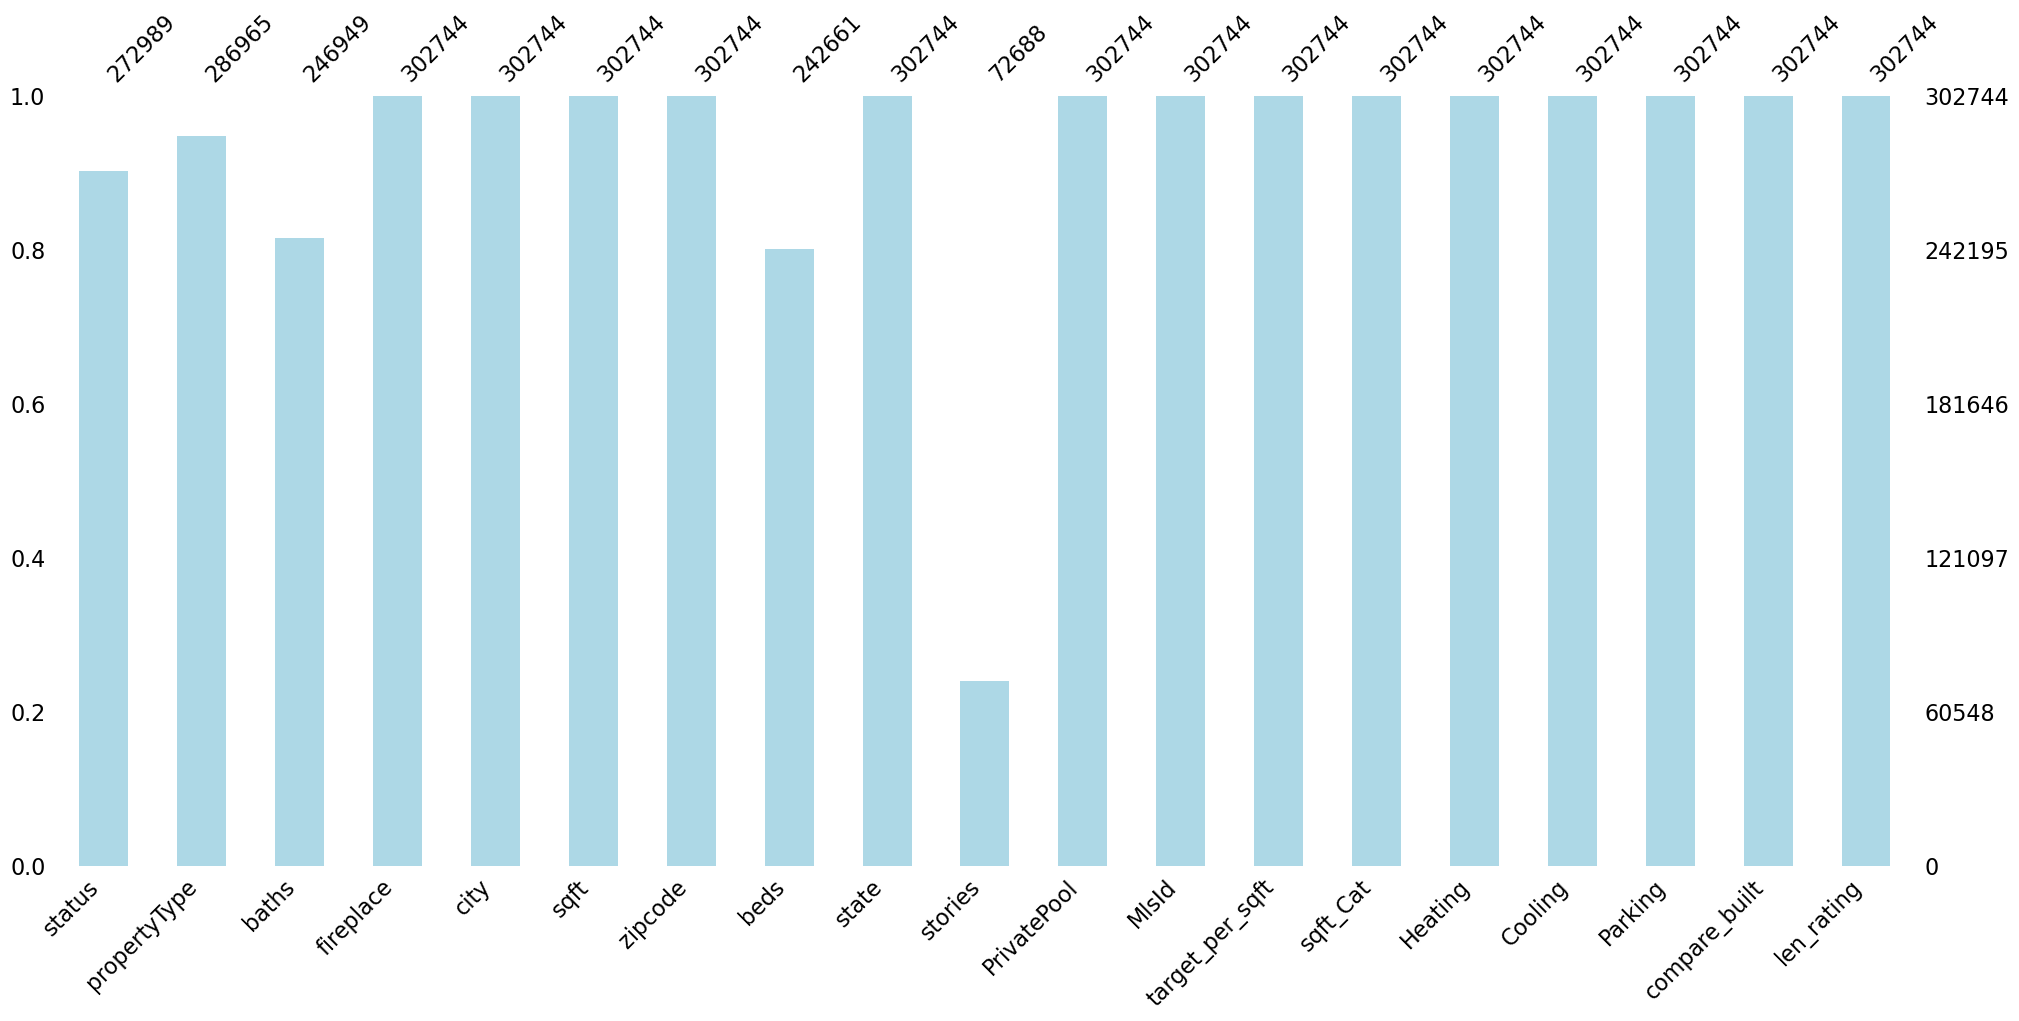

In [345]:
# визуализируем
msno.bar(df_per_sqft, color='lightblue')

## Status

In [346]:
# создадим отдельную выборку с признаком status - nan
df_status = df_per_sqft[pd.isnull(df_per_sqft['status'])]

In [347]:
# посмотрим как распределяются пропуски по штатам
# группируем по штатам
treemap_data = df_status.groupby(
    by='state',
    as_index=False
)[['propertyType']].count()

#строим график
fig = px.treemap(
    data_frame=treemap_data, #DataFrame
    path=['state'], #категориальный признак, для которого строится график
    values='propertyType', #параметр, который сравнивается
    height=700, #высота
    width=1500, #ширина
    title='Пропуски в признаке статус по штатам' #заголовок
)

#отображаем график
fig.show()

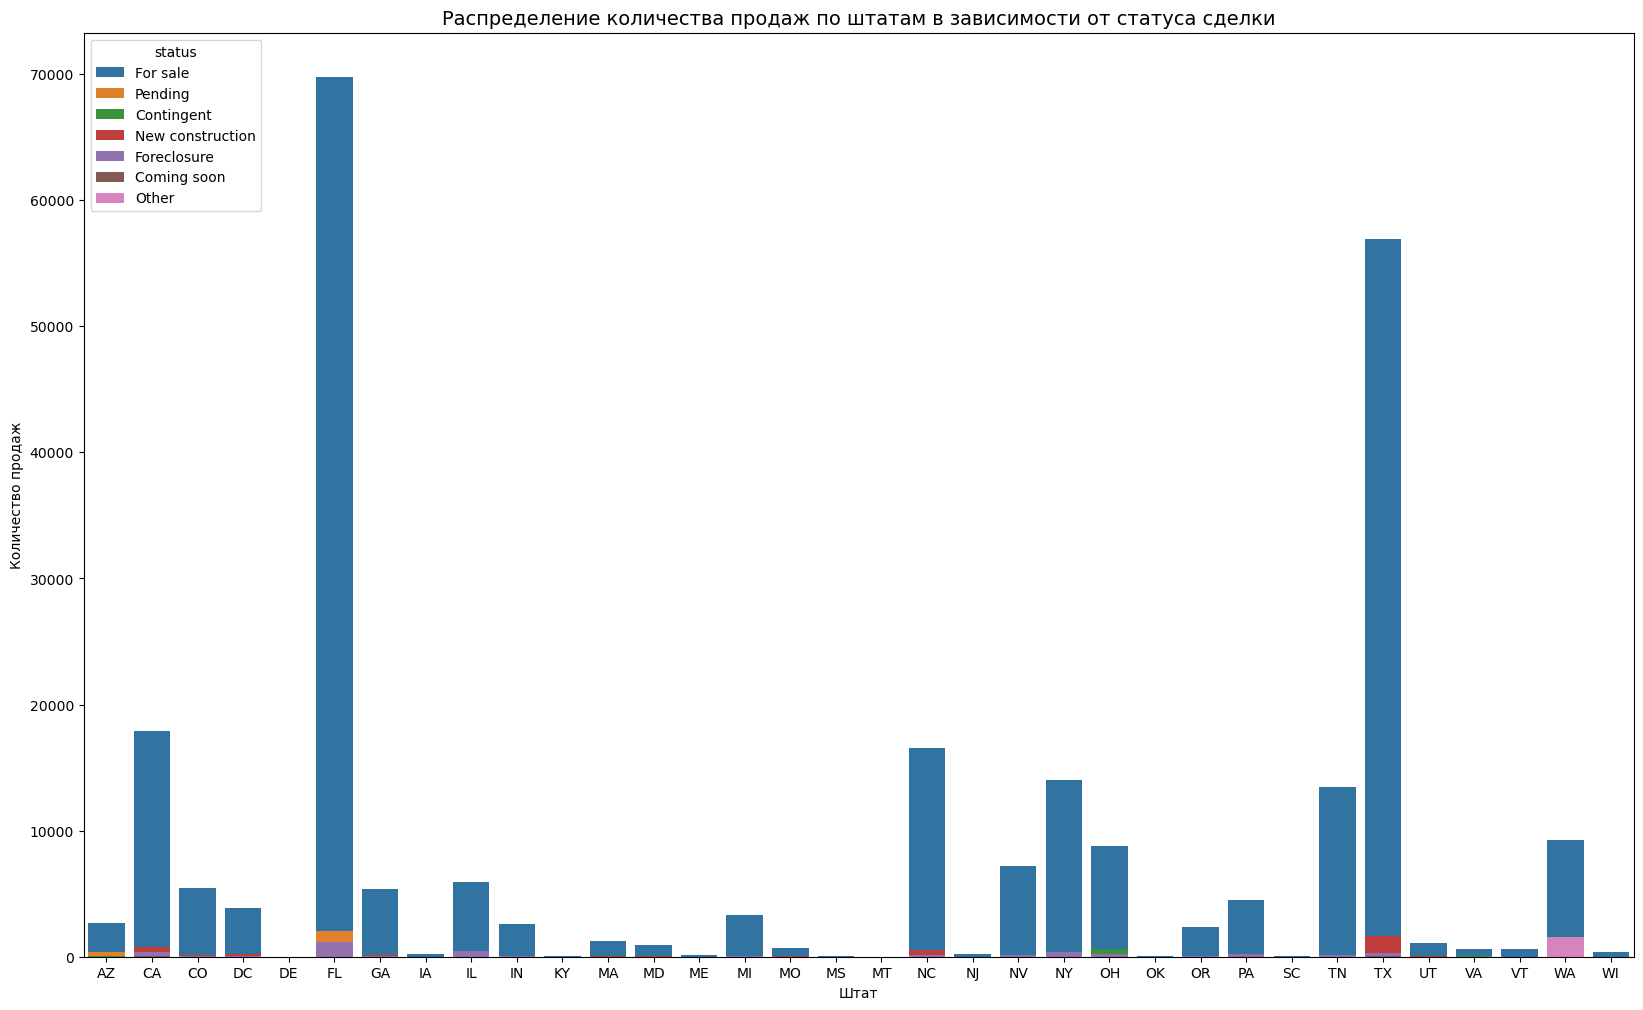

In [348]:
# посмотрим распределение по штатам в зависимости от статуса сделки в основной базе
state_status = df_per_sqft.groupby('state', as_index=True)['status'].value_counts()

plt.figure(figsize=(20,12))  # Увеличение размера диаграммы

barplot = sns.barplot(
    data=state_status.reset_index(),
    x='state',
    y='count',
    hue='status',
    orient='v',
    dodge=False
)

barplot.set_title('Распределение количества продаж по штатам в зависимости от статуса сделки', fontsize=14)
barplot.set_xlabel('Штат')
barplot.set_ylabel('Количество продаж')
#barplot.grid(True)

plt.show()

In [349]:
# выведем данные
df_status.head()

,status,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
9,NaN,SingleFamiily,3.0,0,Houston,1930.0,77080,3.0,TX,NaN,0.0,1,161.655440,average,individual,central,garage,0,3.0
14,NaN,SingleFamiily,3.0,0,Houston,2454.0,77084,4.0,TX,NaN,0.0,1,68.785656,average,other,central,parking,0,3.0
33,NaN,Condo,2.0,0,North Miami Beach,1085.0,33160,2.0,FL,NaN,0.0,1,164.976959,little,central,central,street,0,2.0
52,NaN,Condo,4.0,0,Miami,1873.0,33137,3.0,FL,NaN,0.0,1,950.347037,average,central,central,street,0,2.0
63,NaN,SingleFamiily,3.0,0,San Antonio,2688.0,78260,3.0,TX,NaN,0.0,0,152.183408,average,no,no,parking,0,3.0


In [350]:
# максимальная и минимальная стоимость в пропусках 
df_status['sqft'].min(), df_status['sqft'].max()

(150.0, 34039.0)

In [351]:
# наиболее часто встречающийся тип недвижимости в пропусках
df_status['propertyType'].value_counts()

propertyType
SingleFamiily    18453
Condo             7763
Townhouse         2688
MultiFamily        599
Manufactured       147
Coop                65
UniqueHouse         13
Ranch                5
Traditional          4
Contemporary         2
Name: count, dtype: int64

In [352]:
# самая встречающаяся площадь в пропусках
df_status['sqft_Cat'].value_counts()

sqft_Cat
average       15090
little         7618
average+       6063
big             711
tiny            226
big+             42
huge              4
super huge        1
Name: count, dtype: int64

Мы видим, что ничего такого выдающегося в пропусках мы не видим. В основном это квартиры или дома средней величины, для семей. Заполним пропуски наиболее часто встречающимся значением - For sale. 

In [353]:
# заполним пропуски наиболее часто встречающимся значением - For sale
df_per_sqft['status'] = df_per_sqft['status'].fillna('For sale')

## Stories

In [354]:
# создадим базу пропусков по этажам
df_stories =df_per_sqft[pd.isnull(df_per_sqft['stories'])]
df_stories

,status,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
0,For sale,SingleFamiily,3.0,1,Southern Pines,2900.0,28387,4.0,NC,NaN,0.0,1,144.137931,average+,central,no,street,0,8.0
1,For sale,SingleFamiily,3.0,0,Spokane Valley,1947.0,99216,3.0,WA,NaN,0.0,1,159.219312,average,no,no,street,0,3.0
2,For sale,SingleFamiily,2.0,1,Los Angeles,3000.0,90049,3.0,CA,NaN,1.0,1,965.000000,average+,central,central,garage,1,3.0
3,For sale,SingleFamiily,8.0,1,Dallas,6457.0,75205,5.0,TX,NaN,0.0,1,370.915286,big,central,central,garage,0,4.0
5,For sale,Townhouse,NaN,0,Philadelphia,897.0,19145,2.0,PA,NaN,0.0,1,232.998885,little,central,central,street,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377178,For sale,SingleFamiily,2.0,0,Houston,1841.0,77089,4.0,TX,NaN,0.0,0,137.419880,average,no,no,parking,0,3.0
377179,For sale,Condo,3.0,0,Washington,1417.0,20001,2.0,DC,NaN,0.0,1,563.867325,average,central,central,parking,0,2.0
377180,For sale,SingleFamiily,6.0,0,Miami,4017.0,33180,5.0,FL,NaN,1.0,1,310.928554,average+,other,central,parking,0,2.0
377181,For sale,Condo,3.0,0,Chicago,2000.0,60657,3.0,IL,NaN,0.0,1,337.499500,average,individual,no,street,0,3.0


In [355]:
# посмотрим какая у нас этажность в каждом типе недвижимости
# df_per_sqft.groupby(['propertyType'])['stories'].median()

Отметим, что после всех преобразований в признаке propertyType в значении other, осталось всего 14 значений. Т.к тут nan, мы не можем заполнить его корректно. Удалим, значения other из признака PropertyType

In [356]:
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['propertyType'] == 'Other'].index)

In [357]:
# посмотрим какая у нас этажность в каждом типе недвижимости
df_per_sqft.groupby(['propertyType'])['stories'].agg(['median', 'max', 'min'])

,median,max,min
propertyType,,,
Condo,2.0,75.0,1.0
Contemporary,2.0,4.0,1.0
Coop,1.0,9.0,1.0
Highlevel,2.0,3.0,1.0
Land,0.0,0.0,0.0
Manufactured,2.0,2.0,1.0
MultiFamily,2.0,9.0,1.0
Ranch,1.0,4.0,1.0
SingleFamiily,1.0,9.0,1.0


Заполним признак stories медианными значениями по группировке тип недвижимости и этаж

In [358]:
# создаем серию median_values
median_values = df_per_sqft.groupby(['propertyType'])['stories'].median()
# заполняем
df_per_sqft['stories'] = df_per_sqft['stories'].fillna(df_per_sqft['propertyType'].map(median_values))

In [359]:
# смотрим сколько значений осталось
df_per_sqft['stories'].isnull().sum()

9057

Поскольку мы заполняли по признаку PropertyType заполнились не все значения. Осталось 9057 пропусков. 

Сразу видим, что Таунхауз не может быть 56 этажей. Посмотрим, что это за таунхауз и видим, что и по площади и по спальням это скорее сего 2 этажа. Исправим. 

In [360]:
df_per_sqft[df_per_sqft['stories'] == 56]

,status,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
114125,For sale,Townhouse,3.0,0,Anaheim,1712.0,92807,3.0,CA,56.0,1.0,0,425.817757,average,central,central,garage,0,3.0


In [361]:
# подставим новое значение в элемент с индексом 114125
index = 114125
new_value = 2

if index in df_per_sqft.index:
    df_per_sqft.at[index, 'stories'] = new_value
else:
    new_row = pd.Series({'stories': new_value}, name=index)
    df_per_sqft = df_per_sqft.append(new_row)

Так же у нас есть Таунхауз 9 этажей. Думаю, что стоит оставить эти значения без исправлений. Во первых, недвижимость в разных местах. Во вторых, например, рядом со мной в пригороде построили квартал из 4-5 этажных домов и тоже называют их таунхаусами. Возможно, это просто квартиры в многоэтажке за городом. Посмотрим, лучше на Кондоминиум в 75 этажей)

In [362]:
df_per_sqft[df_per_sqft['stories'] == 75]

,status,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
142442,For sale,Condo,2.0,0,New York,725.0,10019,NaN,NY,75.0,1.0,1,1786.206897,little,no,no,parking,0,6.0
178697,For sale,Condo,3.0,0,New York,1188.0,10019,2.0,NY,75.0,1.0,1,1426.767677,little,no,no,parking,0,6.0


Не буду менять. В Нью-Йорке нашлось несколько 75 этажных домов. Возможно, это чась квартиры так называется. 

## PropertyType

In [363]:
# вспомним, какие типы у нас есть 
df_per_sqft['propertyType'].value_counts()

propertyType
SingleFamiily    181788
Condo             47954
Townhouse         17798
MultiFamily       10227
UniqueHouse        6583
Traditional        6376
Contemporary       3246
Manufactured       3109
Land               2880
Ranch              2852
Coop               2403
Highlevel          1735
Name: count, dtype: int64

In [364]:
# создадим базу пропусков по признаку Тип недвижимости
df_pt = df_per_sqft[pd.isnull(df_per_sqft['propertyType'])]
df_pt

,status,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
16,For sale,NaN,1.0,0,Fort Lauderdale,2203.0,33311,NaN,FL,NaN,0.0,1,152.065365,average,no,no,street,1,4.0
79,For sale,NaN,NaN,0,Miami Beach,538.0,33140,NaN,FL,NaN,0.0,1,1208.178439,little,central,individual,street,0,5.0
93,For sale,NaN,NaN,0,ORLANDO,667.0,32801,NaN,FL,1.0,0.0,1,207.646177,little,central,central,street,0,7.0
103,For sale,NaN,NaN,0,Lauderhill,972.0,33319,NaN,FL,NaN,0.0,1,97.633745,little,no,no,street,1,3.0
109,For sale,NaN,NaN,0,Jacksonville,1000.0,32206,NaN,FL,NaN,0.0,1,169.000000,little,no,no,street,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377076,Foreclosure,NaN,2.0,0,ORLANDO,1456.0,32825,NaN,FL,2.0,0.0,1,144.230769,average,central,central,street,0,5.0
377095,For sale,NaN,NaN,0,Fort Lauderdale,1180.0,33308,NaN,FL,NaN,0.0,1,283.898305,little,central,individual,street,0,3.0
377110,For sale,NaN,NaN,0,Brooklyn,4860.0,11219,NaN,NY,3.0,0.0,1,452.469136,average+,no,no,street,0,3.0
377143,For sale,NaN,NaN,0,Miami,842.0,33145,NaN,FL,NaN,0.0,1,355.106888,little,central,individual,street,0,5.0


In [365]:
# в каком статусе сделки больше всего пропусков
df_pt['status'].value_counts()

status
For sale            15705
Pending                31
Foreclosure            29
New construction        7
Contingent              6
Other                   1
Name: count, dtype: int64

In [366]:
# сколько этажей в пропусках
df_pt['stories'].value_counts()

stories
1.0    3817
2.0    2474
3.0     406
4.0      20
5.0       3
6.0       1
7.0       1
Name: count, dtype: int64

In [367]:
# величина объекта с пропусками
df_pt['sqft_Cat'].value_counts()

sqft_Cat
average       7523
little        5008
average+      2663
big            380
tiny           124
big+            66
super huge       8
huge             7
Name: count, dtype: int64

In [368]:
# сколько значений содержат пропуски во всех четырех признаках
total_missing = df_per_sqft[['propertyType', 'baths', 'beds', 'stories']].isna().all(axis=1).sum()
total_missing

6571

In [369]:
# удалим их, чтобы не придумывать больше, чем напридумывала
df_per_sqft.dropna(subset=['propertyType', 'baths', 'beds', 'stories'], how='all', inplace=True)

In [370]:
df_per_sqft.isnull().sum()

status                 0
propertyType        9208
baths              49210
fireplace              0
city                   0
sqft                   0
zipcode                0
beds               53498
state                  0
stories             2486
PrivatePool            0
MlsId                  0
target_per_sqft        0
sqft_Cat               0
Heating                0
Cooling                0
Parking                0
compare_built          0
len_rating             0
dtype: int64

In [371]:
# обновим базу пропусков по признаку Тип недвижимости
df_pt = df_per_sqft[pd.isnull(df_per_sqft['propertyType'])]

In [372]:
# в каком статусе сделки больше всего пропусков
df_pt['status'].value_counts()

status
For sale            9149
Foreclosure           26
Pending               24
New construction       5
Contingent             3
Other                  1
Name: count, dtype: int64

In [373]:
# этажность с пропусками 
df_pt['stories'].value_counts()

stories
1.0    3817
2.0    2474
3.0     406
4.0      20
5.0       3
6.0       1
7.0       1
Name: count, dtype: int64

In [374]:
# величина объекта с пропусками
df_pt['sqft_Cat'].value_counts()

sqft_Cat
average       4655
little        2549
average+      1717
big            192
tiny            59
big+            33
super huge       2
huge             1
Name: count, dtype: int64

Видим, что в основном, в пропущенных значениях Тип недвижимости небольшие и средние дома. Это укладывается в основной тип 'SingleFamiily', заполним недостающие значения этим типом. 

In [375]:
# заполним наиболее часто встречающимися значениями
df_per_sqft['propertyType'].fillna('SingleFamiily', inplace=True)

## Baths и Beds

После небольшого исследования, я пришла к выводу, что признак 'baths' совершенно не информативный. В нем присутствуют и выбросы и корреляция очень высокая с количеством спален, и непонятные значения ввиде десятичных значений. Удалим его. И проработаем признак 'beds'

In [376]:
# уберем ненужные признаки 
drop_list = ['baths']
df_per_sqft.drop(drop_list, axis=1, inplace=True)

In [377]:
# сгруппируем данные по площади и количеству спален, посмотрим на минимальное, максимальное, медианное значение и моду - наиболее часто встречающееся значение
df_cat_beds = df_per_sqft.groupby(['sqft_Cat'])['beds'].agg(['max', 'min', 'median', pd.Series.mode])
df_cat_beds

,max,min,median,mode
sqft_Cat,,,,
average,47.0,0.0,3.0,3.0
average+,46.0,0.0,4.0,4.0
big,36.0,0.0,5.0,5.0
big+,78.0,0.0,6.0,6.0
huge,99.0,0.0,6.0,6.0
little,32.0,0.0,2.0,2.0
super huge,144.0,0.0,3.0,3.0
tiny,7.0,0.0,1.0,1.0


Заполним недостающие данные в признаке 'beds' медианным медианным значением по группировке Величина жилья - количество спален.

In [378]:
# создаем серию median_values_beds
median_values_beds = df_per_sqft.groupby(['sqft_Cat'])['beds'].median()
# заполняем
df_per_sqft['beds'] = df_per_sqft['beds'].fillna(df_per_sqft['sqft_Cat'].map(median_values_beds))

In [379]:
# посмотрим на выбросы в спальнях, т.к у нас есть очень маленькие площади с очень большим количеством спален
df_tiny_beds = df_per_sqft[(df_per_sqft['beds'] > 6) & (df_per_sqft['sqft_Cat'] == 'tiny')]
df_tiny_beds

,status,propertyType,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
330207,For sale,MultiFamily,0,Yonkers,300.0,10705,7.0,NY,2.0,0.0,1,1750.0,tiny,other,other,parking,0,2.0


Могу предположить, что это двухуровневая квартира, и указано количество не спален, а спальных мест. В метрах, это квартира примерно 27 квадратных метров. 

In [380]:
# посмотрим на выбросы в спальнях, т.к у нас есть маленькие площади с очень большим количеством спален
df_little_beds = df_per_sqft[(df_per_sqft['beds'] > 3) & (df_per_sqft['sqft_Cat'] == 'little')]
df_little_beds

,status,propertyType,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
141,For sale,SingleFamiily,0,Detroit,1008.0,48234,4.0,MI,1.0,0.0,1,47.619048,little,central,no,garage,0,15.0
145,For sale,SingleFamiily,0,Jamaica,1062.0,11411,4.0,NY,2.0,0.0,1,620.527307,little,other,no,garage,0,4.0
172,For sale,SingleFamiily,0,Reno,1152.0,89506,4.0,NV,1.0,0.0,1,251.736111,little,central,no,parking,0,3.0
320,For sale,Manufactured,0,Las Vegas,1152.0,89122,4.0,NV,2.0,0.0,1,130.208333,little,central,central,garage,0,3.0
649,For sale,SingleFamiily,1,Fayetteville,869.0,28306,4.0,NC,1.0,1.0,1,247.410817,little,central,no,garage,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376058,For sale,SingleFamiily,0,San Antonio,1178.0,78213,4.0,TX,1.0,0.0,1,127.249576,little,individual,central,street,0,3.0
376110,For sale,SingleFamiily,0,Capitol Heights,1120.0,20743,4.0,MD,2.0,0.0,1,236.607143,little,central,central,garage,0,8.0
376444,For sale,SingleFamiily,0,Oakland,1229.0,94607,4.0,CA,1.0,0.0,1,528.885273,little,individual,no,parking,0,3.0
376467,For sale,SingleFamiily,1,East Pt,1278.0,30344,5.0,GA,1.0,0.0,1,132.942097,little,central,central,garage,0,3.0


In [381]:
# посмотрим на выбросы в спальнях, т.к у нас есть средние площади с очень большим количеством спален
df_average_beds = df_per_sqft[(df_per_sqft['beds'] == 12) & (df_per_sqft['sqft_Cat'] == 'average') & (df_per_sqft['state'] == 'NY')]
df_average_beds

,status,propertyType,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
2827,For sale,Condo,0,Ridgewood,2500.0,11385,12.0,NY,2.0,0.0,0,520.000000,average,no,no,street,0,4.0
60250,For sale,MultiFamily,0,Brooklyn,2400.0,11203,12.0,NY,2.0,0.0,1,724.166667,average,no,no,garage,0,3.0
119004,For sale,MultiFamily,0,Brooklyn,1850.0,11237,12.0,NY,2.0,0.0,0,594.054054,average,no,no,street,0,2.0
147343,For sale,MultiFamily,0,Brooklyn,1920.0,11232,12.0,NY,2.0,0.0,0,1353.645833,average,no,no,street,0,1.0
179517,For sale,MultiFamily,0,Yonkers,2572.0,10701,12.0,NY,2.0,0.0,1,369.323484,average,individual,no,street,0,2.0
278550,For sale,SingleFamiily,0,Staten Island,2580.0,10301,12.0,NY,1.0,0.0,1,184.108527,average,individual,no,street,0,3.0
289914,For sale,MultiFamily,0,Brooklyn,1450.0,11222,12.0,NY,2.0,0.0,1,958.620690,average,other,no,street,0,1.0
327368,For sale,MultiFamily,0,Brooklyn,2500.0,11221,12.0,NY,2.0,0.0,0,880.000000,average,no,no,street,0,1.0


In [382]:
# посмотрим на выбросы в спальнях, т.к у нас есть средние площади с очень большим количеством спален
df_averagep_beds = df_per_sqft[(df_per_sqft['beds'] > 10) & (df_per_sqft['sqft_Cat'] == 'average+')]
df_averagep_beds

,status,propertyType,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
139,For sale,MultiFamily,0,Los Angeles,4368.0,90016,12.0,CA,2.0,0.0,1,389.194139,average+,individual,no,parking,0,2.0
260,For sale,MultiFamily,0,Oakland,5225.0,94619,14.0,CA,2.0,0.0,1,401.913876,average+,individual,no,parking,0,2.0
2732,For sale,MultiFamily,0,Brooklyn,4130.0,11237,12.0,NY,2.0,0.0,1,375.060533,average+,no,no,street,0,2.0
4408,For sale,MultiFamily,0,North Hollywood,4440.0,91606,12.0,CA,2.0,0.0,1,337.837838,average+,individual,central,parking,0,3.0
16504,For sale,MultiFamily,0,Los Angeles,3550.0,90007,11.0,CA,2.0,0.0,1,556.338028,average+,individual,individual,parking,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358548,For sale,MultiFamily,0,Brooklyn,5200.0,11221,16.0,NY,2.0,0.0,0,567.307692,average+,no,no,street,0,2.0
368110,For sale,MultiFamily,1,Fresno,3640.0,93701,12.0,CA,2.0,0.0,1,92.032967,average+,no,individual,carport,0,3.0
372005,For sale,SingleFamiily,0,Pompano Beach,4214.0,33062,11.0,FL,1.0,0.0,1,212.387280,average+,no,no,street,1,3.0
372342,For sale,MultiFamily,0,Los Angeles,3874.0,90026,11.0,CA,2.0,0.0,1,670.882808,average+,no,no,street,0,8.0


Таких 'выбросов' у нас сравнительно немного 2 756, возможно, указывается количество кроватей, которые можно вместить, а может это просто ошибка людей, которые вбивают данные. Интересно, что нам скажет метод Тьюки. По поводу выбросов в этом признаке. 

In [383]:
# Рассчитываем межквартильный размах
Q1 = df_per_sqft['beds'].quantile(0.25)
Q3 = df_per_sqft['beds'].quantile(0.75)
IQR = iqr(df_per_sqft['beds'])

# Определяем границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем данные и находим выбросы
outliers_t = df_per_sqft['beds'][(df_per_sqft['beds'] < lower_bound) | (df_per_sqft['beds'] > upper_bound)]

# Выводим количество выбросов
print("Количество выбросов в признаке 'beds' по методу Тьюки:", len(outliers_t))

Количество выбросов в признаке 'beds' по методу Тьюки: 19216


In [384]:
# И z - метод
# Рассчитываем среднее и стандартное отклонение
mean = df_per_sqft['beds'].mean()
std = df_per_sqft['beds'].std()

# Определяем порог z-score для выбросов (обычно используется значение 3)
threshold = 3

# Стандартизируем данные
z_scores = (df_per_sqft['beds'] - mean) / std

# Фильтруем данные и находим выбросы
outliers_z = df_per_sqft[np.abs(z_scores) > threshold]

# Выводим количество выбросов
print("Количество выбросов в признаке 'beds' по z-методу:", len(outliers_z))

Количество выбросов в признаке 'beds' по z-методу: 2240


Количество выбросов по z методу, приблизительно совпало с моими расчетами. Попробуем удалить эти выбросы. 

In [385]:
# Удаляем строки с выбросами по z методу
df_per_sqft = df_per_sqft.drop(outliers_z.index)

In [386]:
# посмотрим на распределение после удаления данных 
df_cat_beds = df_per_sqft.groupby(['sqft_Cat'])['beds'].agg(['max', 'min', 'median', pd.Series.mode])
df_cat_beds

,max,min,median,mode
sqft_Cat,,,,
average,7.0,0.0,3.0,3.0
average+,7.0,0.0,4.0,4.0
big,7.0,0.0,5.0,5.0
big+,7.0,0.0,6.0,6.0
huge,7.0,0.0,6.0,6.0
little,7.0,0.0,2.0,2.0
super huge,7.0,0.0,3.0,3.0
tiny,7.0,0.0,1.0,1.0


Несомненно, признак теперь выглядит логичней. Оставим так. 

## Stories

In [387]:
# посмотрим на распределение этажности и площади
df_cat_stories = df_per_sqft.groupby(['sqft_Cat'])['stories'].agg(['max', 'min', 'median', pd.Series.mode])
df_cat_stories

,max,min,median,mode
sqft_Cat,,,,
average,57.0,0.0,1.0,1.0
average+,9.0,0.0,1.0,1.0
big,9.0,0.0,1.0,1.0
big+,7.0,0.0,1.0,1.0
huge,6.0,0.0,1.0,1.0
little,75.0,0.0,2.0,2.0
super huge,9.0,0.0,1.0,1.0
tiny,9.0,0.0,2.0,2.0


In [388]:
# И z - метод
# Рассчитываем среднее и стандартное отклонение
mean = df_per_sqft['stories'].mean()
std = df_per_sqft['stories'].std()

# Определяем порог z-score для выбросов (обычно используется значение 3)
threshold = 3

# Стандартизируем данные
z_scores = (df_per_sqft['stories'] - mean) / std

# Фильтруем данные и находим выбросы
outliers_z = df_per_sqft[np.abs(z_scores) > threshold]

# Выводим количество выбросов
print("Количество выбросов в признаке 'stories' по z-методу:", len(outliers_z))

Количество выбросов в признаке 'stories' по z-методу: 1937


In [389]:
# посмотрим, какие значения попали в выбросы
outliers_z['stories'].value_counts()

stories
4.0     910
9.0     457
6.0     234
5.0     177
7.0      81
8.0      72
57.0      3
75.0      2
58.0      1
Name: count, dtype: int64

In [390]:
# посмотрим на распределение этажности и площади
out_stories = outliers_z.groupby(['sqft_Cat'])['stories'].agg(['max', 'min', 'median', pd.Series.mode])
out_stories

,max,min,median,mode
sqft_Cat,,,,
average,57.0,4.0,4.0,4.0
average+,9.0,4.0,4.0,4.0
big,9.0,4.0,4.0,4.0
big+,7.0,4.0,4.0,4.0
huge,6.0,6.0,6.0,6.0
little,75.0,4.0,6.0,4.0
super huge,9.0,6.0,9.0,9.0
tiny,9.0,4.0,5.0,"[4.0, 9.0]"


Понятно, что скорее всего агенты указывали некую общую этажность, и маленькая квартира может быть в 75 этажном небоскребе. Таких квартир у меня всего 6 и все они располагаются в Нью-Йорке. Вполне себе реальная ситуация. Оставим, пока, как есть.  

In [391]:
df_per_sqft[df_per_sqft['stories']>56]

,status,propertyType,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target_per_sqft,sqft_Cat,Heating,Cooling,Parking,compare_built,len_rating
47910,For sale,Condo,0,New York,1423.0,10022,2.0,NY,57.0,0.0,1,1440.618412,average,no,no,parking,0,7.0
67598,For sale,Condo,0,New York,606.0,10006,2.0,NY,58.0,0.0,0,1600.660066,little,central,central,street,0,6.0
126392,For sale,Condo,0,New York,513.0,10022,2.0,NY,57.0,0.0,1,1460.038986,little,no,no,parking,0,7.0
142442,For sale,Condo,0,New York,725.0,10019,2.0,NY,75.0,1.0,1,1786.206897,little,no,no,parking,0,6.0
178697,For sale,Condo,0,New York,1188.0,10019,2.0,NY,75.0,1.0,1,1426.767677,little,no,no,parking,0,6.0
282827,Foreclosure,Condo,0,New York,821.0,10021,2.0,NY,57.0,0.0,1,1272.838002,little,no,central,garage,0,7.0


In [392]:
# создаем серию median_values_stories и заполним недостающую этажность медианной величиной
median_values_stories = df_per_sqft.groupby(['sqft_Cat'])['stories'].median()
# заполняем
df_per_sqft['stories'] = df_per_sqft['stories'].fillna(df_per_sqft['sqft_Cat'].map(median_values_stories))

## SQFT

У нас остался еще один очень важный признак 'sqft' - площадь недвижимости. Попробуем оценить выбросы в этом признаке. Просто слишком большие площади, скорее всего, требуют неких индивидуальных подходов. Поэтому, я совсем не уверена, что они нужны нам для построения модели. 

In [393]:
# И z - метод
# Рассчитываем среднее и стандартное отклонение
mean = df_per_sqft['sqft'].mean()
std = df_per_sqft['sqft'].std()

# Определяем порог z-score для выбросов (обычно используется значение 3)
threshold = 3

# Стандартизируем данные
z_scores = (df_per_sqft['sqft'] - mean) / std

# Фильтруем данные и находим выбросы
outliers_z = df_per_sqft[np.abs(z_scores) > threshold]

# Выводим количество выбросов
print("Количество выбросов в признаке 'sqft' по z-методу:", len(outliers_z))

Количество выбросов в признаке 'sqft' по z-методу: 1230


In [394]:
outliers_z['sqft_Cat'].value_counts()

sqft_Cat
big+          675
big           400
huge           78
super huge     77
Name: count, dtype: int64

In [395]:
outliers_z['propertyType'].value_counts()

propertyType
SingleFamiily    817
MultiFamily      148
Coop             101
Land              56
UniqueHouse       37
Condo             23
Traditional       22
Townhouse         14
Contemporary      10
Ranch              2
Name: count, dtype: int64

In [396]:
# Удаляем строки с выбросами по z методу - верхняя граница с выбросами 
df_per_sqft = df_per_sqft.drop(outliers_z.index)

In [397]:
# удалим объекты менее 300 квадратных фута т.е 27 метра квадратных
df_per_sqft = df_per_sqft.drop(df_per_sqft[df_per_sqft['sqft'] < 300].index)

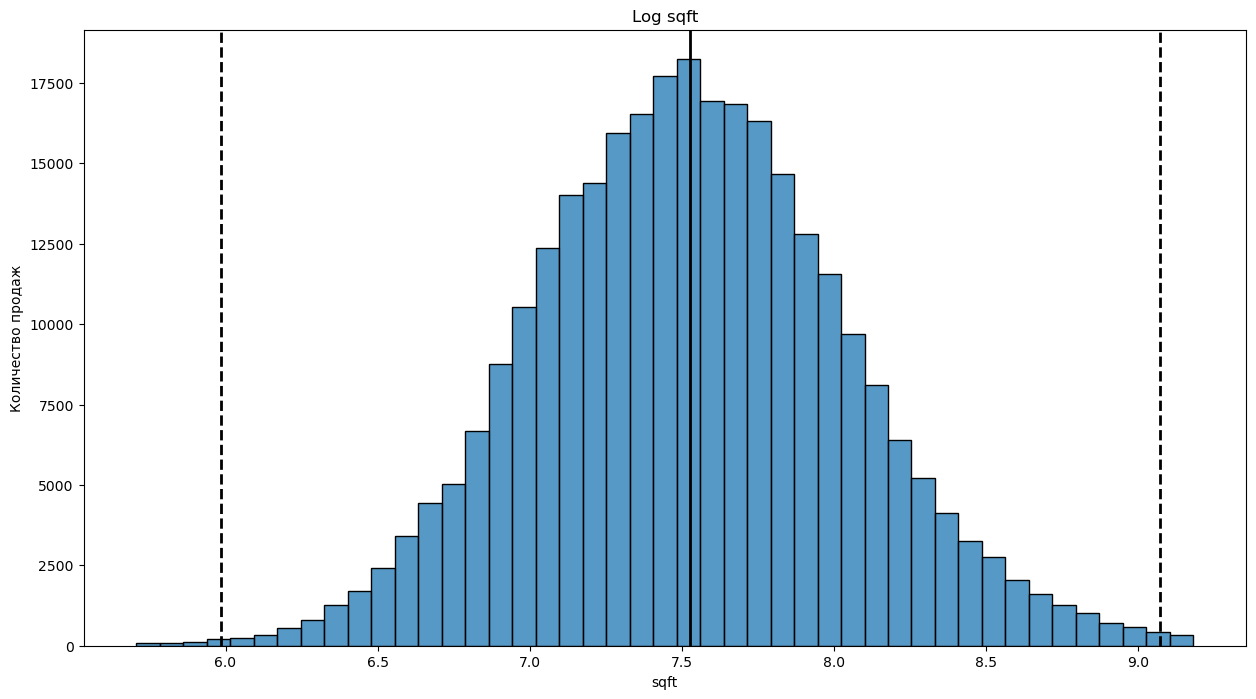

In [398]:
# распределение и выбросы прологорифмированного признака
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
log_target = np.log(df_per_sqft['sqft'] +1)
histplot = sns.histplot(log_target, bins=45, ax=ax)
histplot.axvline(log_target.mean(), color='k', lw=2)
histplot.axvline(log_target.mean()+ 3 * log_target.std(), color='k', ls='--', lw=2)
histplot.axvline(log_target.mean()- 3 * log_target.std(), color='k', ls='--', lw=2)
histplot.set_ylabel('Количество продаж')
histplot.set_title('Log sqft');

Признак распределен нормально. Почти идеально. Но с выбросами. Считаю, что для хорошего качества моделирования необходимо убрать верхнюю и нижнюю границу с выбросами. Тогда у нас уйдут четыре значения из признака 'sqft_Cat', но их оччень мало и по ним действительно много вопросов. Попробуем их удалить. 

In [399]:
df_per_sqft['sqft_Cat'].value_counts()

sqft_Cat
average     153886
little       70622
average+     59630
big           7137
tiny          1322
Name: count, dtype: int64

Text(0.5, 1.0, 'Зависимость средней стоимости квадратного метра от площади по штатам')

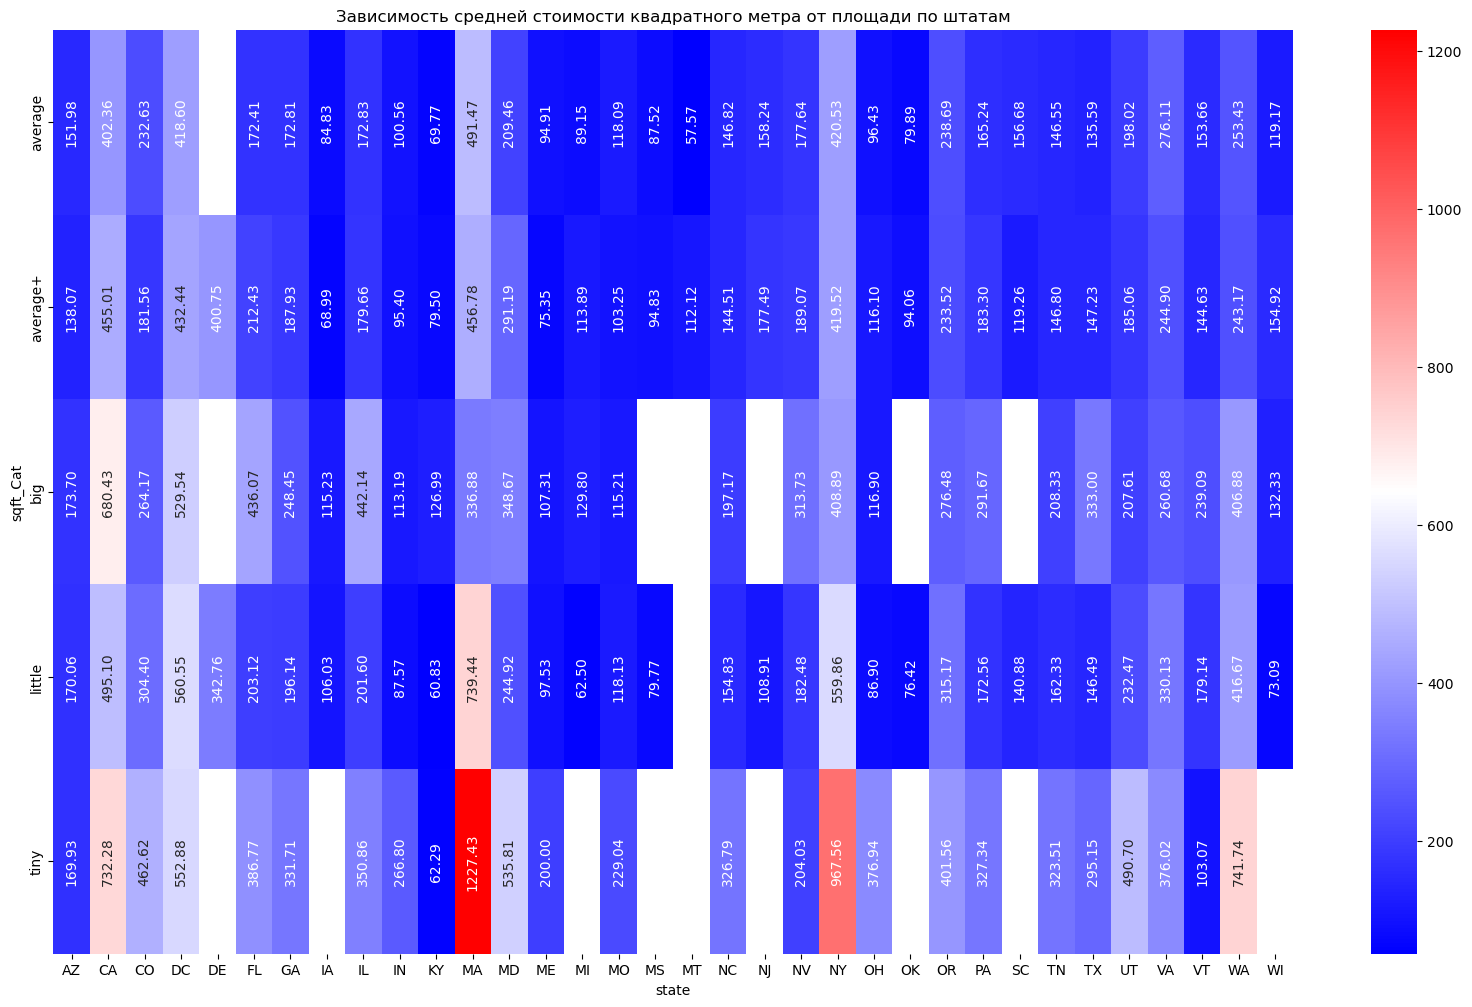

In [400]:
# посмотрим еще раз на взаимосвязь между медианной ценой и площадью
pivot_heat = df_per_sqft.pivot_table(
    values='target_per_sqft',
    index='sqft_Cat',
    columns='state',
    aggfunc='median'  
)
fig = plt.figure(figsize=(20, 12))
ax = sns.heatmap(data=pivot_heat, annot=True, fmt='.2f', cmap='bwr', annot_kws={'rotation': 90})
ax.set_title('Зависимость средней стоимости квадратного метра от площади по штатам')

In [401]:
# df_ma = df_per_sqft[(df_per_sqft['state'] == 'MA') & (df_per_sqft['sqft_Cat'] == 'tiny')]
# df_ma

Я проверила, ни для Майами ни для Нью-Йорка, высокие значения сложно считать выбросами. Т.к там очень высокая стоимость жилья. 

In [402]:
# итог
df_per_sqft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292597 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           292597 non-null  object 
 1   propertyType     292597 non-null  object 
 2   fireplace        292597 non-null  int64  
 3   city             292597 non-null  object 
 4   sqft             292597 non-null  float64
 5   zipcode          292597 non-null  int64  
 6   beds             292597 non-null  float64
 7   state            292597 non-null  object 
 8   stories          292597 non-null  float64
 9   PrivatePool      292597 non-null  float64
 10  MlsId            292597 non-null  int64  
 11  target_per_sqft  292597 non-null  float64
 12  sqft_Cat         292597 non-null  object 
 13  Heating          292597 non-null  object 
 14  Cooling          292597 non-null  object 
 15  Parking          292597 non-null  object 
 16  compare_built    292597 non-null  int64  
 

Уберу город, т.к очень много признаков указывающих на местоположение. Кроме того город нужно заново вытягивать из геобиблиотек, либо как-то очень хорошо обрабатывать, т.к мелейшая ошибка в слове - это новое значение. Признак sqft_Cat - это площадь. Я создавала его для упрощения анализа и считаю, что он не нужен. 

In [403]:
# уберем ненужные признаки 
drop_list = ['city', 'sqft_Cat']
df_per_sqft.drop(drop_list, axis=1, inplace=True)

Подведем итог: 18 признаков. удалось сохранить 292597 из 377185 значений. 84588 или 22% значений были удалены от первоначальной базы. Не знаю хорошо это или плохо, но я постаралась сохранить как можно больше.  

In [404]:
# Записываем DataFrame в новый файл CSV
df_per_sqft.to_csv('data_clean.csv', index=False)